In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [4]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [5]:
from tensorflow.keras.models import Model

In [6]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


In [7]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
#from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

### Load Data

In [8]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 500

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

##### Load the h5

In [9]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
35549
35549
35549
35549
35549
35549
35549
35549

 Signal Events
32015
32015
32015
32015
32015
32015
32015
32015


In [10]:
################
# ALL THE DATA #
################


# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
#num_data = 30000
num_data = 15000


In [11]:
###################
# peakS1_onlyhits #
###################

# First:
# The max len for the time series

max_pS1_B = 0
max_pS1_S = 0

for i in range(1, num_data+1):
    max_pS1_B = max(max_pS1_B, len( f_B['peakS1_onlyhits/ev_'+str(i)] ))
    max_pS1_S = max(max_pS1_S, len( f_S['peakS1_onlyhits/ev_'+str(i)] ))
    
    
max_pS1_both = max(max_pS1_B,max_pS1_S)

print('max_pS1_both lenght: ', max_pS1_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S1 or S2) arrays with the same length
diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_1'][()] )

# add zeros at the end
peakS1_onlyhits_B = np.pad(f_B['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B), 'constant')
peakS1_onlyhits_S = np.pad(f_S['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S1 or S2) arrays with the same length
    diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_'+str(i)][()] )
    diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S1_B = np.pad(f_B['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B), 'constant')
    aux_S1_S = np.pad(f_S['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_S), 'constant')
    
    # add new event to the matrix as a row
    peakS1_onlyhits_B = np.row_stack([peakS1_onlyhits_B,aux_S1_B])
    peakS1_onlyhits_S = np.row_stack([peakS1_onlyhits_S,aux_S1_S])
    
    
    

# X and Y for the classifier
X_peakS1 = np.row_stack([peakS1_onlyhits_B,peakS1_onlyhits_S])
# normalize
X_peakS1 = scaler.fit_transform(X_peakS1)

del peakS1_onlyhits_B
del peakS1_onlyhits_S






###################
# CONCATENATE ALL #
###################

X_mon1 = np.concatenate([X_peakS1],axis=1)

del X_peakS1

# labels
y_mon1 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon1_aux, X_mon1_test, y_mon1_aux, y_mon1_test = train_test_split(X_mon1,
                                                                y_mon1,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon1,
                                                                shuffle=True)

del X_mon1
del y_mon1

X_mon1_train, X_mon1_val, y_mon1_train, y_mon1_val = train_test_split(X_mon1_aux,
                                                                  y_mon1_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon1_aux,
                                                                  shuffle=True)

del X_mon1_aux
del y_mon1_aux

print('')
print('X_mon1_train : ', X_mon1_train.shape)
print('y_mon1_train : ', y_mon1_train.shape)
print('X_mon1_val : ', X_mon1_val.shape)
print('y_mon1_val : ', y_mon1_val.shape)
print('X_mon1_test : ', X_mon1_test.shape)
print('y_mon1_test : ', y_mon1_test.shape)
print('')

max_pS1_both lenght:  197

X_mon1_train :  (15000, 197)
y_mon1_train :  (15000,)
X_mon1_val :  (5000, 197)
y_mon1_val :  (5000,)
X_mon1_test :  (10000, 197)
y_mon1_test :  (10000,)



In [12]:
###################
# peakS2_onlyhits #
###################

# First:
# The max len for the time series

max_pS2_B = 0
max_pS2_S = 0

for i in range(1, num_data+1):
    max_pS2_B = max(max_pS2_B, len( f_B['peakS2_onlyhits/ev_'+str(i)] ))
    max_pS2_S = max(max_pS2_S, len( f_S['peakS2_onlyhits/ev_'+str(i)] ))
    
    
max_pS2_both = max(max_pS2_B,max_pS2_S)

print('max_pS2_both lenght: ', max_pS2_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S2 or S2) arrays with the same length
diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_1'][()] )

# add zeros at the end
peakS2_onlyhits_B = np.pad(f_B['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B), 'constant')
peakS2_onlyhits_S = np.pad(f_S['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S2 or S2) arrays with the same length
    diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_'+str(i)][()] )
    diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S2_B = np.pad(f_B['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B), 'constant')
    aux_S2_S = np.pad(f_S['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_S), 'constant')
    
    # add new event to the matrix as a row
    peakS2_onlyhits_B = np.row_stack([peakS2_onlyhits_B,aux_S2_B])
    peakS2_onlyhits_S = np.row_stack([peakS2_onlyhits_S,aux_S2_S])
    
    
    

# X and Y for the classifier
X_peakS2 = np.row_stack([peakS2_onlyhits_B,peakS2_onlyhits_S])
# normalize
X_peakS2 = scaler.fit_transform(X_peakS2)

del peakS2_onlyhits_B
del peakS2_onlyhits_S









###################
# CONCATENATE ALL #
###################

X_mon2 = np.concatenate([X_peakS2],axis=1)

del X_peakS2

# labels
y_mon2 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon2_aux, X_mon2_test, y_mon2_aux, y_mon2_test = train_test_split(X_mon2,
                                                                y_mon2,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon2,
                                                                shuffle=True)

del X_mon2
del y_mon2

X_mon2_train, X_mon2_val, y_mon2_train, y_mon2_val = train_test_split(X_mon2_aux,
                                                                  y_mon2_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon2_aux,
                                                                  shuffle=True)

del X_mon2_aux
del y_mon2_aux

print('')
print('X_mon2_train : ', X_mon2_train.shape)
print('y_mon2_train : ', y_mon2_train.shape)
print('X_mon2_val : ', X_mon2_val.shape)
print('y_mon2_val : ', y_mon2_val.shape)
print('X_mon2_test : ', X_mon2_test.shape)
print('y_mon2_test : ', y_mon2_test.shape)
print('')

max_pS2_both lenght:  2298

X_mon2_train :  (15000, 2298)
y_mon2_train :  (15000,)
X_mon2_val :  (5000, 2298)
y_mon2_val :  (5000,)
X_mon2_test :  (10000, 2298)
y_mon2_test :  (10000,)



In [13]:
######################
# ONLY HITS_bot DATA #
######################


hits_bot_B = np.array( f_B['HITS_bot/ev_1'] )
hits_bot_S = np.array( f_S['HITS_bot/ev_1'] )


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_bot_B = np.row_stack([hits_bot_B,np.array( f_B['HITS_bot/ev_'+str(i)] )])
    hits_bot_S = np.row_stack([hits_bot_S,np.array( f_S['HITS_bot/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon3 = np.row_stack([hits_bot_B,hits_bot_S])
# normalize
X_mon3 = scaler.fit_transform(X_mon3)
#X_mon3 = np.reshape(X_mon3, (2*num_data,128,128,1))

del hits_bot_B
del hits_bot_S

# labels
y_mon3 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon3_aux, X_mon3_test, y_mon3_aux, y_mon3_test = train_test_split(X_mon3,
                                                                y_mon3,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon3,
                                                                shuffle=True)

del X_mon3
del y_mon3

X_mon3_train, X_mon3_val, y_mon3_train, y_mon3_val = train_test_split(X_mon3_aux,
                                                                  y_mon3_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon3_aux,
                                                                  shuffle=True)

del X_mon3_aux
del y_mon3_aux

print('')
print('X_mon3_train : ', X_mon3_train.shape)
print('y_mon3_train : ', y_mon3_train.shape)
print('X_mon3_val : ', X_mon3_val.shape)
print('y_mon3_val : ', y_mon3_val.shape)
print('X_mon3_test : ', X_mon3_test.shape)
print('y_mon3_test : ', y_mon3_test.shape)
print('')


X_mon3_train :  (15000, 121)
y_mon3_train :  (15000,)
X_mon3_val :  (5000, 121)
y_mon3_val :  (5000,)
X_mon3_test :  (10000, 121)
y_mon3_test :  (10000,)



In [14]:
######################
# ONLY HITS_top DATA #
######################


hits_top_B = np.array( f_B['HITS_top/ev_1'] )
hits_top_S = np.array( f_S['HITS_top/ev_1'] )


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_top_B = np.row_stack([hits_top_B,np.array( f_B['HITS_top/ev_'+str(i)] )])
    hits_top_S = np.row_stack([hits_top_S,np.array( f_S['HITS_top/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon4 = np.row_stack([hits_top_B,hits_top_S])
# normalize
X_mon4 = scaler.fit_transform(X_mon4)
#X_mon4 = np.reshape(X_mon4, (2*num_data,128,128,1))

del hits_top_B
del hits_top_S

# labels
y_mon4 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon4_aux, X_mon4_test, y_mon4_aux, y_mon4_test = train_test_split(X_mon4,
                                                                y_mon4,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon4,
                                                                shuffle=True)

del X_mon4
del y_mon4

X_mon4_train, X_mon4_val, y_mon4_train, y_mon4_val = train_test_split(X_mon4_aux,
                                                                  y_mon4_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon4_aux,
                                                                  shuffle=True)

del X_mon4_aux
del y_mon4_aux

print('')
print('X_mon4_train : ', X_mon4_train.shape)
print('y_mon4_train : ', y_mon4_train.shape)
print('X_mon4_val : ', X_mon4_val.shape)
print('y_mon4_val : ', y_mon4_val.shape)
print('X_mon4_test : ', X_mon4_test.shape)
print('y_mon4_test : ', y_mon4_test.shape)
print('')


X_mon4_train :  (15000, 127)
y_mon4_train :  (15000,)
X_mon4_val :  (5000, 127)
y_mon4_val :  (5000,)
X_mon4_test :  (10000, 127)
y_mon4_test :  (10000,)



In [15]:
# close the h5 files
f_B.close()
f_S.close()

##### Load the compressed features

B_pbot.shape:  (35549,)
B_ptop.shape:  (35549,)
B_ppeakS1.shape : (35549, 8)
B_ppeakS2.shape:  (35549, 8)
S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)


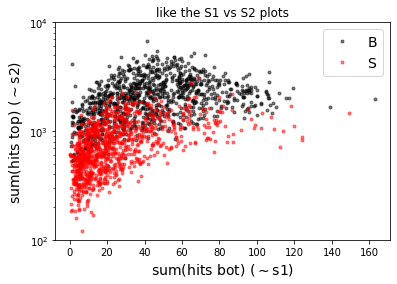

In [16]:
B_pbot = np.loadtxt(filefolder + 'ER/pbot.txt')
B_ptop = np.loadtxt(filefolder + 'ER/ptop.txt')
B_ppeakS1 = np.loadtxt(filefolder + 'ER/ppeakS1.txt')
B_ppeakS2 = np.loadtxt(filefolder + 'ER/ppeakS2.txt')

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)



S_pbot = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/pbot.txt')
S_ptop = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ptop.txt')
S_ppeakS1 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS1.txt')
S_ppeakS2 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS2.txt')

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)


# plot to check

plt.plot(B_pbot[:1000], B_ptop[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_pbot[:1000], S_ptop[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel(r'sum(hits bot) ($\sim$s1)',fontsize=14)
plt.ylabel(r'sum(hits top) ($\sim$s2)',fontsize=14)
plt.title('like the S1 vs S2 plots')
plt.legend(fontsize=14)
plt.show()

B_pbot.shape:  (15000,)
B_ptop.shape:  (15000,)
B_ppeakS1.shape : (15000, 8)
B_ppeakS2.shape:  (15000, 8)
S_pbot.shape:  (15000,)
S_ptop.shape:  (15000,)
S_ppeakS1.shape : (15000, 8)
S_ppeakS2.shape:  (15000, 8)
B_pdiffT.shape:  (15000,)
S_pdiffT.shape:  (15000,)


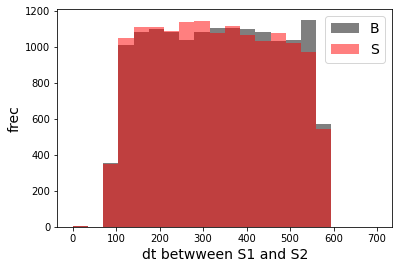

In [17]:
# to have the same number of background and signal events

B_pbot = B_pbot[:num_data]
B_ptop = B_ptop[:num_data]
B_ppeakS1 = B_ppeakS1[:num_data]
B_ppeakS2 = B_ppeakS2[:num_data]

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot[:num_data]
S_ptop = S_ptop[:num_data]
S_ppeakS1 = S_ppeakS1[:num_data]
S_ppeakS2 = S_ppeakS2[:num_data]

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)


# CONSTRUCT THE TIME DIFFERENCE BETWEEN PULSES

B_pdiffT = B_ppeakS2[:,0] - B_ppeakS1[:,0]
S_pdiffT = S_ppeakS2[:,0] - S_ppeakS1[:,0]

print('B_pdiffT.shape: ', B_pdiffT.shape)
print('S_pdiffT.shape: ', S_pdiffT.shape)


plt.hist(B_pdiffT, range=[0,700], bins=20, color='black', alpha=0.5, label='B')
plt.hist(S_pdiffT, range=[0,700], bins=20, color='red', alpha=0.5, label='S')
# plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('dt betwween S1 and S2',fontsize=14)
plt.ylabel('frec',fontsize=14)
plt.legend(fontsize=14)
plt.show()

##### Remove the absolute times of each pulse (we just need the time difference between pulses
other variables also can be removed if you want

In [18]:
remove_col = [0] # index = 0 is pT0

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (15000,)
B_ptop.shape:  (15000,)
B_ppeakS1.shape : (15000, 7)
B_ppeakS2.shape:  (15000, 7)
S_pbot.shape:  (15000,)
S_ptop.shape:  (15000,)
S_ppeakS1.shape : (15000, 7)
S_ppeakS2.shape:  (15000, 7)


In [19]:
# concatenate the data

# all the background features
# X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)

# all the signal features
# X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))
X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')

del B_ppeakS1
del B_ppeakS2
del B_pbot
del B_ptop

del S_ppeakS1
del S_ppeakS2
del S_pbot
del S_ptop


X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)
del X_mon_B
del X_mon_S


# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)

del X_mon5
del y_mon5

X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)

del X_mon5_aux
del y_mon5_aux

print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (15000, 1)
X_mon_S.shape:  (15000, 1)

X_mon5.shape:  (30000, 1)

X_mon5_train :  (15000, 1)
y_mon5_train :  (15000,)
X_mon5_val :  (5000, 1)
y_mon5_val :  (5000,)
X_mon5_test :  (10000, 1)
y_mon5_test :  (10000,)



##### Concatenate into one single big dataset (not the compressed features)

In [20]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val],axis=1)

del X_mon1_train
del X_mon2_train
del X_mon3_train
del X_mon4_train
del X_mon5_train

del X_mon1_test
del X_mon2_test
del X_mon3_test
del X_mon4_test
del X_mon5_test

del X_mon1_val
del X_mon2_val
del X_mon3_val
del X_mon4_val
del X_mon5_val



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val

del y_mon1_train
del y_mon2_train
del y_mon3_train
del y_mon4_train
del y_mon5_train

del y_mon1_test
del y_mon2_test
del y_mon3_test
del y_mon4_test
del y_mon5_test

del y_mon1_val
del y_mon2_val
del y_mon3_val
del y_mon4_val
del y_mon5_val

In [21]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (15000, 2744)
y_mon_train :  (15000,)
X_mon_val :  (5000, 2744)
y_mon_val :  (5000,)
X_mon_test :  (10000, 2744)
y_mon_test :  (10000,)



## CLASSIFIER

### 1st step: XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.64279	validation_1-logloss:0.64624
[1]	validation_0-logloss:0.59963	validation_1-logloss:0.60535
[2]	validation_0-logloss:0.56226	validation_1-logloss:0.57073
[3]	validation_0-logloss:0.52980	validation_1-logloss:0.54142
[4]	validation_0-logloss:0.50180	validation_1-logloss:0.51604
[5]	validation_0-logloss:0.47777	validation_1-logloss:0.49450
[6]	validation_0-logloss:0.45538	validation_1-logloss:0.47416
[7]	validation_0-logloss:0.43584	validation_1-logloss:0.45685
[8]	validation_0-logloss:0.41799	validation_1-logloss:0.44125
[9]	validation_0-logloss:0.40195	validation_1-logloss:0.42700
[10]	validation_0-logloss:0.38751	validation_1-logloss:0.41472
[11]	validation_0-logloss:0.37438	validation_1-logloss:0.40410
[12]	validation_0-logloss:0.36225	validation_1-logloss:0.39447
[13]	validation_0-logloss:0.35078	validation_1-logloss:0.38527
[14]	validation_0-logloss:0.33937	validation_1-logloss:0.37629
[15]	validation_0-logloss:0.32969	validation_1-logloss:0.36780
[1

[130]	validation_0-logloss:0.06535	validation_1-logloss:0.19432
[131]	validation_0-logloss:0.06496	validation_1-logloss:0.19413
[132]	validation_0-logloss:0.06442	validation_1-logloss:0.19388
[133]	validation_0-logloss:0.06379	validation_1-logloss:0.19358
[134]	validation_0-logloss:0.06337	validation_1-logloss:0.19342
[135]	validation_0-logloss:0.06253	validation_1-logloss:0.19319
[136]	validation_0-logloss:0.06214	validation_1-logloss:0.19302
[137]	validation_0-logloss:0.06139	validation_1-logloss:0.19287
[138]	validation_0-logloss:0.06077	validation_1-logloss:0.19278
[139]	validation_0-logloss:0.06026	validation_1-logloss:0.19263
[140]	validation_0-logloss:0.05986	validation_1-logloss:0.19253
[141]	validation_0-logloss:0.05950	validation_1-logloss:0.19274
[142]	validation_0-logloss:0.05919	validation_1-logloss:0.19248
[143]	validation_0-logloss:0.05880	validation_1-logloss:0.19225
[144]	validation_0-logloss:0.05824	validation_1-logloss:0.19230
[145]	validation_0-logloss:0.05781	valid

[259]	validation_0-logloss:0.02502	validation_1-logloss:0.18991
[260]	validation_0-logloss:0.02480	validation_1-logloss:0.19010
[261]	validation_0-logloss:0.02456	validation_1-logloss:0.19013
[262]	validation_0-logloss:0.02436	validation_1-logloss:0.19003
[263]	validation_0-logloss:0.02416	validation_1-logloss:0.19021
[264]	validation_0-logloss:0.02401	validation_1-logloss:0.19018
[265]	validation_0-logloss:0.02380	validation_1-logloss:0.19024
[266]	validation_0-logloss:0.02367	validation_1-logloss:0.19011
[267]	validation_0-logloss:0.02360	validation_1-logloss:0.19006
[268]	validation_0-logloss:0.02347	validation_1-logloss:0.18994
[269]	validation_0-logloss:0.02325	validation_1-logloss:0.19004
[270]	validation_0-logloss:0.02304	validation_1-logloss:0.19022
[271]	validation_0-logloss:0.02292	validation_1-logloss:0.19025
[272]	validation_0-logloss:0.02281	validation_1-logloss:0.19025
[273]	validation_0-logloss:0.02273	validation_1-logloss:0.19022
[274]	validation_0-logloss:0.02263	valid

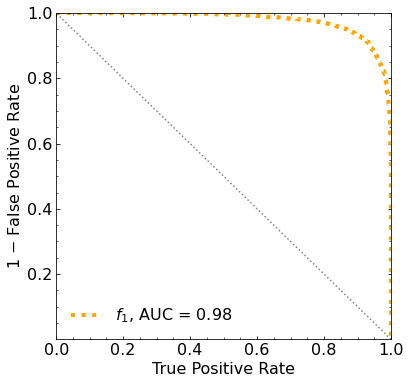

Classification score:


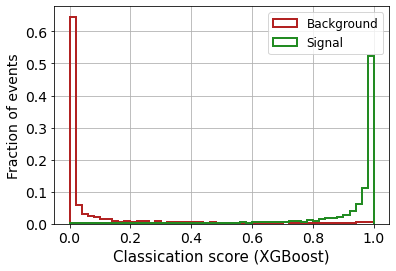


 ROC-AUC =  0.9768742426358966


In [22]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [23]:
print('\n ROC-AUC = ', roc_auc_xg)
roc_auc_only1ML = roc_auc_xg


 ROC-AUC =  0.9768742426358966


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


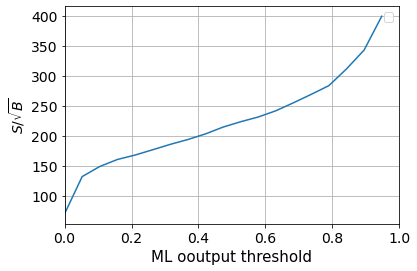

In [24]:
thresh = np.linspace(0,1,20)

B_thresh = []
S_thresh = []

for it in range(len(thresh)):

    # TEST SET #

    pred_XG_SM_test_0 = []
    pred_XG_NP_test_0 = []

    pred_XG_SM_test_1 = []
    pred_XG_NP_test_1 = []

    for i in range(len(y_mon_test)):
        if y_pred_xg[i] < thresh[it]:
            if y_mon_test[i] == 0:
                pred_XG_SM_test_0.append(y_pred_xg[i])
            else:
                pred_XG_NP_test_0.append(y_pred_xg[i])

        else:
            if y_mon_test[i] == 0:
                pred_XG_SM_test_1.append(y_pred_xg[i])
            else:
                pred_XG_NP_test_1.append(y_pred_xg[i])
                
#     print('\nthresh: ', thresh[it])
#     print('len(pred_XG_SM_test_1): ', len(pred_XG_SM_test_1))
#     print('len(pred_XG_NP_test_1): ', len(pred_XG_NP_test_1))
    B_thresh.append(len(pred_XG_SM_test_1))
    S_thresh.append(len(pred_XG_NP_test_1))

        
SsqrtB = []

for i in range(len(B_thresh)):
    if B_thresh[i] >= 3:
        SsqrtB.append( S_thresh[i]/np.sqrt(B_thresh[i]) )
    else:
        SsqrtB.append(None)


plt.plot(thresh, SsqrtB)

plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("ML ooutput threshold",fontsize=15)
plt.ylabel("$S/\sqrt{B}$",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()

ML Output threshold:  0.9

X_mon_train_0:  (7889, 2744)
y_mon_train_0:  (7889,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 447
pred_XG_SM_test_0: 4927
pred_XG_NP_test_0: 1170

X_mon_train_1:  (7111, 2744)
y_mon_train_1:  (7111,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7111
pred_XG_SM_train_1: 119
pred_XG_NP_train_1: 3784


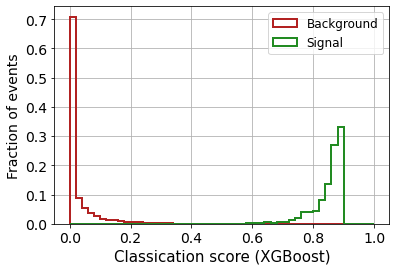

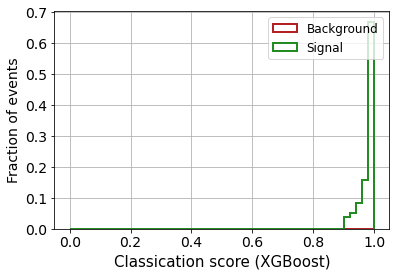

In [25]:
y_pred_xg_train = classifier.predict_proba(X_mon_train).T[1]

thresh = 0.9

print('ML Output threshold: ', thresh)


# TRAIN SET #

X_mon_train_0 = []
y_mon_train_0 = []
pred_XG_SM_train_0 = []
pred_XG_NP_train_0 = []

X_mon_train_1 = []
y_mon_train_1 = []
pred_XG_SM_train_1 = []
pred_XG_NP_train_1 = []

for i in range(len(y_mon_train)):
    if y_pred_xg_train[i] < thresh:
        X_mon_train_0.append(X_mon_train[i].tolist())
        y_mon_train_0.append(y_mon_train[i].tolist())
        
        if y_mon_train[i] == 0:
            pred_XG_SM_train_0.append(y_pred_xg_train[i])
        else:
            pred_XG_NP_train_0.append(y_pred_xg_train[i])
            
    else:
        X_mon_train_1.append(X_mon_train[i].tolist())
        y_mon_train_1.append(y_mon_train[i].tolist())
        
        if y_mon_train[i] == 0:
            pred_XG_SM_train_1.append(y_pred_xg_train[i])
        else:
            pred_XG_NP_train_1.append(y_pred_xg_train[i])
        
X_mon_train_0 = np.asarray(X_mon_train_0)
y_mon_train_0 = np.asarray(y_mon_train_0)
X_mon_train_1 = np.asarray(X_mon_train_1)
y_mon_train_1 = np.asarray(y_mon_train_1)



# TEST SET #

pred_XG_SM_test_0 = []
pred_XG_NP_test_0 = []

pred_XG_SM_test_1 = []
pred_XG_NP_test_1 = []

for i in range(len(y_mon_test)):
    if y_pred_xg[i] < thresh:
        if y_mon_test[i] == 0:
            pred_XG_SM_test_0.append(y_pred_xg[i])
        else:
            pred_XG_NP_test_0.append(y_pred_xg[i])
            
    else:
        if y_mon_test[i] == 0:
            pred_XG_SM_test_1.append(y_pred_xg[i])
        else:
            pred_XG_NP_test_1.append(y_pred_xg[i])

        
print('\nX_mon_train_0: ', X_mon_train_0.shape)
print('y_mon_train_0: ', y_mon_train_0.shape)
print('pred_XG_SM_train_0:', len(pred_XG_SM_train_0))
print('pred_XG_NP_train_0:', len(pred_XG_NP_train_0))
print('pred_XG_SM_test_0:', len(pred_XG_SM_test_0))
print('pred_XG_NP_test_0:', len(pred_XG_NP_test_0))

print('\nX_mon_train_1: ', X_mon_train_1.shape)
print('y_mon_train_1: ', y_mon_train_1.shape)
print('pred_XG_SM_train_1:', len(pred_XG_SM_train_1))
print('pred_XG_NP_train_1:', len(pred_XG_NP_train_1))
print('pred_XG_SM_train_1:', len(pred_XG_SM_test_1))
print('pred_XG_NP_train_1:', len(pred_XG_NP_test_1))



        
weights = np.ones_like(pred_XG_SM_train_0)/float(len(pred_XG_SM_train_0))
plt.hist(pred_XG_SM_train_0, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_train_0)/float(len(pred_XG_NP_train_0))
plt.hist(pred_XG_NP_train_0, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()



weights = np.ones_like(pred_XG_SM_train_1)/float(len(pred_XG_SM_train_1))
plt.hist(pred_XG_SM_train_1, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_train_1)/float(len(pred_XG_NP_train_1))
plt.hist(pred_XG_NP_train_1, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()

In [29]:
7442*2

14884

In [31]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_mon_train_0, y_mon_train_0 = oversample.fit_resample(X_mon_train_0, y_mon_train_0)

print('\nX_t: ', X_mon_train_0.shape)
print('y_t: ', y_mon_train_0.shape)
print('sum(y_t): ', sum(y_mon_train_0))
print('len(y_t)-sum(y_t): ', len(y_mon_train_0)-sum(y_mon_train_0))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff7affe0af0>
Traceback (most recent call last):
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'



X_t:  (14884, 2744)
y_t:  (14884,)
sum(y_t):  7442.0
len(y_t)-sum(y_t):  7442.0


### 2nd step: Option A
- define a threshold for the 1st ML
- keep the events that are below that threshold
- train a 2nd ML with those events
- define a threshold for the 2nd ML
- evaluate all test events in that last ML

ML Output threshold:  [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]

#################
thresh_1ML:  0.0
#################


X_mon_train_0:  (0,)
y_mon_train_0:  (0,)
pred_XG_SM_train_0: 0
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 0
pred_XG_NP_test_0: 0

X_mon_train_1:  (15000, 2744)
y_mon_train_1:  (15000,)
pred_XG_SM_train_1: 7442
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 5046
pred_XG_NP_train_1: 4954


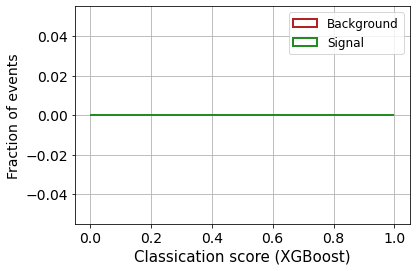

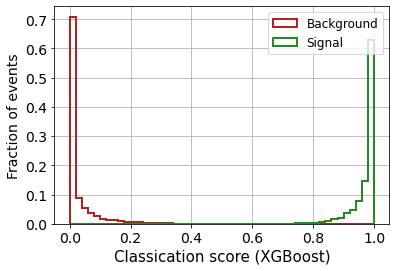


-------------------------------


#################
thresh_1ML:  0.041666666666666664
#################


X_mon_train_0:  (5967, 2744)
y_mon_train_0:  (5967,)
pred_XG_SM_train_0: 5967
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 3567
pred_XG_NP_test_0: 29

X_mon_train_1:  (9033, 2744)
y_mon_train_1:  (9033,)
pred_XG_SM_train_1: 1475
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 1479
pred_XG_NP_train_1: 4925


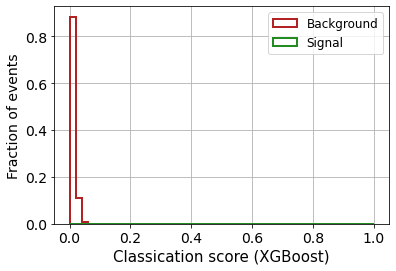

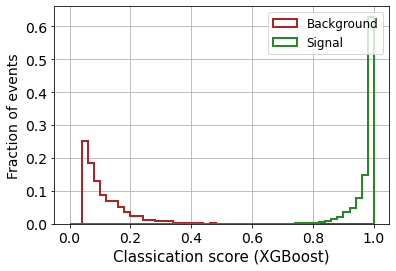


-------------------------------


#################
thresh_1ML:  0.08333333333333333
#################


X_mon_train_0:  (6648, 2744)
y_mon_train_0:  (6648,)
pred_XG_SM_train_0: 6648
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 3856
pred_XG_NP_test_0: 59

X_mon_train_1:  (8352, 2744)
y_mon_train_1:  (8352,)
pred_XG_SM_train_1: 794
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 1190
pred_XG_NP_train_1: 4895


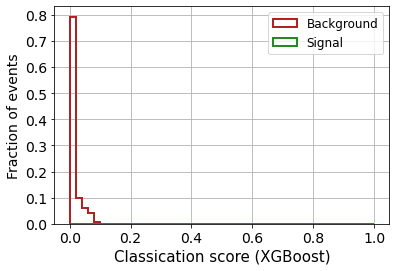

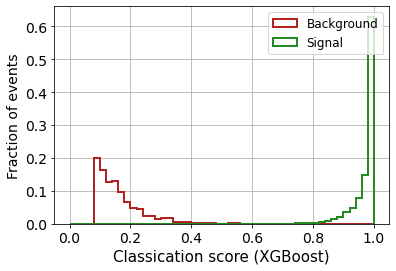


-------------------------------


#################
thresh_1ML:  0.125
#################


X_mon_train_0:  (6969, 2744)
y_mon_train_0:  (6969,)
pred_XG_SM_train_0: 6969
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4030
pred_XG_NP_test_0: 83

X_mon_train_1:  (8031, 2744)
y_mon_train_1:  (8031,)
pred_XG_SM_train_1: 473
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 1016
pred_XG_NP_train_1: 4871


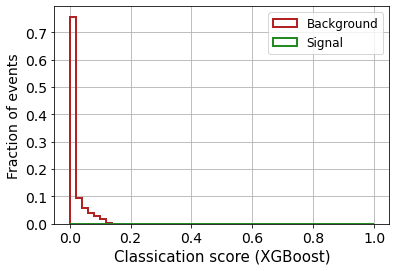

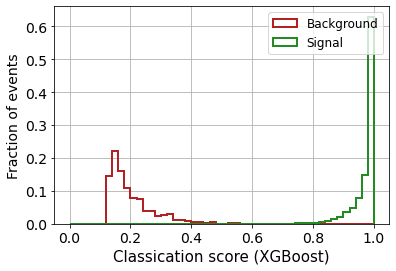


-------------------------------


#################
thresh_1ML:  0.16666666666666666
#################


X_mon_train_0:  (7162, 2744)
y_mon_train_0:  (7162,)
pred_XG_SM_train_0: 7162
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4151
pred_XG_NP_test_0: 108

X_mon_train_1:  (7838, 2744)
y_mon_train_1:  (7838,)
pred_XG_SM_train_1: 280
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 895
pred_XG_NP_train_1: 4846


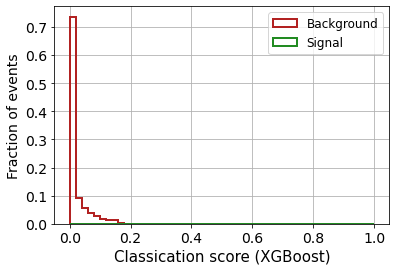

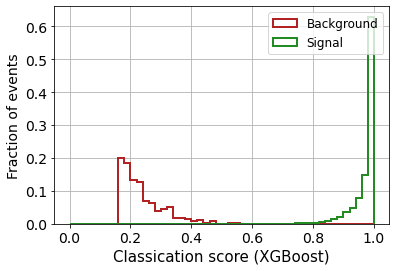


-------------------------------


#################
thresh_1ML:  0.20833333333333331
#################


X_mon_train_0:  (7289, 2744)
y_mon_train_0:  (7289,)
pred_XG_SM_train_0: 7289
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4220
pred_XG_NP_test_0: 139

X_mon_train_1:  (7711, 2744)
y_mon_train_1:  (7711,)
pred_XG_SM_train_1: 153
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 826
pred_XG_NP_train_1: 4815


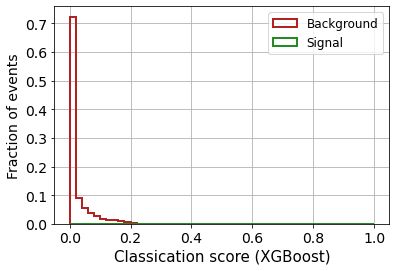

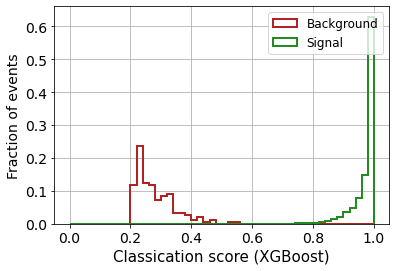


-------------------------------


#################
thresh_1ML:  0.25
#################


X_mon_train_0:  (7356, 2744)
y_mon_train_0:  (7356,)
pred_XG_SM_train_0: 7356
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4294
pred_XG_NP_test_0: 174

X_mon_train_1:  (7644, 2744)
y_mon_train_1:  (7644,)
pred_XG_SM_train_1: 86
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 752
pred_XG_NP_train_1: 4780


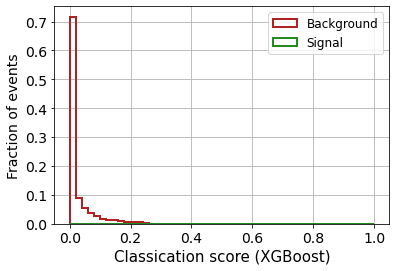

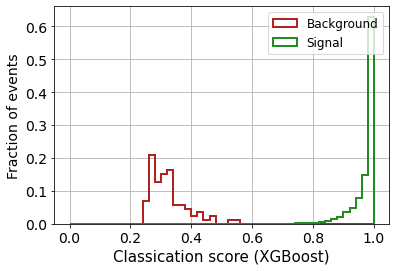


-------------------------------


#################
thresh_1ML:  0.29166666666666663
#################


X_mon_train_0:  (7389, 2744)
y_mon_train_0:  (7389,)
pred_XG_SM_train_0: 7389
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4360
pred_XG_NP_test_0: 205

X_mon_train_1:  (7611, 2744)
y_mon_train_1:  (7611,)
pred_XG_SM_train_1: 53
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 686
pred_XG_NP_train_1: 4749


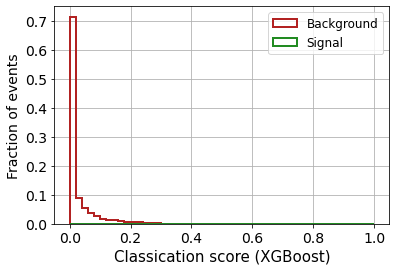

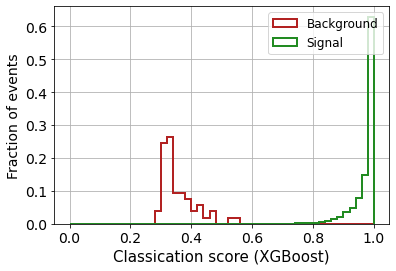


-------------------------------


#################
thresh_1ML:  0.3333333333333333
#################


X_mon_train_0:  (7414, 2744)
y_mon_train_0:  (7414,)
pred_XG_SM_train_0: 7414
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4422
pred_XG_NP_test_0: 226

X_mon_train_1:  (7586, 2744)
y_mon_train_1:  (7586,)
pred_XG_SM_train_1: 28
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 624
pred_XG_NP_train_1: 4728


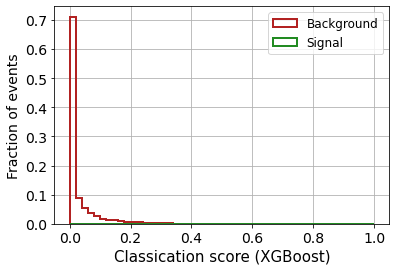

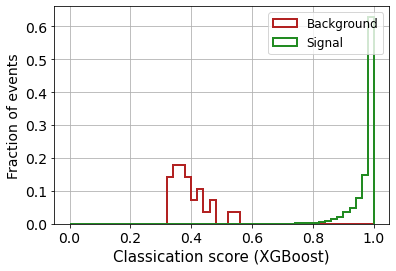


-------------------------------


#################
thresh_1ML:  0.375
#################


X_mon_train_0:  (7426, 2744)
y_mon_train_0:  (7426,)
pred_XG_SM_train_0: 7426
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4465
pred_XG_NP_test_0: 263

X_mon_train_1:  (7574, 2744)
y_mon_train_1:  (7574,)
pred_XG_SM_train_1: 16
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 581
pred_XG_NP_train_1: 4691


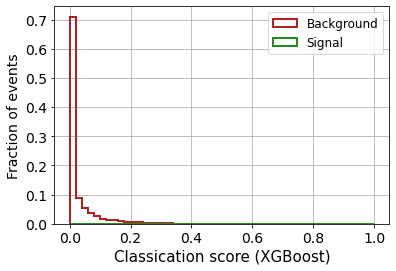

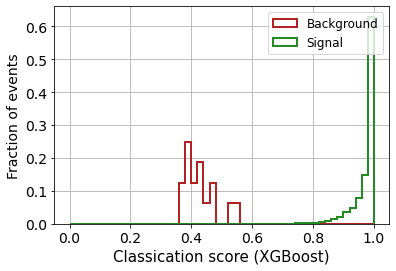


-------------------------------


#################
thresh_1ML:  0.41666666666666663
#################


X_mon_train_0:  (7434, 2744)
y_mon_train_0:  (7434,)
pred_XG_SM_train_0: 7434
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4516
pred_XG_NP_test_0: 296

X_mon_train_1:  (7566, 2744)
y_mon_train_1:  (7566,)
pred_XG_SM_train_1: 8
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 530
pred_XG_NP_train_1: 4658


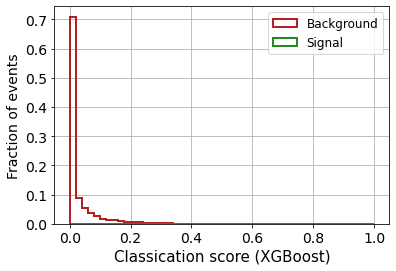

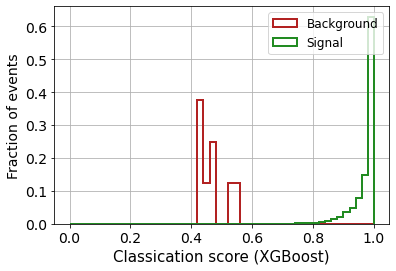


-------------------------------


#################
thresh_1ML:  0.4583333333333333
#################


X_mon_train_0:  (7438, 2744)
y_mon_train_0:  (7438,)
pred_XG_SM_train_0: 7438
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4559
pred_XG_NP_test_0: 320

X_mon_train_1:  (7562, 2744)
y_mon_train_1:  (7562,)
pred_XG_SM_train_1: 4
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 487
pred_XG_NP_train_1: 4634


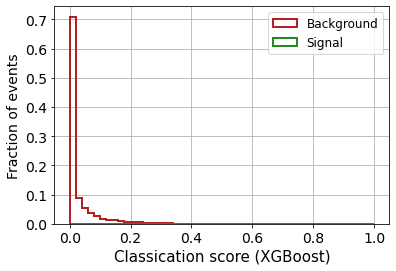

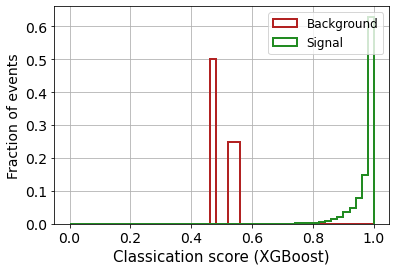


-------------------------------


#################
thresh_1ML:  0.5
#################


X_mon_train_0:  (7440, 2744)
y_mon_train_0:  (7440,)
pred_XG_SM_train_0: 7440
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4605
pred_XG_NP_test_0: 353

X_mon_train_1:  (7560, 2744)
y_mon_train_1:  (7560,)
pred_XG_SM_train_1: 2
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 441
pred_XG_NP_train_1: 4601


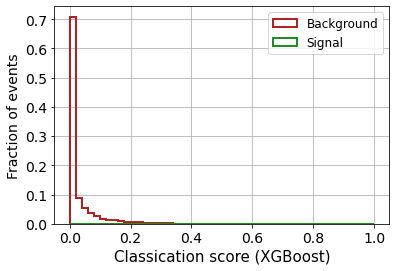

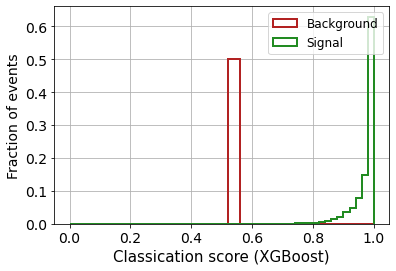


-------------------------------


#################
thresh_1ML:  0.5416666666666666
#################


X_mon_train_0:  (7442, 2744)
y_mon_train_0:  (7442,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4634
pred_XG_NP_test_0: 390

X_mon_train_1:  (7558, 2744)
y_mon_train_1:  (7558,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 412
pred_XG_NP_train_1: 4564


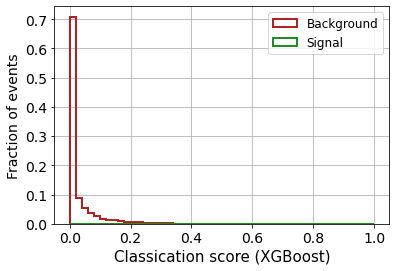

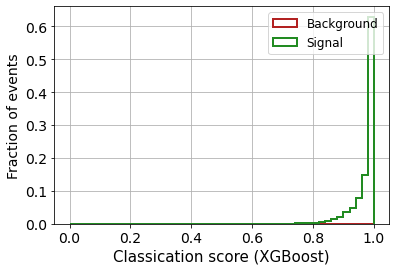


-------------------------------


#################
thresh_1ML:  0.5833333333333333
#################


X_mon_train_0:  (7442, 2744)
y_mon_train_0:  (7442,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4668
pred_XG_NP_test_0: 432

X_mon_train_1:  (7558, 2744)
y_mon_train_1:  (7558,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 378
pred_XG_NP_train_1: 4522


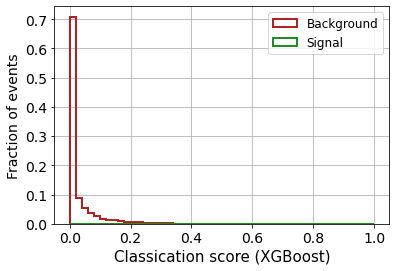

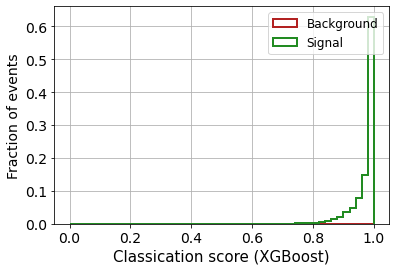


-------------------------------


#################
thresh_1ML:  0.625
#################


X_mon_train_0:  (7444, 2744)
y_mon_train_0:  (7444,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 2
pred_XG_SM_test_0: 4700
pred_XG_NP_test_0: 479

X_mon_train_1:  (7556, 2744)
y_mon_train_1:  (7556,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7556
pred_XG_SM_train_1: 346
pred_XG_NP_train_1: 4475


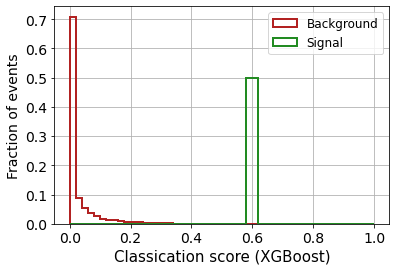

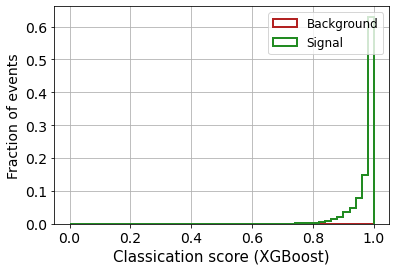

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.59822	validation_1-logloss:0.69764
[1]	validation_0-logloss:0.52047	validation_1-logloss:0.71034
[2]	validation_0-logloss:0.45564	validation_1-logloss:0.72915
[3]	validation_0-logloss:0.40084	validation_1-logloss:0.75273
[4]	validation_0-logloss:0.35402	validation_1-logloss:0.78009
[5]	validation_0-logloss:0.31369	validation_1-logloss:0.81062
[6]	validation_0-logloss:0.27871	validation_1-logloss:0.84366
[7]	validation_0-logloss:0.24821	validation_1-logloss:0.87880
[8]	validation_0-logloss:0.22148	validation_1-logloss:0.91570
[9]	validation_0-logloss:0.19796	validation_1-logloss:0.95417
[10]	validation_0-logloss:0.17719	validation_1-logloss:0.99391
[11]	validation_0-logloss:0.15881	validation_1-logloss:1.03486
[12]	validation_0-logloss:0.14250	validation_1-logloss:1.07679
[13]	validation_0-logloss:0.12799	validation_1-logloss:1.11954
[14]	validation_0-logloss:0.11506	validation_1-logloss:1.16305
[15]	validation_0-logloss:0.10351	validation_1-logloss:1.20727
[1

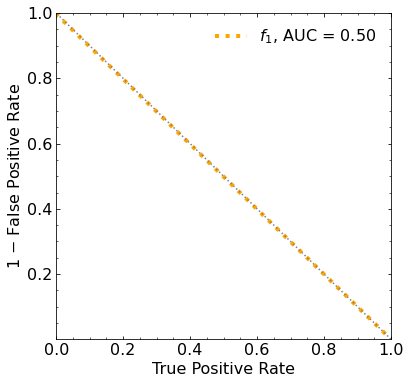

Classification score:


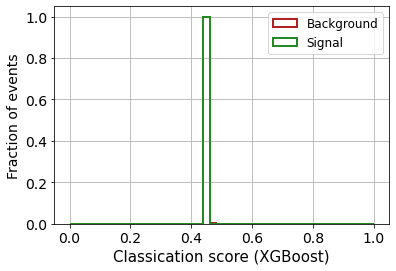


 ROC-AUC =  0.4985191946646364

-------------------------------


#################
thresh_1ML:  0.6666666666666666
#################


X_mon_train_0:  (7448, 2744)
y_mon_train_0:  (7448,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 6
pred_XG_SM_test_0: 4737
pred_XG_NP_test_0: 537

X_mon_train_1:  (7552, 2744)
y_mon_train_1:  (7552,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7552
pred_XG_SM_train_1: 309
pred_XG_NP_train_1: 4417


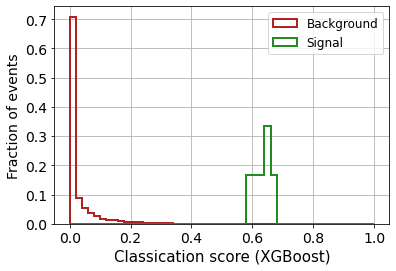

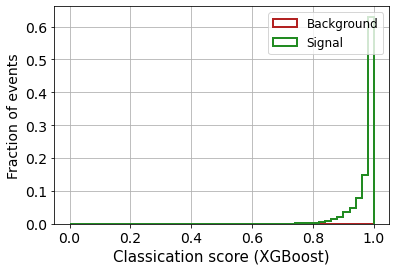

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.59839	validation_1-logloss:0.69756
[1]	validation_0-logloss:0.52080	validation_1-logloss:0.71020
[2]	validation_0-logloss:0.45609	validation_1-logloss:0.72895
[3]	validation_0-logloss:0.40140	validation_1-logloss:0.75243
[4]	validation_0-logloss:0.35468	validation_1-logloss:0.77969
[5]	validation_0-logloss:0.31444	validation_1-logloss:0.81010
[6]	validation_0-logloss:0.27954	validation_1-logloss:0.84297
[7]	validation_0-logloss:0.24910	validation_1-logloss:0.87796
[8]	validation_0-logloss:0.22243	validation_1-logloss:0.91469
[9]	validation_0-logloss:0.19897	validation_1-logloss:0.95296
[10]	validation_0-logloss:0.17826	validation_1-logloss:0.99258
[11]	validation_0-logloss:0.15993	validation_1-logloss:1.03333
[12]	validation_0-logloss:0.14366	validation_1-logloss:1.07500
[13]	validation_0-logloss:0.12912	validation_1-logloss:1.11722
[14]	validation_0-logloss:0.11617	validation_1-logloss:1.16019
[15]	validation_0-logloss:0.10461	validation_1-logloss:1.20393
[1

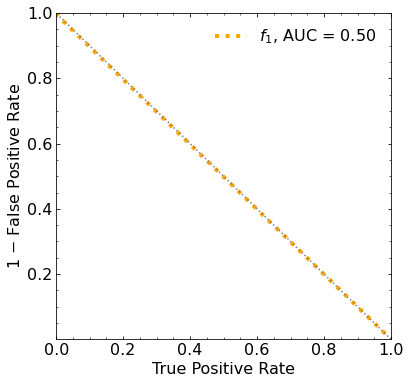

Classification score:


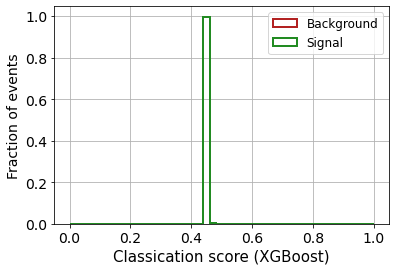


 ROC-AUC =  0.49804993494649386

-------------------------------


#################
thresh_1ML:  0.7083333333333333
#################


X_mon_train_0:  (7452, 2744)
y_mon_train_0:  (7452,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 10
pred_XG_SM_test_0: 4765
pred_XG_NP_test_0: 589

X_mon_train_1:  (7548, 2744)
y_mon_train_1:  (7548,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7548
pred_XG_SM_train_1: 281
pred_XG_NP_train_1: 4365


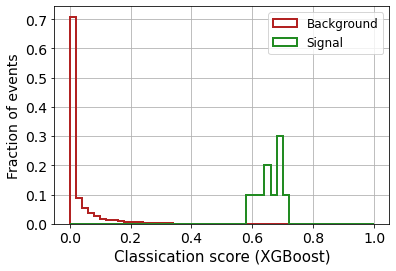

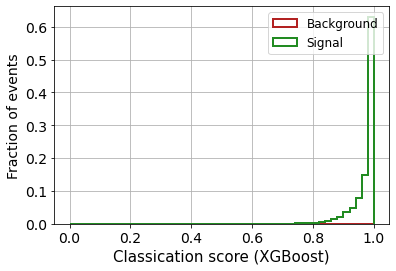

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.59859	validation_1-logloss:0.69749
[1]	validation_0-logloss:0.52115	validation_1-logloss:0.71011
[2]	validation_0-logloss:0.45658	validation_1-logloss:0.72877
[3]	validation_0-logloss:0.40201	validation_1-logloss:0.75217
[4]	validation_0-logloss:0.35540	validation_1-logloss:0.77938
[5]	validation_0-logloss:0.31525	validation_1-logloss:0.80965
[6]	validation_0-logloss:0.28044	validation_1-logloss:0.84240
[7]	validation_0-logloss:0.25009	validation_1-logloss:0.87728
[8]	validation_0-logloss:0.22349	validation_1-logloss:0.91384
[9]	validation_0-logloss:0.20010	validation_1-logloss:0.95203
[10]	validation_0-logloss:0.17947	validation_1-logloss:0.99136
[11]	validation_0-logloss:0.16120	validation_1-logloss:1.03199
[12]	validation_0-logloss:0.14500	validation_1-logloss:1.07337
[13]	validation_0-logloss:0.13052	validation_1-logloss:1.11537
[14]	validation_0-logloss:0.11763	validation_1-logloss:1.15799
[15]	validation_0-logloss:0.10612	validation_1-logloss:1.20121
[1

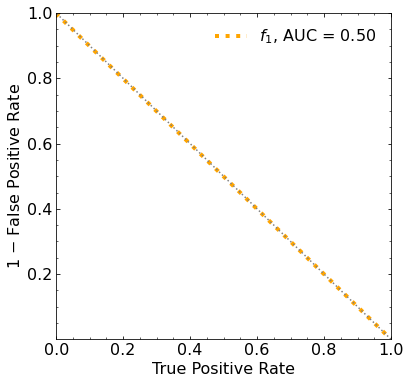

Classification score:


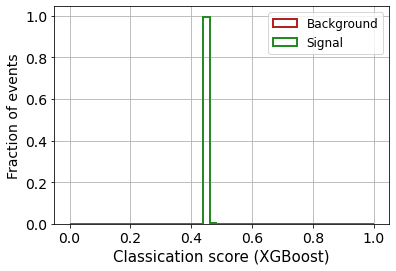


 ROC-AUC =  0.4992422558645364

-------------------------------


#################
thresh_1ML:  0.75
#################


X_mon_train_0:  (7464, 2744)
y_mon_train_0:  (7464,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 22
pred_XG_SM_test_0: 4801
pred_XG_NP_test_0: 661

X_mon_train_1:  (7536, 2744)
y_mon_train_1:  (7536,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7536
pred_XG_SM_train_1: 245
pred_XG_NP_train_1: 4293


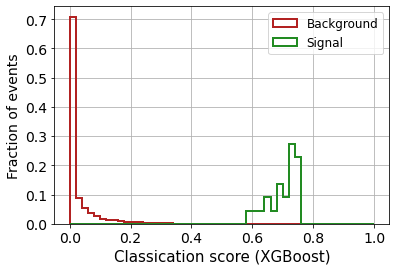

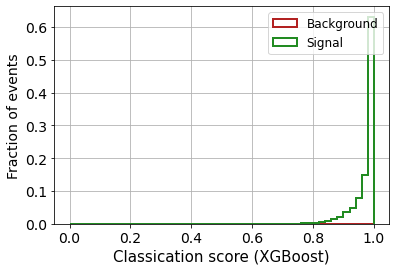

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.59920	validation_1-logloss:0.69746
[1]	validation_0-logloss:0.52226	validation_1-logloss:0.70993
[2]	validation_0-logloss:0.45812	validation_1-logloss:0.72856
[3]	validation_0-logloss:0.40392	validation_1-logloss:0.75184
[4]	validation_0-logloss:0.35764	validation_1-logloss:0.77884
[5]	validation_0-logloss:0.31781	validation_1-logloss:0.80885
[6]	validation_0-logloss:0.28327	validation_1-logloss:0.84142
[7]	validation_0-logloss:0.25315	validation_1-logloss:0.87599
[8]	validation_0-logloss:0.22674	validation_1-logloss:0.91207
[9]	validation_0-logloss:0.20352	validation_1-logloss:0.94993
[10]	validation_0-logloss:0.18307	validation_1-logloss:0.98872
[11]	validation_0-logloss:0.16498	validation_1-logloss:1.02888
[12]	validation_0-logloss:0.14892	validation_1-logloss:1.06993
[13]	validation_0-logloss:0.13465	validation_1-logloss:1.11155
[14]	validation_0-logloss:0.12187	validation_1-logloss:1.15372
[15]	validation_0-logloss:0.11049	validation_1-logloss:1.19649
[1

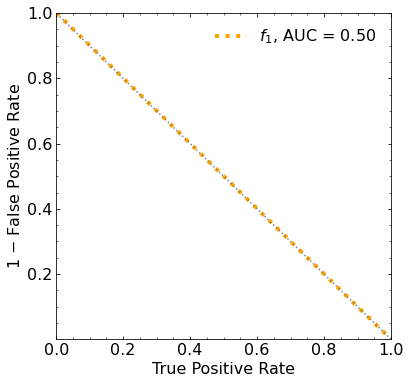

Classification score:


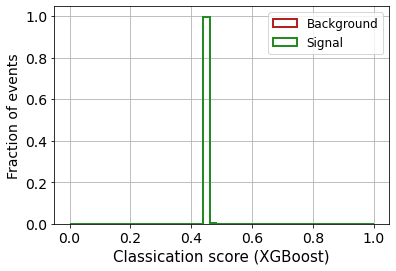


 ROC-AUC =  0.5006368539033144

-------------------------------


#################
thresh_1ML:  0.7916666666666666
#################


X_mon_train_0:  (7495, 2744)
y_mon_train_0:  (7495,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 53
pred_XG_SM_test_0: 4830
pred_XG_NP_test_0: 757

X_mon_train_1:  (7505, 2744)
y_mon_train_1:  (7505,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7505
pred_XG_SM_train_1: 216
pred_XG_NP_train_1: 4197


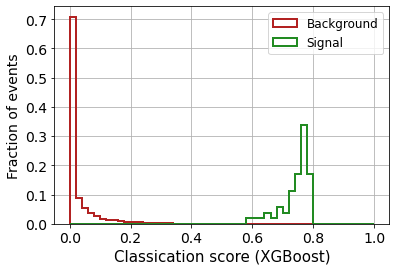

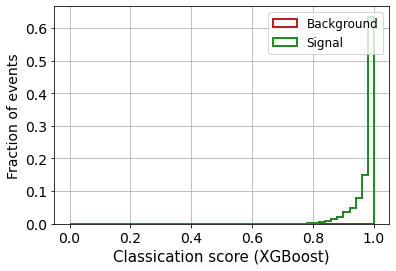

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.60055	validation_1-logloss:0.69712
[1]	validation_0-logloss:0.52474	validation_1-logloss:0.70913
[2]	validation_0-logloss:0.46154	validation_1-logloss:0.72683
[3]	validation_0-logloss:0.40816	validation_1-logloss:0.74949
[4]	validation_0-logloss:0.36257	validation_1-logloss:0.77563
[5]	validation_0-logloss:0.32337	validation_1-logloss:0.80444
[6]	validation_0-logloss:0.28940	validation_1-logloss:0.83595
[7]	validation_0-logloss:0.25965	validation_1-logloss:0.86880
[8]	validation_0-logloss:0.23355	validation_1-logloss:0.90348
[9]	validation_0-logloss:0.21075	validation_1-logloss:0.93899
[10]	validation_0-logloss:0.19076	validation_1-logloss:0.97635
[11]	validation_0-logloss:0.17263	validation_1-logloss:1.01451
[12]	validation_0-logloss:0.15658	validation_1-logloss:1.05324
[13]	validation_0-logloss:0.14268	validation_1-logloss:1.09268
[14]	validation_0-logloss:0.12981	validation_1-logloss:1.13265
[15]	validation_0-logloss:0.11813	validation_1-logloss:1.17253
[1

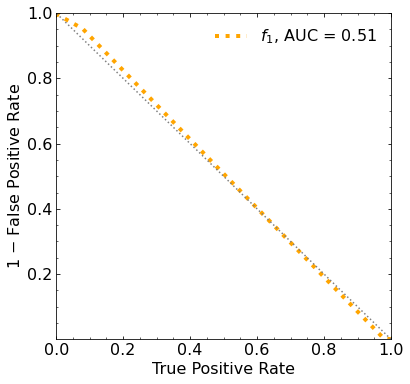

Classification score:


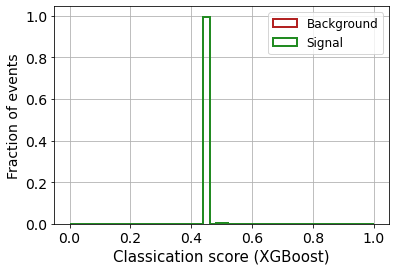


 ROC-AUC =  0.5063865605584856

-------------------------------


#################
thresh_1ML:  0.8333333333333333
#################


X_mon_train_0:  (7548, 2744)
y_mon_train_0:  (7548,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 106
pred_XG_SM_test_0: 4867
pred_XG_NP_test_0: 878

X_mon_train_1:  (7452, 2744)
y_mon_train_1:  (7452,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7452
pred_XG_SM_train_1: 179
pred_XG_NP_train_1: 4076


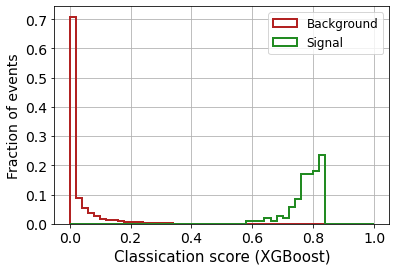

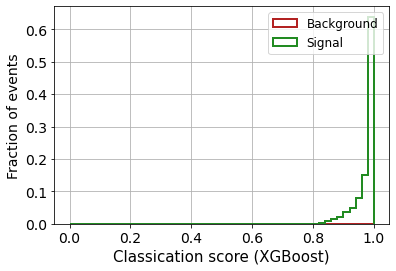

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.60295	validation_1-logloss:0.69564
[1]	validation_0-logloss:0.52900	validation_1-logloss:0.70535
[2]	validation_0-logloss:0.46755	validation_1-logloss:0.72167
[3]	validation_0-logloss:0.41534	validation_1-logloss:0.74146
[4]	validation_0-logloss:0.37100	validation_1-logloss:0.76480
[5]	validation_0-logloss:0.33301	validation_1-logloss:0.79135
[6]	validation_0-logloss:0.29983	validation_1-logloss:0.81932
[7]	validation_0-logloss:0.27064	validation_1-logloss:0.84916
[8]	validation_0-logloss:0.24529	validation_1-logloss:0.88014
[9]	validation_0-logloss:0.22313	validation_1-logloss:0.90882
[10]	validation_0-logloss:0.20341	validation_1-logloss:0.94190
[11]	validation_0-logloss:0.18631	validation_1-logloss:0.97398
[12]	validation_0-logloss:0.17109	validation_1-logloss:1.00790
[13]	validation_0-logloss:0.15751	validation_1-logloss:1.04235
[14]	validation_0-logloss:0.14558	validation_1-logloss:1.07447
[15]	validation_0-logloss:0.13441	validation_1-logloss:1.10857
[1

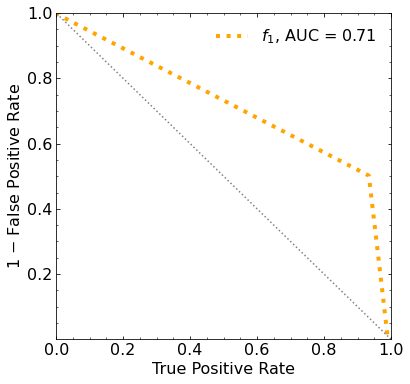

Classification score:


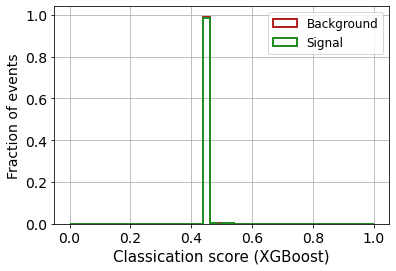


 ROC-AUC =  0.7146610489111799

-------------------------------


#################
thresh_1ML:  0.875
#################


X_mon_train_0:  (7708, 2744)
y_mon_train_0:  (7708,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 266
pred_XG_SM_test_0: 4908
pred_XG_NP_test_0: 1046

X_mon_train_1:  (7292, 2744)
y_mon_train_1:  (7292,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7292
pred_XG_SM_train_1: 138
pred_XG_NP_train_1: 3908


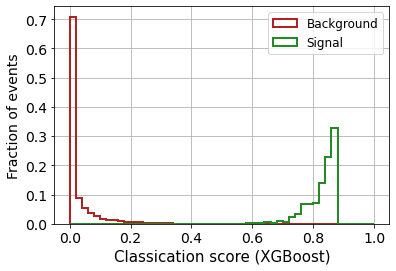

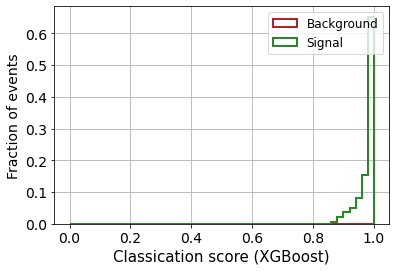

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.60958	validation_1-logloss:0.69172
[1]	validation_0-logloss:0.54110	validation_1-logloss:0.69717
[2]	validation_0-logloss:0.48419	validation_1-logloss:0.70762
[3]	validation_0-logloss:0.43583	validation_1-logloss:0.71941
[4]	validation_0-logloss:0.39501	validation_1-logloss:0.73573
[5]	validation_0-logloss:0.35957	validation_1-logloss:0.75325
[6]	validation_0-logloss:0.32942	validation_1-logloss:0.77383
[7]	validation_0-logloss:0.30284	validation_1-logloss:0.79539
[8]	validation_0-logloss:0.27998	validation_1-logloss:0.81534
[9]	validation_0-logloss:0.25992	validation_1-logloss:0.83774
[10]	validation_0-logloss:0.24161	validation_1-logloss:0.85997
[11]	validation_0-logloss:0.22584	validation_1-logloss:0.88160
[12]	validation_0-logloss:0.21187	validation_1-logloss:0.90312
[13]	validation_0-logloss:0.19895	validation_1-logloss:0.92221
[14]	validation_0-logloss:0.18790	validation_1-logloss:0.94151
[15]	validation_0-logloss:0.17833	validation_1-logloss:0.96221
[1

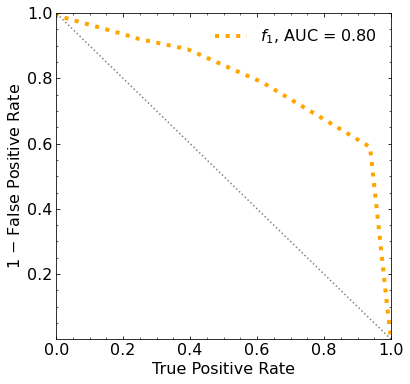

Classification score:


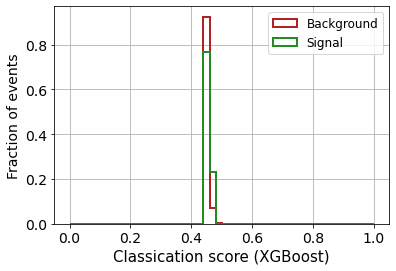


 ROC-AUC =  0.7952006457826591

-------------------------------


#################
thresh_1ML:  0.9166666666666666
#################


X_mon_train_0:  (8121, 2744)
y_mon_train_0:  (8121,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 679
pred_XG_SM_test_0: 4944
pred_XG_NP_test_0: 1282

X_mon_train_1:  (6879, 2744)
y_mon_train_1:  (6879,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 6879
pred_XG_SM_train_1: 102
pred_XG_NP_train_1: 3672


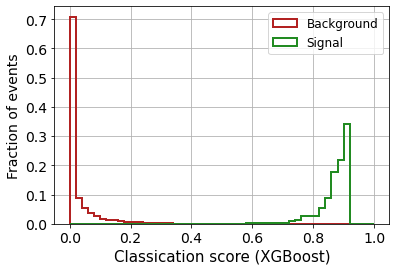

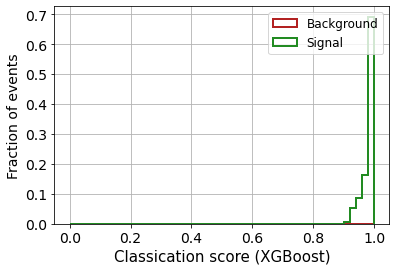

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.62277	validation_1-logloss:0.68326
[1]	validation_0-logloss:0.56459	validation_1-logloss:0.67852
[2]	validation_0-logloss:0.51597	validation_1-logloss:0.67499
[3]	validation_0-logloss:0.47484	validation_1-logloss:0.67608
[4]	validation_0-logloss:0.43994	validation_1-logloss:0.67941
[5]	validation_0-logloss:0.40985	validation_1-logloss:0.68419
[6]	validation_0-logloss:0.38341	validation_1-logloss:0.68810
[7]	validation_0-logloss:0.36112	validation_1-logloss:0.69429
[8]	validation_0-logloss:0.34131	validation_1-logloss:0.69936
[9]	validation_0-logloss:0.32450	validation_1-logloss:0.70738
[10]	validation_0-logloss:0.30891	validation_1-logloss:0.71283
[11]	validation_0-logloss:0.29514	validation_1-logloss:0.71830
[12]	validation_0-logloss:0.28313	validation_1-logloss:0.72428
[13]	validation_0-logloss:0.27224	validation_1-logloss:0.73044
[14]	validation_0-logloss:0.26262	validation_1-logloss:0.73720
[15]	validation_0-logloss:0.25382	validation_1-logloss:0.74178
[1

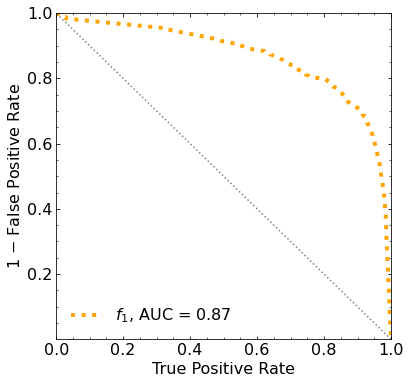

Classification score:


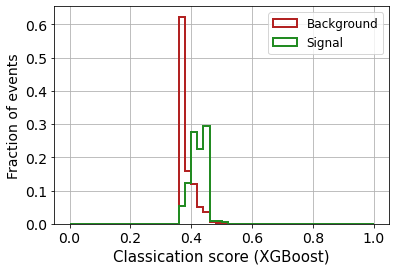


 ROC-AUC =  0.8668567707570767

-------------------------------


#################
thresh_1ML:  0.9583333333333333
#################


X_mon_train_0:  (9054, 2744)
y_mon_train_0:  (9054,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 1612
pred_XG_SM_test_0: 4986
pred_XG_NP_test_0: 1784

X_mon_train_1:  (5946, 2744)
y_mon_train_1:  (5946,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 5946
pred_XG_SM_train_1: 60
pred_XG_NP_train_1: 3170


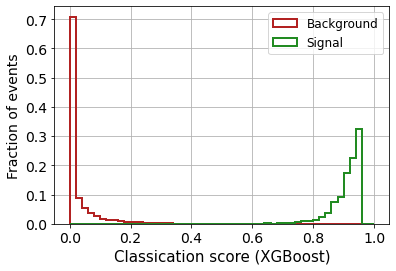

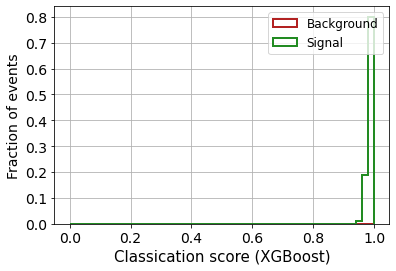

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.64143	validation_1-logloss:0.67068
[1]	validation_0-logloss:0.59813	validation_1-logloss:0.65091
[2]	validation_0-logloss:0.56086	validation_1-logloss:0.63464
[3]	validation_0-logloss:0.52909	validation_1-logloss:0.62170
[4]	validation_0-logloss:0.50238	validation_1-logloss:0.61129
[5]	validation_0-logloss:0.47831	validation_1-logloss:0.60072
[6]	validation_0-logloss:0.45732	validation_1-logloss:0.59085
[7]	validation_0-logloss:0.43867	validation_1-logloss:0.58382
[8]	validation_0-logloss:0.42242	validation_1-logloss:0.57775
[9]	validation_0-logloss:0.40778	validation_1-logloss:0.57182
[10]	validation_0-logloss:0.39407	validation_1-logloss:0.56574
[11]	validation_0-logloss:0.38204	validation_1-logloss:0.55953
[12]	validation_0-logloss:0.37048	validation_1-logloss:0.55308
[13]	validation_0-logloss:0.36046	validation_1-logloss:0.54598
[14]	validation_0-logloss:0.35115	validation_1-logloss:0.54015
[15]	validation_0-logloss:0.34226	validation_1-logloss:0.53455
[1

[130]	validation_0-logloss:0.09474	validation_1-logloss:0.31716
[131]	validation_0-logloss:0.09441	validation_1-logloss:0.31718
[132]	validation_0-logloss:0.09394	validation_1-logloss:0.31712
[133]	validation_0-logloss:0.09320	validation_1-logloss:0.31617
[134]	validation_0-logloss:0.09231	validation_1-logloss:0.31462
[135]	validation_0-logloss:0.09178	validation_1-logloss:0.31428
[136]	validation_0-logloss:0.09149	validation_1-logloss:0.31378
[137]	validation_0-logloss:0.09109	validation_1-logloss:0.31382
[138]	validation_0-logloss:0.09026	validation_1-logloss:0.31281
[139]	validation_0-logloss:0.08922	validation_1-logloss:0.31225
[140]	validation_0-logloss:0.08887	validation_1-logloss:0.31237
[141]	validation_0-logloss:0.08783	validation_1-logloss:0.31201
[142]	validation_0-logloss:0.08724	validation_1-logloss:0.31238
[143]	validation_0-logloss:0.08625	validation_1-logloss:0.31197
[144]	validation_0-logloss:0.08572	validation_1-logloss:0.31205
[145]	validation_0-logloss:0.08487	valid

[259]	validation_0-logloss:0.03734	validation_1-logloss:0.28474
[260]	validation_0-logloss:0.03726	validation_1-logloss:0.28483
[261]	validation_0-logloss:0.03682	validation_1-logloss:0.28479
[262]	validation_0-logloss:0.03654	validation_1-logloss:0.28474
[263]	validation_0-logloss:0.03633	validation_1-logloss:0.28466
[264]	validation_0-logloss:0.03615	validation_1-logloss:0.28452
[265]	validation_0-logloss:0.03604	validation_1-logloss:0.28417
[266]	validation_0-logloss:0.03563	validation_1-logloss:0.28333
[267]	validation_0-logloss:0.03541	validation_1-logloss:0.28309
[268]	validation_0-logloss:0.03522	validation_1-logloss:0.28370
[269]	validation_0-logloss:0.03494	validation_1-logloss:0.28342
[270]	validation_0-logloss:0.03450	validation_1-logloss:0.28269
[271]	validation_0-logloss:0.03428	validation_1-logloss:0.28295
[272]	validation_0-logloss:0.03414	validation_1-logloss:0.28323
[273]	validation_0-logloss:0.03403	validation_1-logloss:0.28368
[274]	validation_0-logloss:0.03393	valid

[388]	validation_0-logloss:0.01688	validation_1-logloss:0.27426
[389]	validation_0-logloss:0.01685	validation_1-logloss:0.27424
[390]	validation_0-logloss:0.01681	validation_1-logloss:0.27431
[391]	validation_0-logloss:0.01675	validation_1-logloss:0.27412
[392]	validation_0-logloss:0.01661	validation_1-logloss:0.27415
[393]	validation_0-logloss:0.01649	validation_1-logloss:0.27450
[394]	validation_0-logloss:0.01641	validation_1-logloss:0.27433
[395]	validation_0-logloss:0.01636	validation_1-logloss:0.27442
[396]	validation_0-logloss:0.01628	validation_1-logloss:0.27411
[397]	validation_0-logloss:0.01621	validation_1-logloss:0.27409
[398]	validation_0-logloss:0.01614	validation_1-logloss:0.27433
[399]	validation_0-logloss:0.01603	validation_1-logloss:0.27420
[400]	validation_0-logloss:0.01592	validation_1-logloss:0.27396
[401]	validation_0-logloss:0.01579	validation_1-logloss:0.27350
[402]	validation_0-logloss:0.01571	validation_1-logloss:0.27358
[403]	validation_0-logloss:0.01560	valid

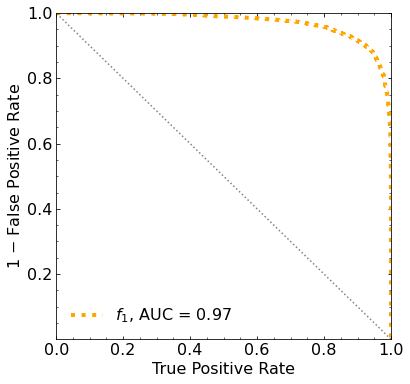

Classification score:


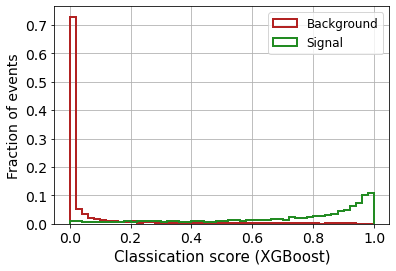


 ROC-AUC =  0.9706495157750151

-------------------------------


#################
thresh_1ML:  1.0
#################


X_mon_train_0:  (15000, 2744)
y_mon_train_0:  (15000,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 7558
pred_XG_SM_test_0: 5046
pred_XG_NP_test_0: 4954

X_mon_train_1:  (0,)
y_mon_train_1:  (0,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 0
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 0


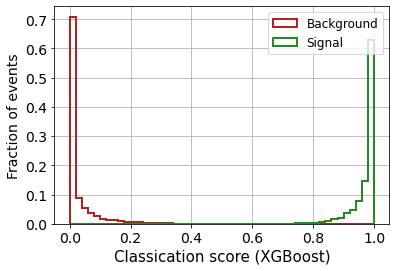

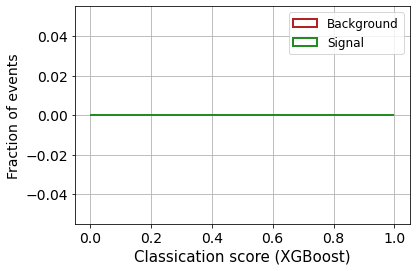

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.64279	validation_1-logloss:0.64624
[1]	validation_0-logloss:0.59963	validation_1-logloss:0.60535
[2]	validation_0-logloss:0.56226	validation_1-logloss:0.57073
[3]	validation_0-logloss:0.52980	validation_1-logloss:0.54142
[4]	validation_0-logloss:0.50180	validation_1-logloss:0.51604
[5]	validation_0-logloss:0.47777	validation_1-logloss:0.49450
[6]	validation_0-logloss:0.45538	validation_1-logloss:0.47416
[7]	validation_0-logloss:0.43584	validation_1-logloss:0.45685
[8]	validation_0-logloss:0.41799	validation_1-logloss:0.44125
[9]	validation_0-logloss:0.40195	validation_1-logloss:0.42700
[10]	validation_0-logloss:0.38751	validation_1-logloss:0.41472
[11]	validation_0-logloss:0.37438	validation_1-logloss:0.40410
[12]	validation_0-logloss:0.36225	validation_1-logloss:0.39447
[13]	validation_0-logloss:0.35078	validation_1-logloss:0.38526
[14]	validation_0-logloss:0.33937	validation_1-logloss:0.37629
[15]	validation_0-logloss:0.32969	validation_1-logloss:0.36780
[1

[130]	validation_0-logloss:0.06535	validation_1-logloss:0.19432
[131]	validation_0-logloss:0.06496	validation_1-logloss:0.19413
[132]	validation_0-logloss:0.06442	validation_1-logloss:0.19388
[133]	validation_0-logloss:0.06379	validation_1-logloss:0.19358
[134]	validation_0-logloss:0.06337	validation_1-logloss:0.19342
[135]	validation_0-logloss:0.06253	validation_1-logloss:0.19319
[136]	validation_0-logloss:0.06214	validation_1-logloss:0.19302
[137]	validation_0-logloss:0.06139	validation_1-logloss:0.19287
[138]	validation_0-logloss:0.06077	validation_1-logloss:0.19278
[139]	validation_0-logloss:0.06026	validation_1-logloss:0.19263
[140]	validation_0-logloss:0.05986	validation_1-logloss:0.19253
[141]	validation_0-logloss:0.05950	validation_1-logloss:0.19274
[142]	validation_0-logloss:0.05919	validation_1-logloss:0.19248
[143]	validation_0-logloss:0.05880	validation_1-logloss:0.19225
[144]	validation_0-logloss:0.05824	validation_1-logloss:0.19230
[145]	validation_0-logloss:0.05781	valid

[259]	validation_0-logloss:0.02502	validation_1-logloss:0.18991
[260]	validation_0-logloss:0.02480	validation_1-logloss:0.19010
[261]	validation_0-logloss:0.02456	validation_1-logloss:0.19013
[262]	validation_0-logloss:0.02436	validation_1-logloss:0.19003
[263]	validation_0-logloss:0.02416	validation_1-logloss:0.19021
[264]	validation_0-logloss:0.02401	validation_1-logloss:0.19018
[265]	validation_0-logloss:0.02380	validation_1-logloss:0.19024
[266]	validation_0-logloss:0.02367	validation_1-logloss:0.19011
[267]	validation_0-logloss:0.02360	validation_1-logloss:0.19006
[268]	validation_0-logloss:0.02347	validation_1-logloss:0.18994
[269]	validation_0-logloss:0.02325	validation_1-logloss:0.19004
[270]	validation_0-logloss:0.02304	validation_1-logloss:0.19022
[271]	validation_0-logloss:0.02292	validation_1-logloss:0.19025
[272]	validation_0-logloss:0.02281	validation_1-logloss:0.19025
[273]	validation_0-logloss:0.02273	validation_1-logloss:0.19022
[274]	validation_0-logloss:0.02263	valid

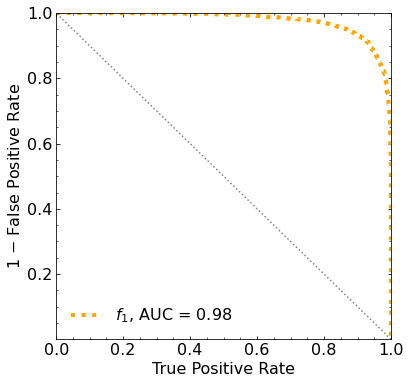

Classification score:


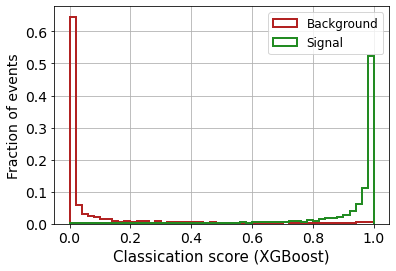


 ROC-AUC =  0.9768742426358966

-------------------------------



In [139]:
y_pred_xg_train = classifier.predict_proba(X_mon_train).T[1]

thresh_1ML = np.linspace(0,1,25)

print('ML Output threshold: ', thresh_1ML)


save_SsqrtB_2ML = []
save_auc = []

for it_1ML in range(len(thresh_1ML)):
    
    print('\n#################')
    print('thresh_1ML: ', thresh_1ML[it_1ML])
    print('#################\n')
    
    # TRAIN SET #

    X_mon_train_0 = []
    y_mon_train_0 = []
    pred_XG_SM_train_0 = []
    pred_XG_NP_train_0 = []

    X_mon_train_1 = []
    y_mon_train_1 = []
    pred_XG_SM_train_1 = []
    pred_XG_NP_train_1 = []

    for i in range(len(y_mon_train)):
        if y_pred_xg_train[i] < thresh_1ML[it_1ML]:
            X_mon_train_0.append(X_mon_train[i].tolist())
            y_mon_train_0.append(int(y_mon_train[i].tolist()))

            if y_mon_train[i] == 0:
                pred_XG_SM_train_0.append(y_pred_xg_train[i])
            else:
                pred_XG_NP_train_0.append(y_pred_xg_train[i])

        else:
            X_mon_train_1.append(X_mon_train[i].tolist())
            y_mon_train_1.append(int(y_mon_train[i].tolist()))

            if y_mon_train[i] == 0:
                pred_XG_SM_train_1.append(y_pred_xg_train[i])
            else:
                pred_XG_NP_train_1.append(y_pred_xg_train[i])

    X_mon_train_0 = np.asarray(X_mon_train_0)
    y_mon_train_0 = np.asarray(y_mon_train_0)
    X_mon_train_1 = np.asarray(X_mon_train_1)
    y_mon_train_1 = np.asarray(y_mon_train_1)



    # TEST SET #

    pred_XG_SM_test_0 = []
    pred_XG_NP_test_0 = []

    pred_XG_SM_test_1 = []
    pred_XG_NP_test_1 = []

    for i in range(len(y_mon_test)):
        if y_pred_xg[i] < thresh_1ML[it_1ML]:
            if y_mon_test[i] == 0:
                pred_XG_SM_test_0.append(y_pred_xg[i])
            else:
                pred_XG_NP_test_0.append(y_pred_xg[i])

        else:
            if y_mon_test[i] == 0:
                pred_XG_SM_test_1.append(y_pred_xg[i])
            else:
                pred_XG_NP_test_1.append(y_pred_xg[i])


    print('\nX_mon_train_0: ', X_mon_train_0.shape)
    print('y_mon_train_0: ', y_mon_train_0.shape)
    print('pred_XG_SM_train_0:', len(pred_XG_SM_train_0))
    print('pred_XG_NP_train_0:', len(pred_XG_NP_train_0))
    print('pred_XG_SM_test_0:', len(pred_XG_SM_test_0))
    print('pred_XG_NP_test_0:', len(pred_XG_NP_test_0))

    print('\nX_mon_train_1: ', X_mon_train_1.shape)
    print('y_mon_train_1: ', y_mon_train_1.shape)
    print('pred_XG_SM_train_1:', len(pred_XG_SM_train_1))
    print('pred_XG_NP_train_1:', len(pred_XG_NP_train_1))
    print('pred_XG_SM_train_1:', len(pred_XG_SM_test_1))
    print('pred_XG_NP_train_1:', len(pred_XG_NP_test_1))




    weights = np.ones_like(pred_XG_SM_train_0)/float(len(pred_XG_SM_train_0))
    plt.hist(pred_XG_SM_train_0, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

    weights = np.ones_like(pred_XG_NP_train_0)/float(len(pred_XG_NP_train_0))
    plt.hist(pred_XG_NP_train_0, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Classication score (XGBoost)",fontsize=15)
    plt.ylabel("Fraction of events",fontsize=14)
    plt.grid()
    plt.legend(fontsize=12)

    plt.show()



    weights = np.ones_like(pred_XG_SM_train_1)/float(len(pred_XG_SM_train_1))
    plt.hist(pred_XG_SM_train_1, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

    weights = np.ones_like(pred_XG_NP_train_1)/float(len(pred_XG_NP_train_1))
    plt.hist(pred_XG_NP_train_1, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Classication score (XGBoost)",fontsize=15)
    plt.ylabel("Fraction of events",fontsize=14)
    plt.grid()
    plt.legend(fontsize=12)

    plt.show()
    
    
    
    if len(pred_XG_SM_train_0) > 0 and len(pred_XG_NP_train_0) > 0:


        # CLASSIFIER #


        # XGBoost with only the kinematic variables of the leptons

        # CLASSIFIER
        classifier_2ML = XGBClassifier(
            n_estimators=1500,
            learning_rate=0.1,
            reg_lambda=0.0,reg_alpha=0.0,
            gamma=0.0,objective='binary:logistic',
            max_depth=5,
            #eval_metric=["error", "logloss", "map"]
            eval_metric='logloss')

        # FIT
        classifier_2ML.fit(X_mon_train_0,y_mon_train_0,eval_set=[(X_mon_train_0, y_mon_train_0), (X_mon_val, y_mon_val)],
                early_stopping_rounds=50,#early stopping
                verbose=True)


        # PREDICTIONS
        y_pred_xg_2ML = classifier_2ML.predict_proba(X_mon_test).T[1]


        # ROC
        fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg_2ML)
        roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)
        
        save_auc.append( roc_auc_xg )


        # PLOT THE ROC WITH AUC
        fig = plt.figure(figsize=(6, 6))
        gs = gridspec.GridSpec(1, 1) 
        ax0 = plt.subplot(gs[0])
        ax0.yaxis.set_ticks_position('both')
        ax0.xaxis.set_ticks_position('both')
        ax0.tick_params(direction="in",which="both")
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        ax0.minorticks_on()


        plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
        plt.plot([1,0],[0,1],ls=":",color="grey")
        plt.xlabel("True Positive Rate",fontsize=16)
        plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
        plt.legend()
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.yticks([0.2,0.4,0.6,0.8,1.])
        plt.legend(frameon=False,fontsize=16)
        plt.show()



        # XGBoost with the kinematic variables of the leptons

        ########################
        # CLASSIFICATION SCORE #
        ########################

        # Outputs for validation data set

        pred_XG_SM = []
        pred_XG_NP = []

        for i in range(len(y_mon_test)):
            if y_mon_test[i] == 0:
                pred_XG_SM.append(y_pred_xg_2ML[i])
            else:
                pred_XG_NP.append(y_pred_xg_2ML[i])


        print('Classification score:')

        weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
        nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

        weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
        nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Classication score (XGBoost)",fontsize=15)
        plt.ylabel("Fraction of events",fontsize=14)
        plt.grid()
        plt.legend(fontsize=12)

        plt.show()




        print('\n ROC-AUC = ', roc_auc_xg)




        thresh_2ML = np.linspace(0,1,20)

        B_thresh = []
        S_thresh = []

        for it_2ML in range(len(thresh_2ML)):

            # TEST SET #

            pred_XG_SM_test_0 = []
            pred_XG_NP_test_0 = []

            pred_XG_SM_test_1 = []
            pred_XG_NP_test_1 = []

            for i in range(len(y_mon_test)):
                if y_pred_xg_2ML[i] < thresh_2ML[it_2ML]:
                    if y_mon_test[i] == 0:
                        pred_XG_SM_test_0.append(y_pred_xg_2ML[i])
                    else:
                        pred_XG_NP_test_0.append(y_pred_xg_2ML[i])

                else:
                    if y_mon_test[i] == 0:
                        pred_XG_SM_test_1.append(y_pred_xg_2ML[i])
                    else:
                        pred_XG_NP_test_1.append(y_pred_xg_2ML[i])

#             print('\nthresh: ', thresh_2ML[it_2ML])
    #         print('len(pred_XG_SM_test_1): ', len(pred_XG_SM_test_1))
    #         print('len(pred_XG_NP_test_1): ', len(pred_XG_NP_test_1))
            B_thresh.append(len(pred_XG_SM_test_1))
            S_thresh.append(len(pred_XG_NP_test_1))


        SsqrtB_2ML = []

        for i in range(len(B_thresh)):
            if B_thresh[i] >= 3:
                SsqrtB_2ML.append( S_thresh[i]/np.sqrt(B_thresh[i]) )
            else:
                SsqrtB_2ML.append(None)


        save_SsqrtB_2ML.append(SsqrtB_2ML)
        
        
        
    else:
        
        SsqrtB_2ML = []
        for it_2ML in range(20):
            SsqrtB_2ML.append(None)
            
            
        save_SsqrtB_2ML.append(SsqrtB_2ML)
        save_auc.append( None )
        
    
    
    print('\n-------------------------------\n')

roc_auc_only1ML:  0.9768742426358966


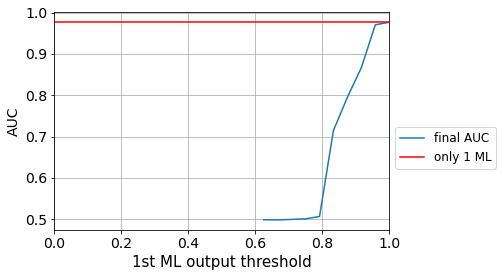

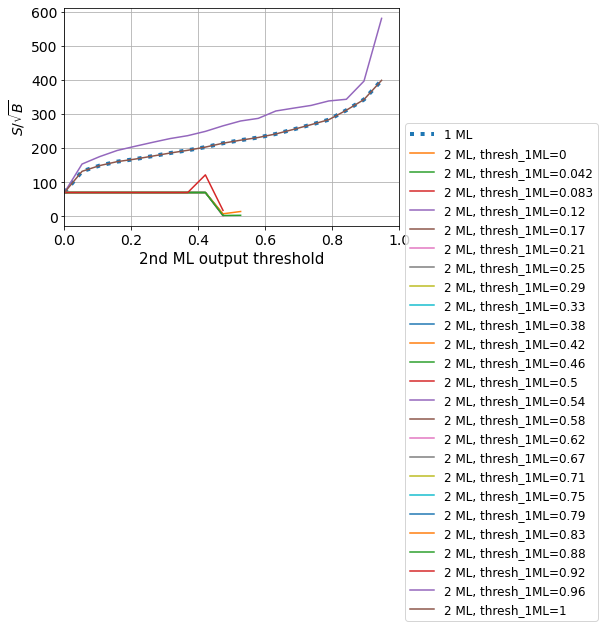

In [140]:
print('roc_auc_only1ML: ', roc_auc_only1ML)


plt.plot(thresh_1ML, save_auc, label='final AUC')

plt.axhline(y=roc_auc_only1ML, c='red', label='only 1 ML')
plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("1st ML output threshold",fontsize=15)
plt.ylabel("AUC",fontsize=14)
plt.grid()
plt.legend(fontsize=12, bbox_to_anchor=(1, 0.5))

plt.show()




plt.plot(thresh, SsqrtB, ':', lw=4, label='1 ML')
for i in range(len(thresh_1ML)):
    plt.plot(thresh_2ML, save_SsqrtB_2ML[i], label='2 ML, thresh_1ML=%.2g' % thresh_1ML[i])

plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("2nd ML output threshold",fontsize=15)
plt.ylabel("$S/\sqrt{B}$",fontsize=14)
plt.grid()
plt.legend(fontsize=12, bbox_to_anchor=(1, 0.5))

plt.show()

#### 2nd step: Option B
- define a threshold for the 1st ML
- evaluate the TEST set, and keep as result part 1 the ones that are above the threshold
- keep the TRAIN events that are below that threshold
- train a 2nd ML with those events
- define a threshold for the 2nd ML
- evaluate the remaining TEST events in that last ML as result part 2

ML Output threshold:  [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]

#################
thresh_1ML:  0.0
#################


X_mon_train_0:  (0,)
y_mon_train_0:  (0,)
pred_XG_SM_train_0: 0
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 0
pred_XG_NP_test_0: 0

X_mon_train_1:  (15000, 2744)
y_mon_train_1:  (15000,)
pred_XG_SM_train_1: 7442
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 5046
pred_XG_NP_train_1: 4954


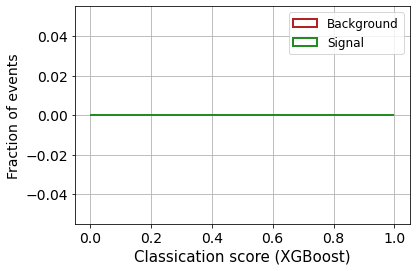

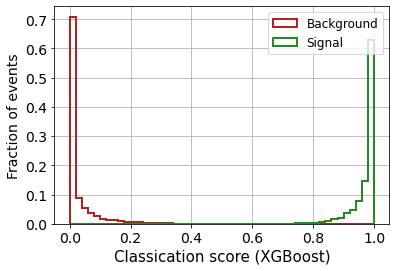


-------------------------------


#################
thresh_1ML:  0.041666666666666664
#################


X_mon_train_0:  (5967, 2744)
y_mon_train_0:  (5967,)
pred_XG_SM_train_0: 5967
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 3567
pred_XG_NP_test_0: 29

X_mon_train_1:  (9033, 2744)
y_mon_train_1:  (9033,)
pred_XG_SM_train_1: 1475
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 1479
pred_XG_NP_train_1: 4925


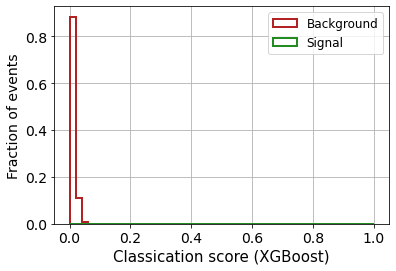

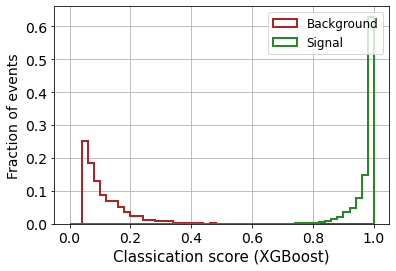


-------------------------------


#################
thresh_1ML:  0.08333333333333333
#################


X_mon_train_0:  (6648, 2744)
y_mon_train_0:  (6648,)
pred_XG_SM_train_0: 6648
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 3856
pred_XG_NP_test_0: 59

X_mon_train_1:  (8352, 2744)
y_mon_train_1:  (8352,)
pred_XG_SM_train_1: 794
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 1190
pred_XG_NP_train_1: 4895


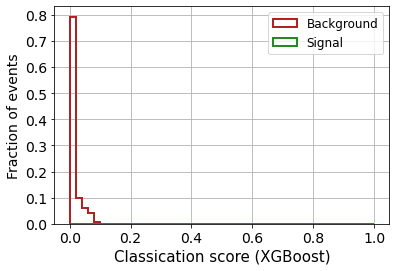

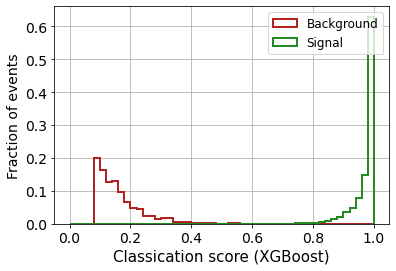


-------------------------------


#################
thresh_1ML:  0.125
#################


X_mon_train_0:  (6969, 2744)
y_mon_train_0:  (6969,)
pred_XG_SM_train_0: 6969
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4030
pred_XG_NP_test_0: 83

X_mon_train_1:  (8031, 2744)
y_mon_train_1:  (8031,)
pred_XG_SM_train_1: 473
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 1016
pred_XG_NP_train_1: 4871


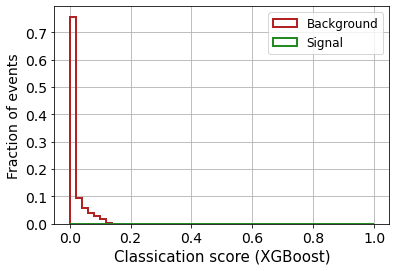

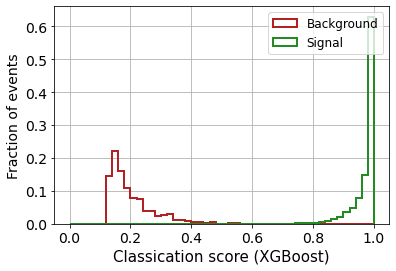


-------------------------------


#################
thresh_1ML:  0.16666666666666666
#################


X_mon_train_0:  (7162, 2744)
y_mon_train_0:  (7162,)
pred_XG_SM_train_0: 7162
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4151
pred_XG_NP_test_0: 108

X_mon_train_1:  (7838, 2744)
y_mon_train_1:  (7838,)
pred_XG_SM_train_1: 280
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 895
pred_XG_NP_train_1: 4846


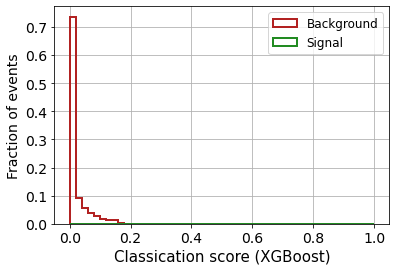

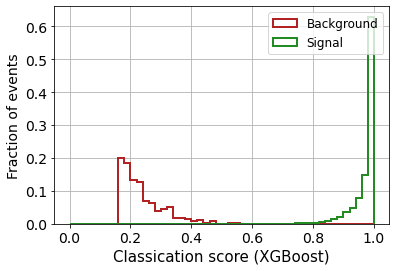


-------------------------------


#################
thresh_1ML:  0.20833333333333331
#################


X_mon_train_0:  (7289, 2744)
y_mon_train_0:  (7289,)
pred_XG_SM_train_0: 7289
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4220
pred_XG_NP_test_0: 139

X_mon_train_1:  (7711, 2744)
y_mon_train_1:  (7711,)
pred_XG_SM_train_1: 153
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 826
pred_XG_NP_train_1: 4815


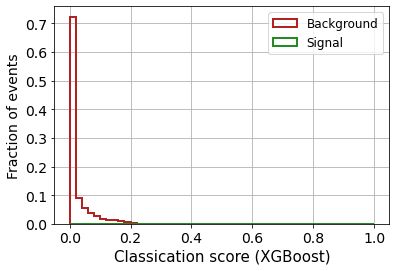

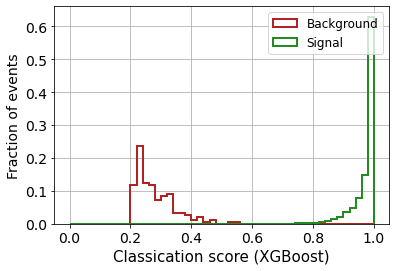


-------------------------------


#################
thresh_1ML:  0.25
#################


X_mon_train_0:  (7356, 2744)
y_mon_train_0:  (7356,)
pred_XG_SM_train_0: 7356
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4294
pred_XG_NP_test_0: 174

X_mon_train_1:  (7644, 2744)
y_mon_train_1:  (7644,)
pred_XG_SM_train_1: 86
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 752
pred_XG_NP_train_1: 4780


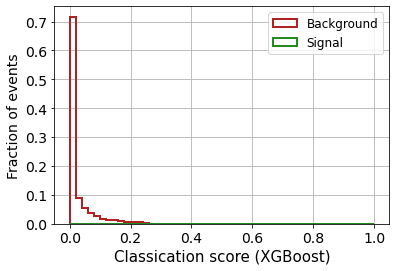

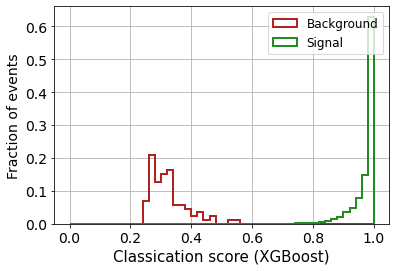


-------------------------------


#################
thresh_1ML:  0.29166666666666663
#################


X_mon_train_0:  (7389, 2744)
y_mon_train_0:  (7389,)
pred_XG_SM_train_0: 7389
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4360
pred_XG_NP_test_0: 205

X_mon_train_1:  (7611, 2744)
y_mon_train_1:  (7611,)
pred_XG_SM_train_1: 53
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 686
pred_XG_NP_train_1: 4749


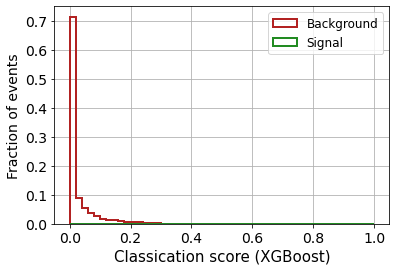

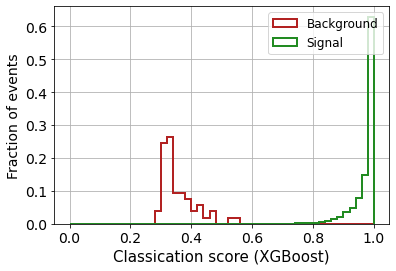


-------------------------------


#################
thresh_1ML:  0.3333333333333333
#################


X_mon_train_0:  (7414, 2744)
y_mon_train_0:  (7414,)
pred_XG_SM_train_0: 7414
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4422
pred_XG_NP_test_0: 226

X_mon_train_1:  (7586, 2744)
y_mon_train_1:  (7586,)
pred_XG_SM_train_1: 28
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 624
pred_XG_NP_train_1: 4728


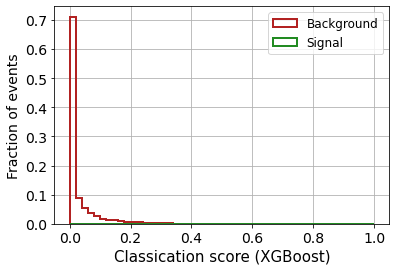

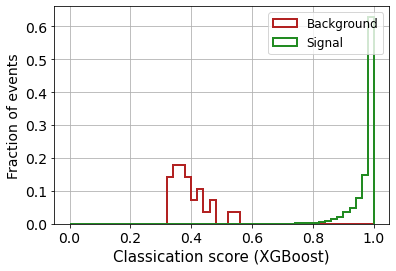


-------------------------------


#################
thresh_1ML:  0.375
#################


X_mon_train_0:  (7426, 2744)
y_mon_train_0:  (7426,)
pred_XG_SM_train_0: 7426
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4465
pred_XG_NP_test_0: 263

X_mon_train_1:  (7574, 2744)
y_mon_train_1:  (7574,)
pred_XG_SM_train_1: 16
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 581
pred_XG_NP_train_1: 4691


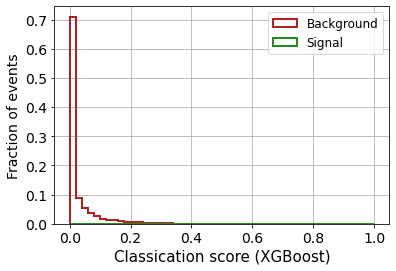

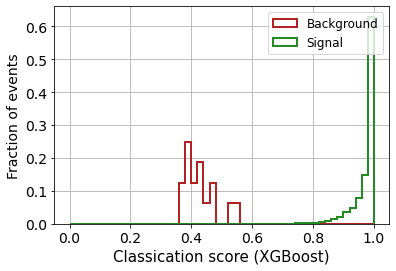


-------------------------------


#################
thresh_1ML:  0.41666666666666663
#################


X_mon_train_0:  (7434, 2744)
y_mon_train_0:  (7434,)
pred_XG_SM_train_0: 7434
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4516
pred_XG_NP_test_0: 296

X_mon_train_1:  (7566, 2744)
y_mon_train_1:  (7566,)
pred_XG_SM_train_1: 8
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 530
pred_XG_NP_train_1: 4658


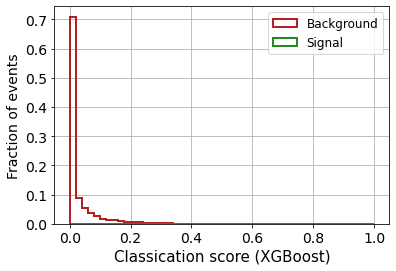

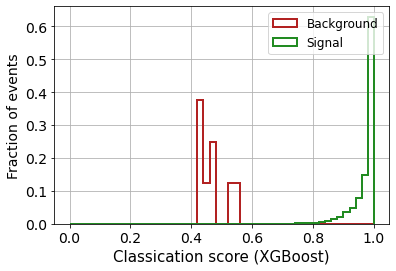


-------------------------------


#################
thresh_1ML:  0.4583333333333333
#################


X_mon_train_0:  (7438, 2744)
y_mon_train_0:  (7438,)
pred_XG_SM_train_0: 7438
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4559
pred_XG_NP_test_0: 320

X_mon_train_1:  (7562, 2744)
y_mon_train_1:  (7562,)
pred_XG_SM_train_1: 4
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 487
pred_XG_NP_train_1: 4634


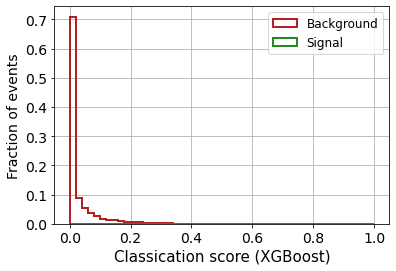

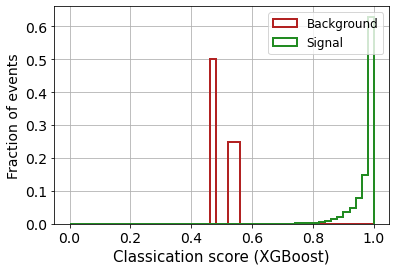


-------------------------------


#################
thresh_1ML:  0.5
#################


X_mon_train_0:  (7440, 2744)
y_mon_train_0:  (7440,)
pred_XG_SM_train_0: 7440
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4605
pred_XG_NP_test_0: 353

X_mon_train_1:  (7560, 2744)
y_mon_train_1:  (7560,)
pred_XG_SM_train_1: 2
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 441
pred_XG_NP_train_1: 4601


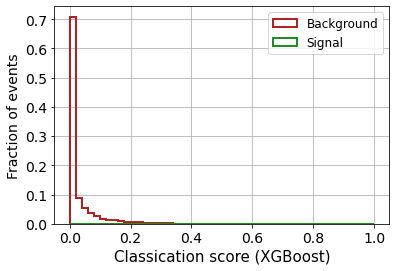

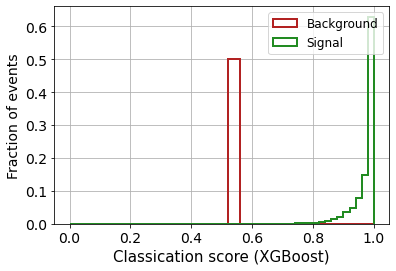


-------------------------------


#################
thresh_1ML:  0.5416666666666666
#################


X_mon_train_0:  (7442, 2744)
y_mon_train_0:  (7442,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4634
pred_XG_NP_test_0: 390

X_mon_train_1:  (7558, 2744)
y_mon_train_1:  (7558,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 412
pred_XG_NP_train_1: 4564


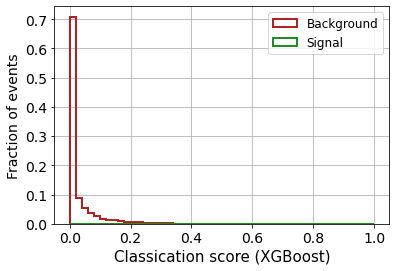

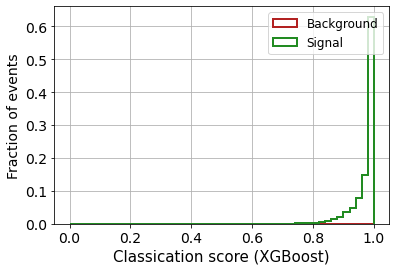


-------------------------------


#################
thresh_1ML:  0.5833333333333333
#################


X_mon_train_0:  (7442, 2744)
y_mon_train_0:  (7442,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4668
pred_XG_NP_test_0: 432

X_mon_train_1:  (7558, 2744)
y_mon_train_1:  (7558,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 378
pred_XG_NP_train_1: 4522


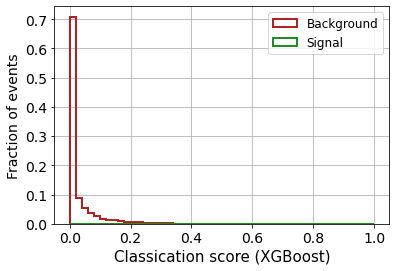

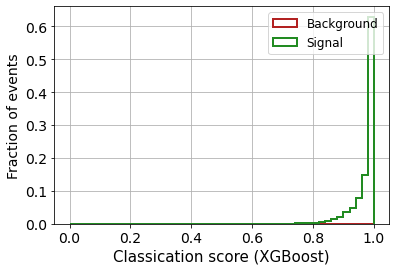


-------------------------------


#################
thresh_1ML:  0.625
#################


X_mon_train_0:  (7444, 2744)
y_mon_train_0:  (7444,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 2
pred_XG_SM_test_0: 4700
pred_XG_NP_test_0: 479

X_mon_train_1:  (7556, 2744)
y_mon_train_1:  (7556,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7556
pred_XG_SM_train_1: 346
pred_XG_NP_train_1: 4475


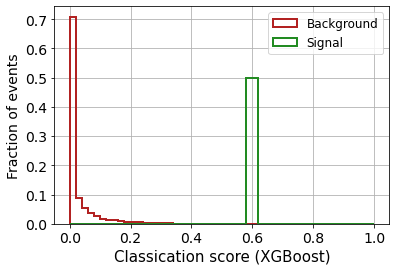

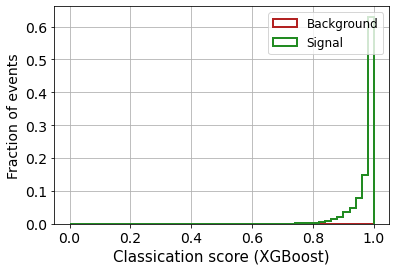

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.59822	validation_1-logloss:0.69764
[1]	validation_0-logloss:0.52047	validation_1-logloss:0.71034
[2]	validation_0-logloss:0.45564	validation_1-logloss:0.72915
[3]	validation_0-logloss:0.40084	validation_1-logloss:0.75273
[4]	validation_0-logloss:0.35402	validation_1-logloss:0.78009
[5]	validation_0-logloss:0.31369	validation_1-logloss:0.81062
[6]	validation_0-logloss:0.27871	validation_1-logloss:0.84366
[7]	validation_0-logloss:0.24821	validation_1-logloss:0.87880
[8]	validation_0-logloss:0.22148	validation_1-logloss:0.91570
[9]	validation_0-logloss:0.19796	validation_1-logloss:0.95417
[10]	validation_0-logloss:0.17719	validation_1-logloss:0.99391
[11]	validation_0-logloss:0.15881	validation_1-logloss:1.03486
[12]	validation_0-logloss:0.14250	validation_1-logloss:1.07679
[13]	validation_0-logloss:0.12799	validation_1-logloss:1.11954
[14]	validation_0-logloss:0.11506	validation_1-logloss:1.16305
[15]	validation_0-logloss:0.10351	validation_1-logloss:1.20727
[1

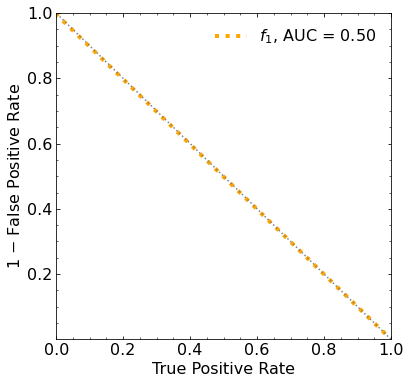


 ROC-AUC =  0.49829787234042555

final roc: 


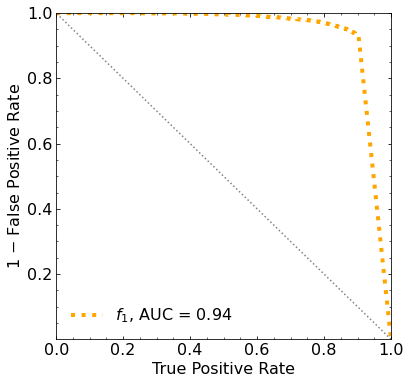


 ROC-AUC =  0.939005197399908
Classification score:


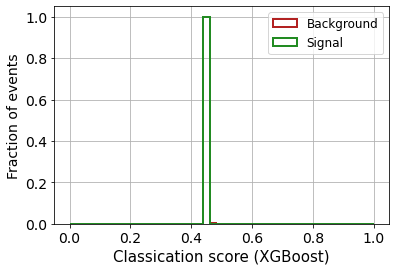


-------------------------------


#################
thresh_1ML:  0.6666666666666666
#################


X_mon_train_0:  (7448, 2744)
y_mon_train_0:  (7448,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 6
pred_XG_SM_test_0: 4737
pred_XG_NP_test_0: 537

X_mon_train_1:  (7552, 2744)
y_mon_train_1:  (7552,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7552
pred_XG_SM_train_1: 309
pred_XG_NP_train_1: 4417


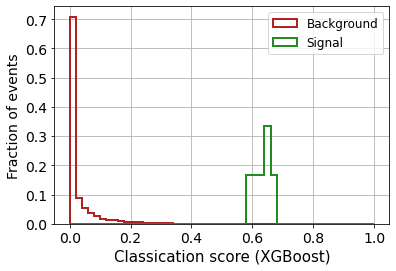

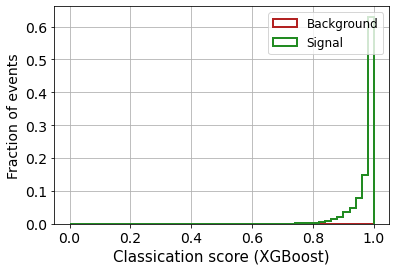

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.59839	validation_1-logloss:0.69756
[1]	validation_0-logloss:0.52080	validation_1-logloss:0.71020
[2]	validation_0-logloss:0.45609	validation_1-logloss:0.72895
[3]	validation_0-logloss:0.40140	validation_1-logloss:0.75243
[4]	validation_0-logloss:0.35468	validation_1-logloss:0.77969
[5]	validation_0-logloss:0.31444	validation_1-logloss:0.81010
[6]	validation_0-logloss:0.27954	validation_1-logloss:0.84297
[7]	validation_0-logloss:0.24910	validation_1-logloss:0.87796
[8]	validation_0-logloss:0.22243	validation_1-logloss:0.91469
[9]	validation_0-logloss:0.19897	validation_1-logloss:0.95296
[10]	validation_0-logloss:0.17826	validation_1-logloss:0.99258
[11]	validation_0-logloss:0.15993	validation_1-logloss:1.03333
[12]	validation_0-logloss:0.14366	validation_1-logloss:1.07500
[13]	validation_0-logloss:0.12912	validation_1-logloss:1.11722
[14]	validation_0-logloss:0.11617	validation_1-logloss:1.16019
[15]	validation_0-logloss:0.10461	validation_1-logloss:1.20393
[1

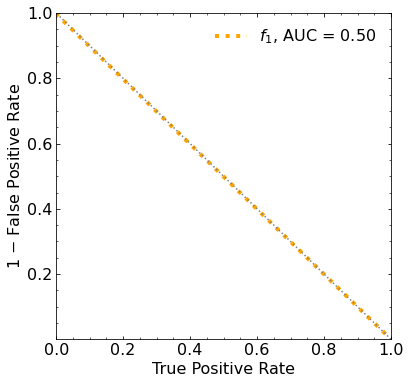


 ROC-AUC =  0.49858988768241147

final roc: 


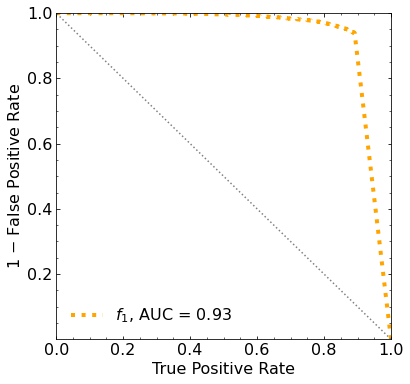


 ROC-AUC =  0.9339267875632994
Classification score:


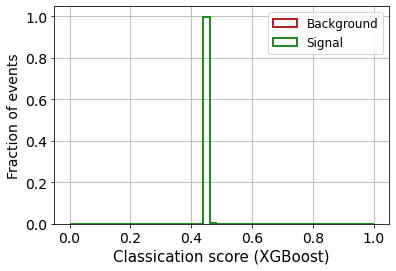


-------------------------------


#################
thresh_1ML:  0.7083333333333333
#################


X_mon_train_0:  (7452, 2744)
y_mon_train_0:  (7452,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 10
pred_XG_SM_test_0: 4765
pred_XG_NP_test_0: 589

X_mon_train_1:  (7548, 2744)
y_mon_train_1:  (7548,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7548
pred_XG_SM_train_1: 281
pred_XG_NP_train_1: 4365


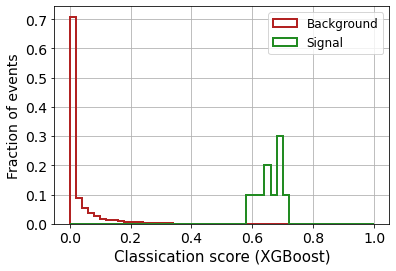

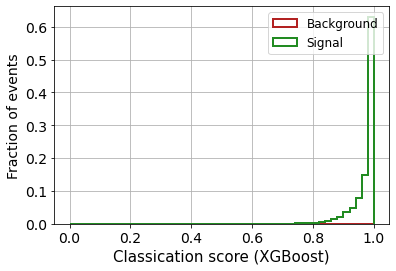

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.59859	validation_1-logloss:0.69749
[1]	validation_0-logloss:0.52115	validation_1-logloss:0.71011
[2]	validation_0-logloss:0.45658	validation_1-logloss:0.72877
[3]	validation_0-logloss:0.40201	validation_1-logloss:0.75217
[4]	validation_0-logloss:0.35540	validation_1-logloss:0.77938
[5]	validation_0-logloss:0.31525	validation_1-logloss:0.80965
[6]	validation_0-logloss:0.28044	validation_1-logloss:0.84240
[7]	validation_0-logloss:0.25009	validation_1-logloss:0.87728
[8]	validation_0-logloss:0.22349	validation_1-logloss:0.91384
[9]	validation_0-logloss:0.20010	validation_1-logloss:0.95203
[10]	validation_0-logloss:0.17947	validation_1-logloss:0.99136
[11]	validation_0-logloss:0.16120	validation_1-logloss:1.03199
[12]	validation_0-logloss:0.14500	validation_1-logloss:1.07337
[13]	validation_0-logloss:0.13052	validation_1-logloss:1.11537
[14]	validation_0-logloss:0.11763	validation_1-logloss:1.15799
[15]	validation_0-logloss:0.10612	validation_1-logloss:1.20121
[1

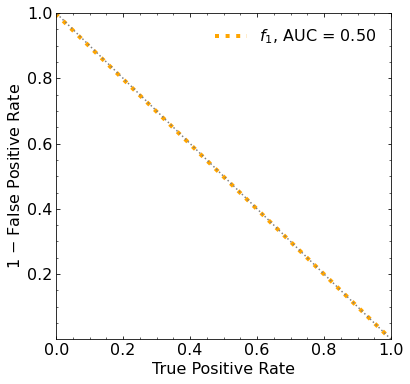


 ROC-AUC =  0.49843546516496023

final roc: 


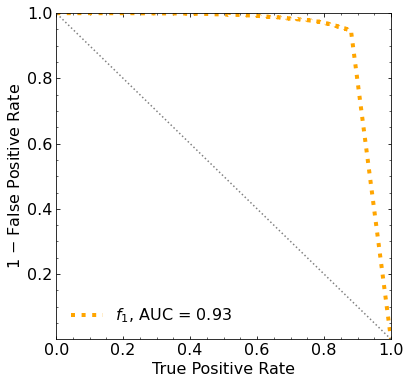


 ROC-AUC =  0.9292693933614541
Classification score:


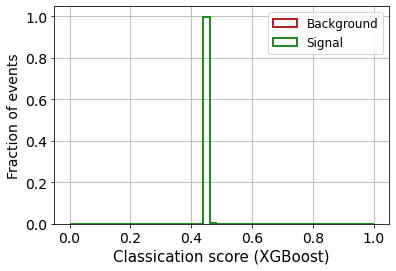


-------------------------------


#################
thresh_1ML:  0.75
#################


X_mon_train_0:  (7464, 2744)
y_mon_train_0:  (7464,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 22
pred_XG_SM_test_0: 4801
pred_XG_NP_test_0: 661

X_mon_train_1:  (7536, 2744)
y_mon_train_1:  (7536,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7536
pred_XG_SM_train_1: 245
pred_XG_NP_train_1: 4293


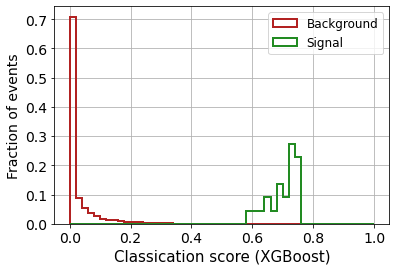

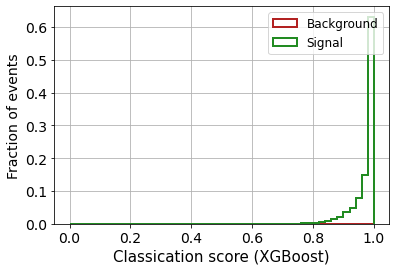

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.59920	validation_1-logloss:0.69746
[1]	validation_0-logloss:0.52226	validation_1-logloss:0.70993
[2]	validation_0-logloss:0.45812	validation_1-logloss:0.72856
[3]	validation_0-logloss:0.40392	validation_1-logloss:0.75184
[4]	validation_0-logloss:0.35764	validation_1-logloss:0.77884
[5]	validation_0-logloss:0.31781	validation_1-logloss:0.80885
[6]	validation_0-logloss:0.28327	validation_1-logloss:0.84142
[7]	validation_0-logloss:0.25315	validation_1-logloss:0.87599
[8]	validation_0-logloss:0.22674	validation_1-logloss:0.91207
[9]	validation_0-logloss:0.20352	validation_1-logloss:0.94993
[10]	validation_0-logloss:0.18307	validation_1-logloss:0.98872
[11]	validation_0-logloss:0.16498	validation_1-logloss:1.02888
[12]	validation_0-logloss:0.14892	validation_1-logloss:1.06993
[13]	validation_0-logloss:0.13465	validation_1-logloss:1.11155
[14]	validation_0-logloss:0.12187	validation_1-logloss:1.15372
[15]	validation_0-logloss:0.11049	validation_1-logloss:1.19649
[1

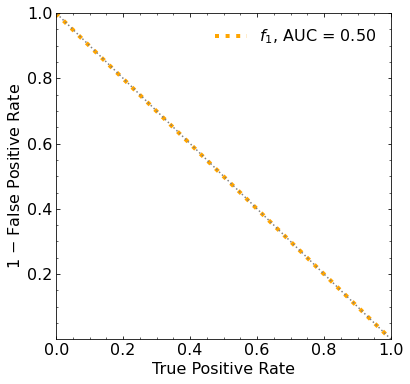


 ROC-AUC =  0.4992984000748709

final roc: 


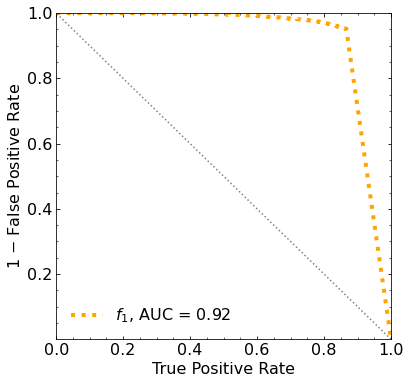


 ROC-AUC =  0.9229119952712798
Classification score:


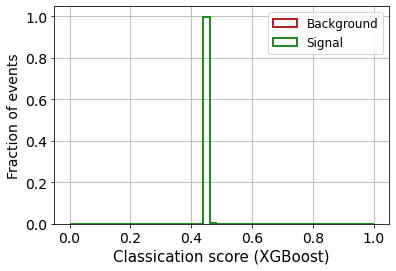


-------------------------------


#################
thresh_1ML:  0.7916666666666666
#################


X_mon_train_0:  (7495, 2744)
y_mon_train_0:  (7495,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 53
pred_XG_SM_test_0: 4830
pred_XG_NP_test_0: 757

X_mon_train_1:  (7505, 2744)
y_mon_train_1:  (7505,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7505
pred_XG_SM_train_1: 216
pred_XG_NP_train_1: 4197


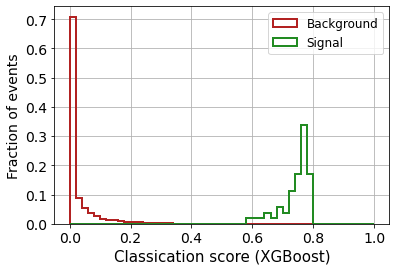

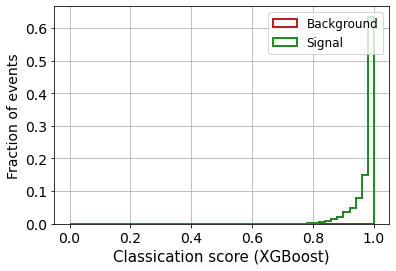

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.60055	validation_1-logloss:0.69712
[1]	validation_0-logloss:0.52474	validation_1-logloss:0.70913
[2]	validation_0-logloss:0.46154	validation_1-logloss:0.72683
[3]	validation_0-logloss:0.40816	validation_1-logloss:0.74949
[4]	validation_0-logloss:0.36257	validation_1-logloss:0.77563
[5]	validation_0-logloss:0.32337	validation_1-logloss:0.80444
[6]	validation_0-logloss:0.28940	validation_1-logloss:0.83595
[7]	validation_0-logloss:0.25965	validation_1-logloss:0.86880
[8]	validation_0-logloss:0.23355	validation_1-logloss:0.90348
[9]	validation_0-logloss:0.21075	validation_1-logloss:0.93899
[10]	validation_0-logloss:0.19076	validation_1-logloss:0.97635
[11]	validation_0-logloss:0.17263	validation_1-logloss:1.01451
[12]	validation_0-logloss:0.15658	validation_1-logloss:1.05324
[13]	validation_0-logloss:0.14268	validation_1-logloss:1.09268
[14]	validation_0-logloss:0.12981	validation_1-logloss:1.13265
[15]	validation_0-logloss:0.11813	validation_1-logloss:1.17253
[1

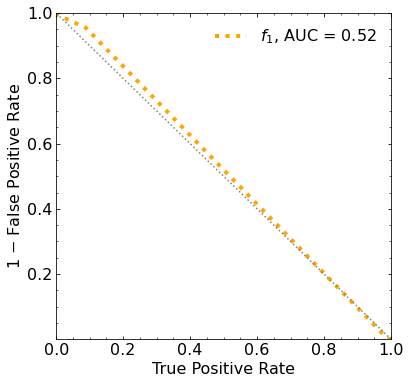


 ROC-AUC =  0.5174797815283715

final roc: 


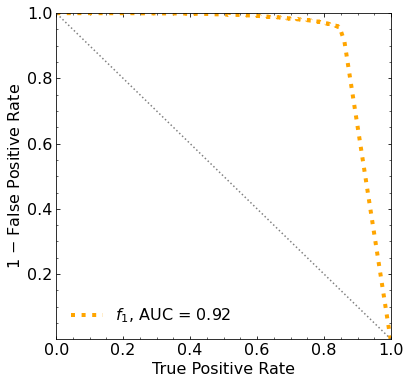


 ROC-AUC =  0.9167260516930154
Classification score:


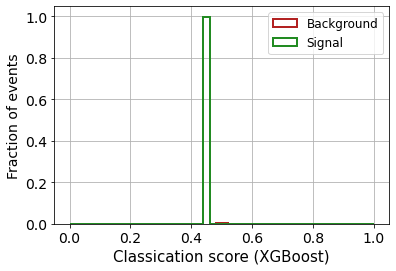


-------------------------------


#################
thresh_1ML:  0.8333333333333333
#################


X_mon_train_0:  (7548, 2744)
y_mon_train_0:  (7548,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 106
pred_XG_SM_test_0: 4867
pred_XG_NP_test_0: 878

X_mon_train_1:  (7452, 2744)
y_mon_train_1:  (7452,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7452
pred_XG_SM_train_1: 179
pred_XG_NP_train_1: 4076


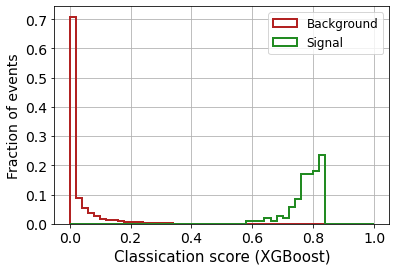

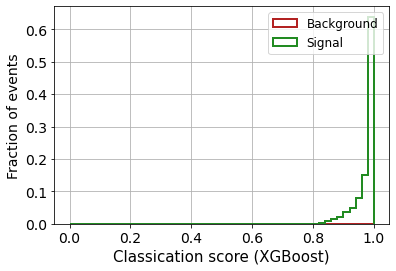

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.60295	validation_1-logloss:0.69564
[1]	validation_0-logloss:0.52900	validation_1-logloss:0.70535
[2]	validation_0-logloss:0.46755	validation_1-logloss:0.72167
[3]	validation_0-logloss:0.41534	validation_1-logloss:0.74146
[4]	validation_0-logloss:0.37100	validation_1-logloss:0.76480
[5]	validation_0-logloss:0.33301	validation_1-logloss:0.79135
[6]	validation_0-logloss:0.29983	validation_1-logloss:0.81932
[7]	validation_0-logloss:0.27064	validation_1-logloss:0.84916
[8]	validation_0-logloss:0.24529	validation_1-logloss:0.88014
[9]	validation_0-logloss:0.22313	validation_1-logloss:0.90882
[10]	validation_0-logloss:0.20341	validation_1-logloss:0.94190
[11]	validation_0-logloss:0.18631	validation_1-logloss:0.97398
[12]	validation_0-logloss:0.17109	validation_1-logloss:1.00790
[13]	validation_0-logloss:0.15751	validation_1-logloss:1.04235
[14]	validation_0-logloss:0.14558	validation_1-logloss:1.07447
[15]	validation_0-logloss:0.13441	validation_1-logloss:1.10857
[1

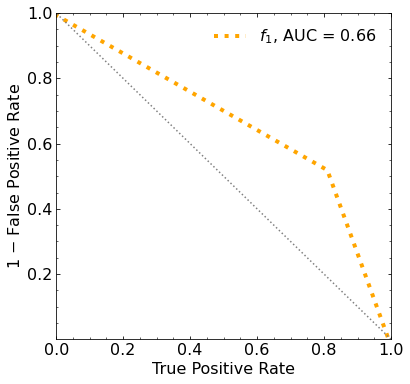


 ROC-AUC =  0.6598511288661073

final roc: 


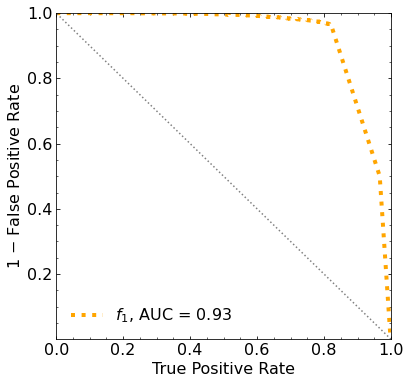


 ROC-AUC =  0.9303595856353284
Classification score:


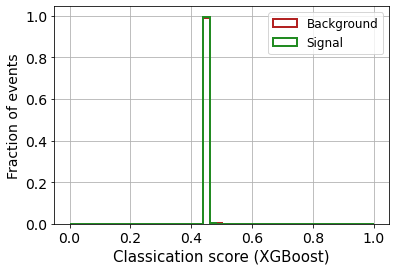


-------------------------------


#################
thresh_1ML:  0.875
#################


X_mon_train_0:  (7708, 2744)
y_mon_train_0:  (7708,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 266
pred_XG_SM_test_0: 4908
pred_XG_NP_test_0: 1046

X_mon_train_1:  (7292, 2744)
y_mon_train_1:  (7292,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7292
pred_XG_SM_train_1: 138
pred_XG_NP_train_1: 3908


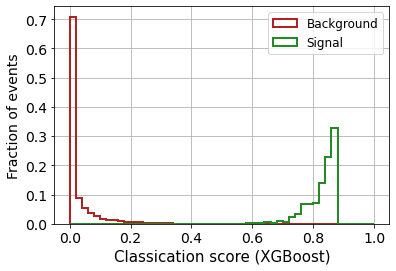

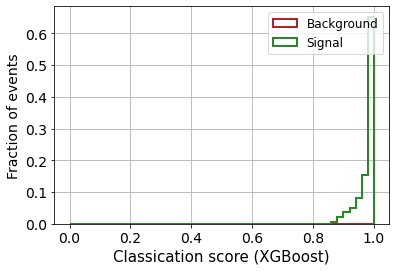

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.60958	validation_1-logloss:0.69172
[1]	validation_0-logloss:0.54110	validation_1-logloss:0.69717
[2]	validation_0-logloss:0.48419	validation_1-logloss:0.70762
[3]	validation_0-logloss:0.43583	validation_1-logloss:0.71941
[4]	validation_0-logloss:0.39501	validation_1-logloss:0.73573
[5]	validation_0-logloss:0.35957	validation_1-logloss:0.75325
[6]	validation_0-logloss:0.32942	validation_1-logloss:0.77383
[7]	validation_0-logloss:0.30284	validation_1-logloss:0.79539
[8]	validation_0-logloss:0.27998	validation_1-logloss:0.81534
[9]	validation_0-logloss:0.25992	validation_1-logloss:0.83774
[10]	validation_0-logloss:0.24161	validation_1-logloss:0.85997
[11]	validation_0-logloss:0.22584	validation_1-logloss:0.88160
[12]	validation_0-logloss:0.21187	validation_1-logloss:0.90312
[13]	validation_0-logloss:0.19895	validation_1-logloss:0.92221
[14]	validation_0-logloss:0.18790	validation_1-logloss:0.94151
[15]	validation_0-logloss:0.17833	validation_1-logloss:0.96221
[1

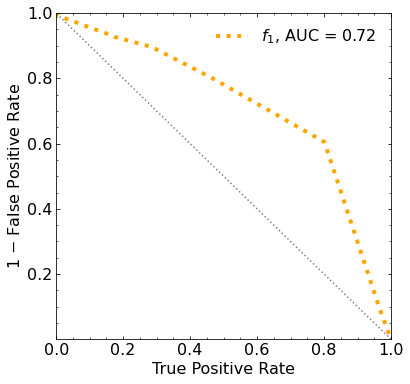


 ROC-AUC =  0.7168003111944287

final roc: 


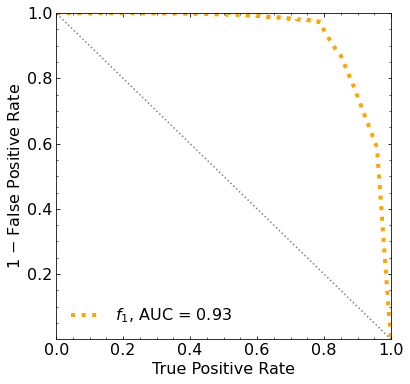


 ROC-AUC =  0.9319116169992628
Classification score:


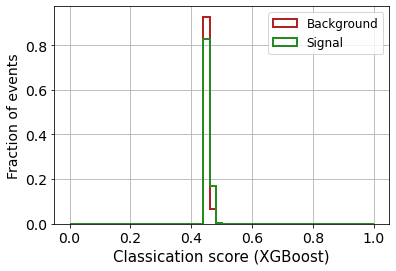


-------------------------------


#################
thresh_1ML:  0.9166666666666666
#################


X_mon_train_0:  (8121, 2744)
y_mon_train_0:  (8121,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 679
pred_XG_SM_test_0: 4944
pred_XG_NP_test_0: 1282

X_mon_train_1:  (6879, 2744)
y_mon_train_1:  (6879,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 6879
pred_XG_SM_train_1: 102
pred_XG_NP_train_1: 3672


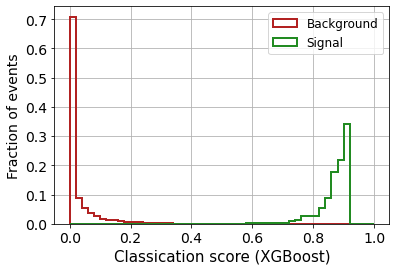

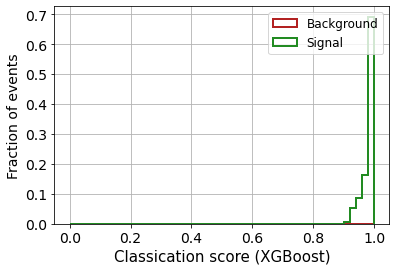

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.62277	validation_1-logloss:0.68326
[1]	validation_0-logloss:0.56459	validation_1-logloss:0.67852
[2]	validation_0-logloss:0.51597	validation_1-logloss:0.67499
[3]	validation_0-logloss:0.47484	validation_1-logloss:0.67608
[4]	validation_0-logloss:0.43994	validation_1-logloss:0.67941
[5]	validation_0-logloss:0.40985	validation_1-logloss:0.68419
[6]	validation_0-logloss:0.38341	validation_1-logloss:0.68810
[7]	validation_0-logloss:0.36112	validation_1-logloss:0.69429
[8]	validation_0-logloss:0.34131	validation_1-logloss:0.69936
[9]	validation_0-logloss:0.32450	validation_1-logloss:0.70738
[10]	validation_0-logloss:0.30891	validation_1-logloss:0.71283
[11]	validation_0-logloss:0.29514	validation_1-logloss:0.71830
[12]	validation_0-logloss:0.28313	validation_1-logloss:0.72428
[13]	validation_0-logloss:0.27224	validation_1-logloss:0.73044
[14]	validation_0-logloss:0.26262	validation_1-logloss:0.73720
[15]	validation_0-logloss:0.25382	validation_1-logloss:0.74178
[1

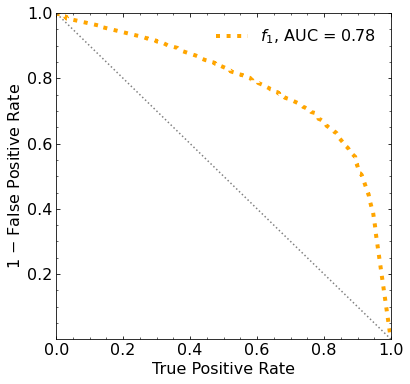


 ROC-AUC =  0.7822774986242169

final roc: 


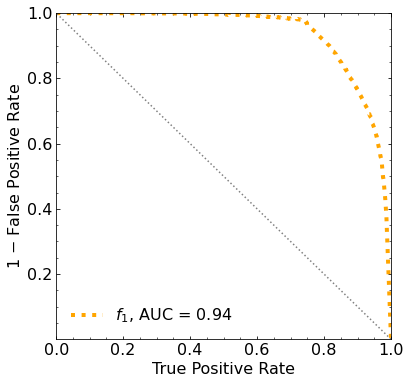


 ROC-AUC =  0.9365367684720834
Classification score:


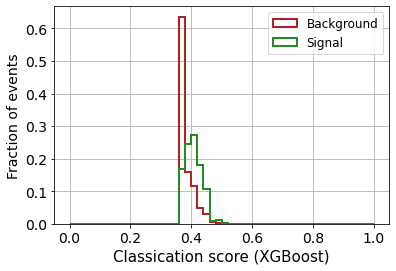


-------------------------------


#################
thresh_1ML:  0.9583333333333333
#################


X_mon_train_0:  (9054, 2744)
y_mon_train_0:  (9054,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 1612
pred_XG_SM_test_0: 4986
pred_XG_NP_test_0: 1784

X_mon_train_1:  (5946, 2744)
y_mon_train_1:  (5946,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 5946
pred_XG_SM_train_1: 60
pred_XG_NP_train_1: 3170


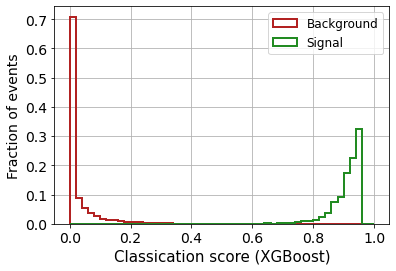

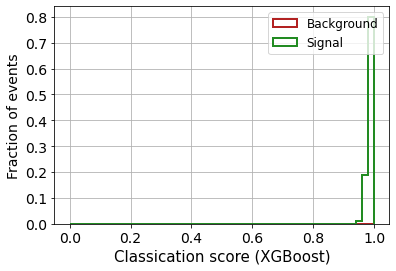

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.64143	validation_1-logloss:0.67068
[1]	validation_0-logloss:0.59813	validation_1-logloss:0.65091
[2]	validation_0-logloss:0.56086	validation_1-logloss:0.63464
[3]	validation_0-logloss:0.52909	validation_1-logloss:0.62170
[4]	validation_0-logloss:0.50238	validation_1-logloss:0.61129
[5]	validation_0-logloss:0.47831	validation_1-logloss:0.60072
[6]	validation_0-logloss:0.45732	validation_1-logloss:0.59085
[7]	validation_0-logloss:0.43867	validation_1-logloss:0.58382
[8]	validation_0-logloss:0.42242	validation_1-logloss:0.57775
[9]	validation_0-logloss:0.40778	validation_1-logloss:0.57182
[10]	validation_0-logloss:0.39407	validation_1-logloss:0.56574
[11]	validation_0-logloss:0.38204	validation_1-logloss:0.55953
[12]	validation_0-logloss:0.37048	validation_1-logloss:0.55308
[13]	validation_0-logloss:0.36046	validation_1-logloss:0.54598
[14]	validation_0-logloss:0.35115	validation_1-logloss:0.54015
[15]	validation_0-logloss:0.34226	validation_1-logloss:0.53455
[1

[130]	validation_0-logloss:0.09474	validation_1-logloss:0.31716
[131]	validation_0-logloss:0.09441	validation_1-logloss:0.31718
[132]	validation_0-logloss:0.09394	validation_1-logloss:0.31712
[133]	validation_0-logloss:0.09320	validation_1-logloss:0.31617
[134]	validation_0-logloss:0.09231	validation_1-logloss:0.31462
[135]	validation_0-logloss:0.09178	validation_1-logloss:0.31428
[136]	validation_0-logloss:0.09149	validation_1-logloss:0.31378
[137]	validation_0-logloss:0.09109	validation_1-logloss:0.31382
[138]	validation_0-logloss:0.09026	validation_1-logloss:0.31281
[139]	validation_0-logloss:0.08922	validation_1-logloss:0.31225
[140]	validation_0-logloss:0.08887	validation_1-logloss:0.31237
[141]	validation_0-logloss:0.08783	validation_1-logloss:0.31201
[142]	validation_0-logloss:0.08724	validation_1-logloss:0.31238
[143]	validation_0-logloss:0.08625	validation_1-logloss:0.31197
[144]	validation_0-logloss:0.08572	validation_1-logloss:0.31205
[145]	validation_0-logloss:0.08487	valid

[259]	validation_0-logloss:0.03734	validation_1-logloss:0.28474
[260]	validation_0-logloss:0.03726	validation_1-logloss:0.28483
[261]	validation_0-logloss:0.03682	validation_1-logloss:0.28479
[262]	validation_0-logloss:0.03654	validation_1-logloss:0.28474
[263]	validation_0-logloss:0.03633	validation_1-logloss:0.28466
[264]	validation_0-logloss:0.03615	validation_1-logloss:0.28452
[265]	validation_0-logloss:0.03604	validation_1-logloss:0.28417
[266]	validation_0-logloss:0.03563	validation_1-logloss:0.28333
[267]	validation_0-logloss:0.03541	validation_1-logloss:0.28309
[268]	validation_0-logloss:0.03522	validation_1-logloss:0.28370
[269]	validation_0-logloss:0.03494	validation_1-logloss:0.28342
[270]	validation_0-logloss:0.03450	validation_1-logloss:0.28269
[271]	validation_0-logloss:0.03428	validation_1-logloss:0.28295
[272]	validation_0-logloss:0.03414	validation_1-logloss:0.28323
[273]	validation_0-logloss:0.03403	validation_1-logloss:0.28368
[274]	validation_0-logloss:0.03393	valid

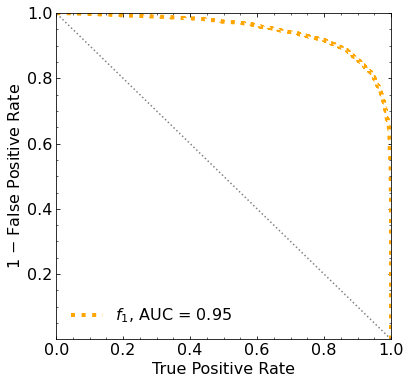


 ROC-AUC =  0.9472294847096534

final roc: 


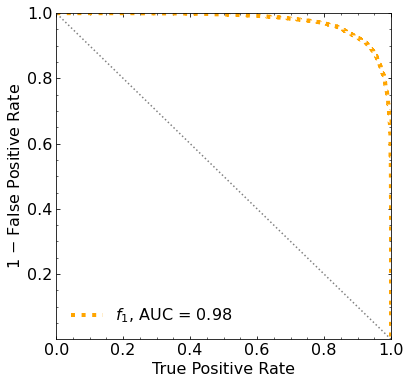


 ROC-AUC =  0.9755104472042514
Classification score:


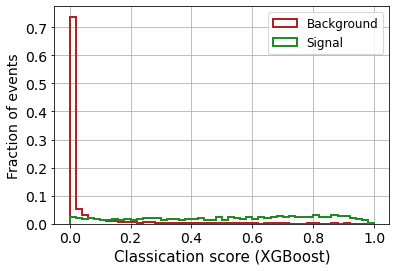


-------------------------------


#################
thresh_1ML:  1.0
#################


X_mon_train_0:  (15000, 2744)
y_mon_train_0:  (15000,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 7558
pred_XG_SM_test_0: 5046
pred_XG_NP_test_0: 4954

X_mon_train_1:  (0,)
y_mon_train_1:  (0,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 0
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 0


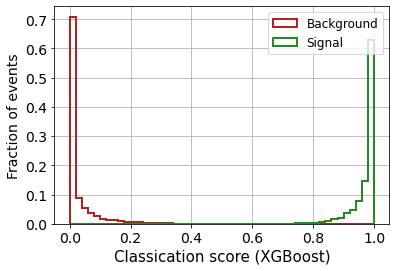

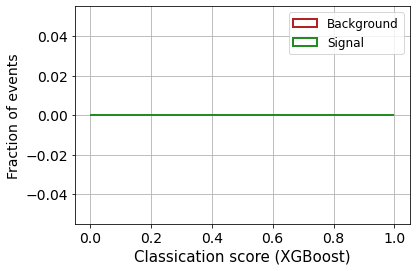

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.64279	validation_1-logloss:0.64624
[1]	validation_0-logloss:0.59963	validation_1-logloss:0.60535
[2]	validation_0-logloss:0.56226	validation_1-logloss:0.57073
[3]	validation_0-logloss:0.52980	validation_1-logloss:0.54142
[4]	validation_0-logloss:0.50180	validation_1-logloss:0.51604
[5]	validation_0-logloss:0.47777	validation_1-logloss:0.49450
[6]	validation_0-logloss:0.45538	validation_1-logloss:0.47416
[7]	validation_0-logloss:0.43584	validation_1-logloss:0.45685
[8]	validation_0-logloss:0.41799	validation_1-logloss:0.44125
[9]	validation_0-logloss:0.40195	validation_1-logloss:0.42700
[10]	validation_0-logloss:0.38751	validation_1-logloss:0.41472
[11]	validation_0-logloss:0.37438	validation_1-logloss:0.40410
[12]	validation_0-logloss:0.36225	validation_1-logloss:0.39447
[13]	validation_0-logloss:0.35078	validation_1-logloss:0.38526
[14]	validation_0-logloss:0.33937	validation_1-logloss:0.37629
[15]	validation_0-logloss:0.32969	validation_1-logloss:0.36780
[1

[130]	validation_0-logloss:0.06535	validation_1-logloss:0.19432
[131]	validation_0-logloss:0.06496	validation_1-logloss:0.19413
[132]	validation_0-logloss:0.06442	validation_1-logloss:0.19388
[133]	validation_0-logloss:0.06379	validation_1-logloss:0.19358
[134]	validation_0-logloss:0.06337	validation_1-logloss:0.19342
[135]	validation_0-logloss:0.06253	validation_1-logloss:0.19319
[136]	validation_0-logloss:0.06214	validation_1-logloss:0.19302
[137]	validation_0-logloss:0.06139	validation_1-logloss:0.19287
[138]	validation_0-logloss:0.06077	validation_1-logloss:0.19278
[139]	validation_0-logloss:0.06026	validation_1-logloss:0.19263
[140]	validation_0-logloss:0.05986	validation_1-logloss:0.19253
[141]	validation_0-logloss:0.05950	validation_1-logloss:0.19274
[142]	validation_0-logloss:0.05919	validation_1-logloss:0.19248
[143]	validation_0-logloss:0.05880	validation_1-logloss:0.19225
[144]	validation_0-logloss:0.05824	validation_1-logloss:0.19230
[145]	validation_0-logloss:0.05781	valid

[259]	validation_0-logloss:0.02502	validation_1-logloss:0.18991
[260]	validation_0-logloss:0.02480	validation_1-logloss:0.19010
[261]	validation_0-logloss:0.02456	validation_1-logloss:0.19013
[262]	validation_0-logloss:0.02436	validation_1-logloss:0.19003
[263]	validation_0-logloss:0.02416	validation_1-logloss:0.19021
[264]	validation_0-logloss:0.02401	validation_1-logloss:0.19018
[265]	validation_0-logloss:0.02380	validation_1-logloss:0.19024
[266]	validation_0-logloss:0.02367	validation_1-logloss:0.19011
[267]	validation_0-logloss:0.02360	validation_1-logloss:0.19006
[268]	validation_0-logloss:0.02347	validation_1-logloss:0.18994
[269]	validation_0-logloss:0.02325	validation_1-logloss:0.19004
[270]	validation_0-logloss:0.02304	validation_1-logloss:0.19022
[271]	validation_0-logloss:0.02292	validation_1-logloss:0.19025
[272]	validation_0-logloss:0.02281	validation_1-logloss:0.19025
[273]	validation_0-logloss:0.02273	validation_1-logloss:0.19022
[274]	validation_0-logloss:0.02263	valid

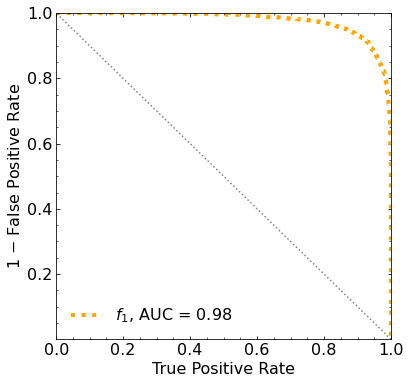


 ROC-AUC =  0.9768742426358966

final roc: 


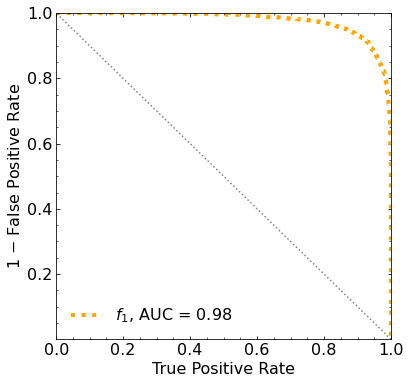


 ROC-AUC =  0.9768742426358966
Classification score:


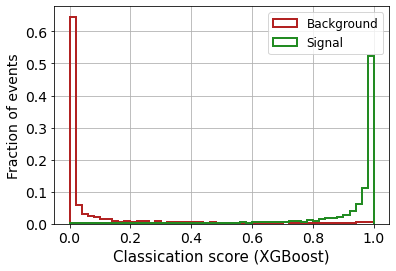


-------------------------------



In [128]:
y_pred_xg_train = classifier.predict_proba(X_mon_train).T[1]

thresh_1ML = np.linspace(0,1,25)

print('ML Output threshold: ', thresh_1ML)


save_SsqrtB_2ML = []
save_auc = []

for it_1ML in range(len(thresh_1ML)):
    
    print('\n#################')
    print('thresh_1ML: ', thresh_1ML[it_1ML])
    print('#################\n')
    
    # TRAIN SET #

    X_mon_train_0 = []
    y_mon_train_0 = []
    pred_XG_SM_train_0 = []
    pred_XG_NP_train_0 = []

    X_mon_train_1 = []
    y_mon_train_1 = []
    pred_XG_SM_train_1 = []
    pred_XG_NP_train_1 = []

    for i in range(len(y_mon_train)):
        if y_pred_xg_train[i] < thresh_1ML[it_1ML]:
            X_mon_train_0.append(X_mon_train[i].tolist())
            y_mon_train_0.append(int(y_mon_train[i].tolist()))

            if y_mon_train[i] == 0:
                pred_XG_SM_train_0.append(y_pred_xg_train[i])
            else:
                pred_XG_NP_train_0.append(y_pred_xg_train[i])

        else:
            X_mon_train_1.append(X_mon_train[i].tolist())
            y_mon_train_1.append(int(y_mon_train[i].tolist()))

            if y_mon_train[i] == 0:
                pred_XG_SM_train_1.append(y_pred_xg_train[i])
            else:
                pred_XG_NP_train_1.append(y_pred_xg_train[i])

    X_mon_train_0 = np.asarray(X_mon_train_0)
    y_mon_train_0 = np.asarray(y_mon_train_0)
    X_mon_train_1 = np.asarray(X_mon_train_1)
    y_mon_train_1 = np.asarray(y_mon_train_1)



    # TEST SET #

    X_mon_test_0 = []
    y_mon_test_0 = []
    pred_XG_SM_test_0 = []
    pred_XG_NP_test_0 = []

    X_mon_test_1 = []
    y_mon_test_1 = []
    pred_XG_SM_test_1 = []
    pred_XG_NP_test_1 = []

    for i in range(len(y_mon_test)):
        if y_pred_xg[i] < thresh_1ML[it_1ML]:
            X_mon_test_0.append(X_mon_test[i].tolist())
            y_mon_test_0.append(int(y_mon_test[i].tolist()))
            
            if y_mon_test[i] == 0:
                pred_XG_SM_test_0.append(y_pred_xg[i])
            else:
                pred_XG_NP_test_0.append(y_pred_xg[i])

        else:
            X_mon_test_1.append(X_mon_test[i].tolist())
            y_mon_test_1.append(int(y_mon_test[i].tolist()))
            
            if y_mon_test[i] == 0:
                pred_XG_SM_test_1.append(y_pred_xg[i])
            else:
                pred_XG_NP_test_1.append(y_pred_xg[i])
                
    B_thresh_1ML = len(pred_XG_SM_test_1)
    S_thresh_1ML = len(pred_XG_NP_test_1)


    print('\nX_mon_train_0: ', X_mon_train_0.shape)
    print('y_mon_train_0: ', y_mon_train_0.shape)
    print('pred_XG_SM_train_0:', len(pred_XG_SM_train_0))
    print('pred_XG_NP_train_0:', len(pred_XG_NP_train_0))
    print('pred_XG_SM_test_0:', len(pred_XG_SM_test_0))
    print('pred_XG_NP_test_0:', len(pred_XG_NP_test_0))

    print('\nX_mon_train_1: ', X_mon_train_1.shape)
    print('y_mon_train_1: ', y_mon_train_1.shape)
    print('pred_XG_SM_train_1:', len(pred_XG_SM_train_1))
    print('pred_XG_NP_train_1:', len(pred_XG_NP_train_1))
    print('pred_XG_SM_train_1:', len(pred_XG_SM_test_1))
    print('pred_XG_NP_train_1:', len(pred_XG_NP_test_1))




    weights = np.ones_like(pred_XG_SM_train_0)/float(len(pred_XG_SM_train_0))
    plt.hist(pred_XG_SM_train_0, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

    weights = np.ones_like(pred_XG_NP_train_0)/float(len(pred_XG_NP_train_0))
    plt.hist(pred_XG_NP_train_0, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Classication score (XGBoost)",fontsize=15)
    plt.ylabel("Fraction of events",fontsize=14)
    plt.grid()
    plt.legend(fontsize=12)

    plt.show()



    weights = np.ones_like(pred_XG_SM_train_1)/float(len(pred_XG_SM_train_1))
    plt.hist(pred_XG_SM_train_1, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

    weights = np.ones_like(pred_XG_NP_train_1)/float(len(pred_XG_NP_train_1))
    plt.hist(pred_XG_NP_train_1, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Classication score (XGBoost)",fontsize=15)
    plt.ylabel("Fraction of events",fontsize=14)
    plt.grid()
    plt.legend(fontsize=12)

    plt.show()
    
    
    
    if len(pred_XG_SM_train_0) > 0 and len(pred_XG_NP_train_0) > 0:


        # CLASSIFIER #


        # XGBoost with only the kinematic variables of the leptons

        # CLASSIFIER
        classifier_2ML = XGBClassifier(
            n_estimators=1500,
            learning_rate=0.1,
            reg_lambda=0.0,reg_alpha=0.0,
            gamma=0.0,objective='binary:logistic',
            max_depth=5,
            #eval_metric=["error", "logloss", "map"]
            eval_metric='logloss')

        # FIT
        classifier_2ML.fit(X_mon_train_0,y_mon_train_0,eval_set=[(X_mon_train_0, y_mon_train_0), (X_mon_val, y_mon_val)],
                early_stopping_rounds=50,#early stopping
                verbose=True)


        # PREDICTIONS
        y_pred_xg_2ML = classifier_2ML.predict_proba(X_mon_test_0).T[1]


        # ROC
        fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test_0, y_pred_xg_2ML)
        roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


        # PLOT THE ROC WITH AUC
        fig = plt.figure(figsize=(6, 6))
        gs = gridspec.GridSpec(1, 1) 
        ax0 = plt.subplot(gs[0])
        ax0.yaxis.set_ticks_position('both')
        ax0.xaxis.set_ticks_position('both')
        ax0.tick_params(direction="in",which="both")
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        ax0.minorticks_on()


        plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
        plt.plot([1,0],[0,1],ls=":",color="grey")
        plt.xlabel("True Positive Rate",fontsize=16)
        plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
        plt.legend()
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.yticks([0.2,0.4,0.6,0.8,1.])
        plt.legend(frameon=False,fontsize=16)
        plt.show()
        
        print('\n ROC-AUC = ', roc_auc_xg)
        
        
        
        print('\nfinal roc: ')
        labels = np.concatenate([np.zeros(len(pred_XG_SM_test_1)), np.ones(len(pred_XG_NP_test_1)), y_mon_test_0])
        predictions = np.concatenate([np.asarray(pred_XG_SM_test_1), np.asarray(pred_XG_NP_test_1) ,y_pred_xg_2ML])


        fpr_mon_xg, tpr_mon_xg, _ = roc_curve(labels, predictions)
        roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)

        save_auc.append( roc_auc_xg )


        # PLOT THE ROC WITH AUC
        fig = plt.figure(figsize=(6, 6))
        gs = gridspec.GridSpec(1, 1) 
        ax0 = plt.subplot(gs[0])
        ax0.yaxis.set_ticks_position('both')
        ax0.xaxis.set_ticks_position('both')
        ax0.tick_params(direction="in",which="both")
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        ax0.minorticks_on()


        plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
        plt.plot([1,0],[0,1],ls=":",color="grey")
        plt.xlabel("True Positive Rate",fontsize=16)
        plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
        plt.legend()
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.yticks([0.2,0.4,0.6,0.8,1.])
        plt.legend(frameon=False,fontsize=16)
        plt.show()
        
        print('\n ROC-AUC = ', roc_auc_xg)



        # XGBoost with the kinematic variables of the leptons

        ########################
        # CLASSIFICATION SCORE #
        ########################

        # Outputs for validation data set

        pred_XG_SM = []
        pred_XG_NP = []

        for i in range(len(y_mon_test_0)):
            if y_mon_test_0[i] == 0:
                pred_XG_SM.append(y_pred_xg_2ML[i])
            else:
                pred_XG_NP.append(y_pred_xg_2ML[i])


        print('Classification score:')

        weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
        nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

        weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
        nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Classication score (XGBoost)",fontsize=15)
        plt.ylabel("Fraction of events",fontsize=14)
        plt.grid()
        plt.legend(fontsize=12)

        plt.show()




        




        thresh_2ML = np.linspace(0,1,20)

        B_thresh = []
        S_thresh = []

        for it_2ML in range(len(thresh_2ML)):

            # TEST SET #

            pred_XG_SM_test_0_2ML = []
            pred_XG_NP_test_0_2ML = []

            pred_XG_SM_test_1_2ML = []
            pred_XG_NP_test_1_2ML = []

            for i in range(len(y_mon_test_0)):
                if y_pred_xg_2ML[i] < thresh_2ML[it_2ML]:
                    if y_mon_test_0[i] == 0:
                        pred_XG_SM_test_0_2ML.append(y_pred_xg_2ML[i])
                    else:
                        pred_XG_NP_test_0_2ML.append(y_pred_xg_2ML[i])

                else:
                    if y_mon_test_0[i] == 0:
                        pred_XG_SM_test_1_2ML.append(y_pred_xg_2ML[i])
                    else:
                        pred_XG_NP_test_1_2ML.append(y_pred_xg_2ML[i])

#             print('\nthresh: ', thresh_2ML[it_2ML])
    #         print('len(pred_XG_SM_test_1): ', len(pred_XG_SM_test_1))
    #         print('len(pred_XG_NP_test_1): ', len(pred_XG_NP_test_1))
            B_thresh.append( B_thresh_1ML + len(pred_XG_SM_test_1_2ML) )
            S_thresh.append( S_thresh_1ML + len(pred_XG_NP_test_1_2ML) )


        SsqrtB_2ML = []

        for i in range(len(B_thresh)):
            if B_thresh[i] >= 3:
                SsqrtB_2ML.append( S_thresh[i]/np.sqrt(B_thresh[i]) )
            else:
                SsqrtB_2ML.append(None)


        save_SsqrtB_2ML.append(SsqrtB_2ML)
        
        
        
    else:
        
        SsqrtB_2ML = []
        for it_2ML in range(20):
            SsqrtB_2ML.append(None)
            
            
        save_SsqrtB_2ML.append(SsqrtB_2ML)
        save_auc.append(None)
        
 
    
    
    print('\n-------------------------------\n')

roc_auc_only1ML:  0.9768742426358966


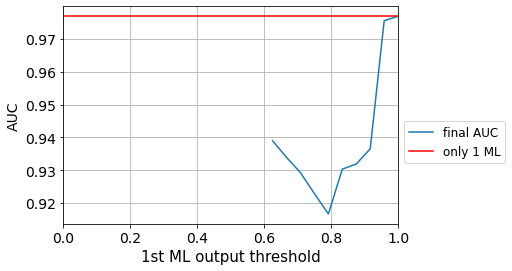

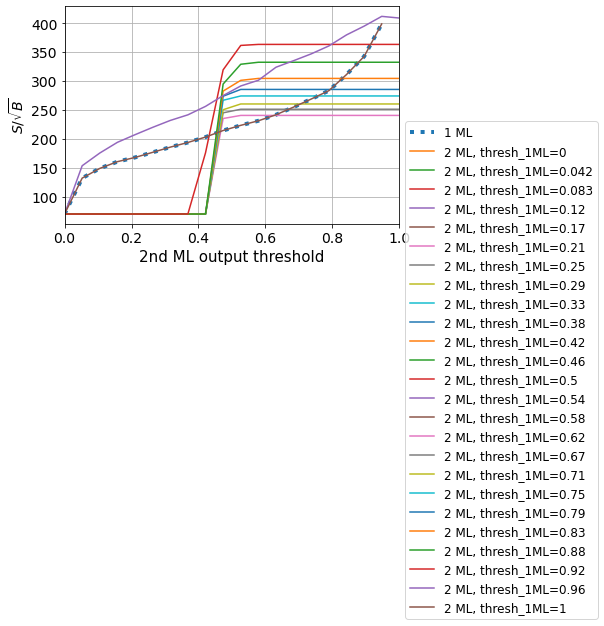

In [138]:
print('roc_auc_only1ML: ', roc_auc_only1ML)


plt.plot(thresh_1ML, save_auc, label='final AUC')

plt.axhline(y=roc_auc_only1ML, c='red', label='only 1 ML')
plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("1st ML output threshold",fontsize=15)
plt.ylabel("AUC",fontsize=14)
plt.grid()
plt.legend(fontsize=12, bbox_to_anchor=(1, 0.5))

plt.show()




plt.plot(thresh, SsqrtB, ':', lw=4, label='1 ML')
for i in range(len(thresh_1ML)):
    plt.plot(thresh_2ML, save_SsqrtB_2ML[i], label='2 ML, thresh_1ML=%.2g' % thresh_1ML[i])

plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("2nd ML output threshold",fontsize=15)
plt.ylabel("$S/\sqrt{B}$",fontsize=14)
plt.grid()
plt.legend(fontsize=12, bbox_to_anchor=(1, 0.5))

plt.show()

## WITH OVERSAMPLE

In [30]:
import imblearn
from imblearn.over_sampling import SMOTE

### Option A

ML Output threshold:  [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]

#################
thresh_1ML:  0.0
#################


X_mon_train_0:  (0,)
y_mon_train_0:  (0,)
pred_XG_SM_train_0: 0
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 0
pred_XG_NP_test_0: 0

X_mon_train_1:  (15000, 2744)
y_mon_train_1:  (15000,)
pred_XG_SM_train_1: 7442
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 5046
pred_XG_NP_train_1: 4954


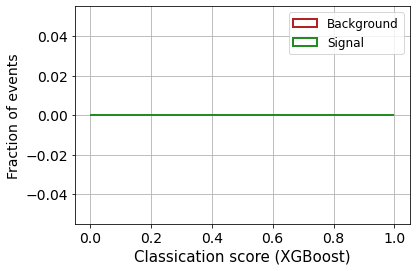

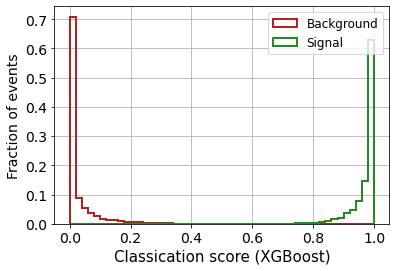


-------------------------------


#################
thresh_1ML:  0.041666666666666664
#################


X_mon_train_0:  (5967, 2744)
y_mon_train_0:  (5967,)
pred_XG_SM_train_0: 5967
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 3567
pred_XG_NP_test_0: 29

X_mon_train_1:  (9033, 2744)
y_mon_train_1:  (9033,)
pred_XG_SM_train_1: 1475
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 1479
pred_XG_NP_train_1: 4925


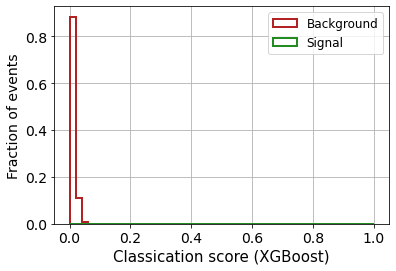

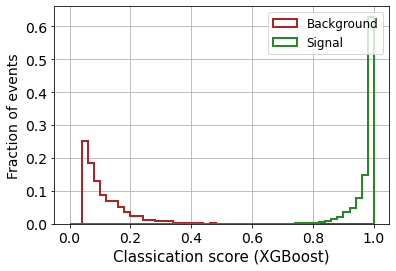


-------------------------------


#################
thresh_1ML:  0.08333333333333333
#################


X_mon_train_0:  (6648, 2744)
y_mon_train_0:  (6648,)
pred_XG_SM_train_0: 6648
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 3856
pred_XG_NP_test_0: 59

X_mon_train_1:  (8352, 2744)
y_mon_train_1:  (8352,)
pred_XG_SM_train_1: 794
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 1190
pred_XG_NP_train_1: 4895


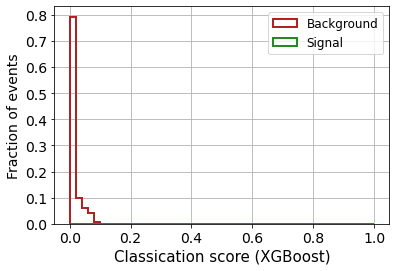

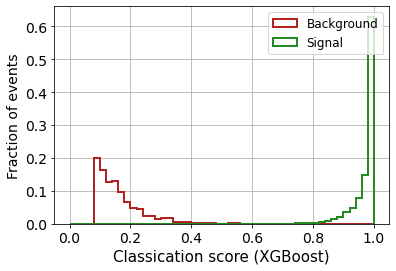


-------------------------------


#################
thresh_1ML:  0.125
#################


X_mon_train_0:  (6969, 2744)
y_mon_train_0:  (6969,)
pred_XG_SM_train_0: 6969
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4030
pred_XG_NP_test_0: 83

X_mon_train_1:  (8031, 2744)
y_mon_train_1:  (8031,)
pred_XG_SM_train_1: 473
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 1016
pred_XG_NP_train_1: 4871


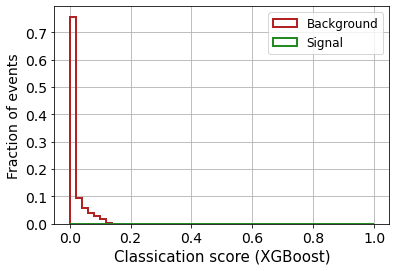

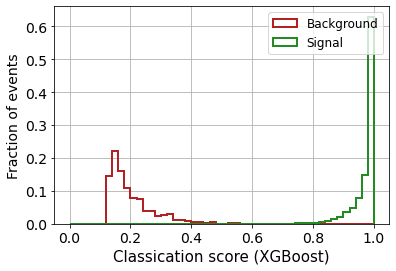


-------------------------------


#################
thresh_1ML:  0.16666666666666666
#################


X_mon_train_0:  (7162, 2744)
y_mon_train_0:  (7162,)
pred_XG_SM_train_0: 7162
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4151
pred_XG_NP_test_0: 108

X_mon_train_1:  (7838, 2744)
y_mon_train_1:  (7838,)
pred_XG_SM_train_1: 280
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 895
pred_XG_NP_train_1: 4846


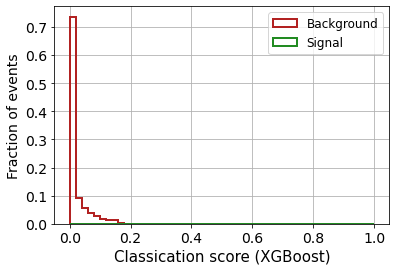

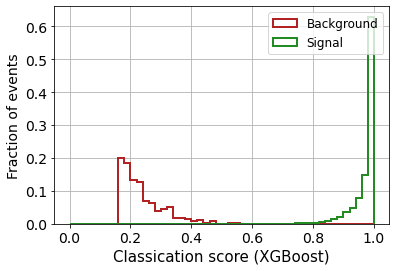


-------------------------------


#################
thresh_1ML:  0.20833333333333331
#################


X_mon_train_0:  (7289, 2744)
y_mon_train_0:  (7289,)
pred_XG_SM_train_0: 7289
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4220
pred_XG_NP_test_0: 139

X_mon_train_1:  (7711, 2744)
y_mon_train_1:  (7711,)
pred_XG_SM_train_1: 153
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 826
pred_XG_NP_train_1: 4815


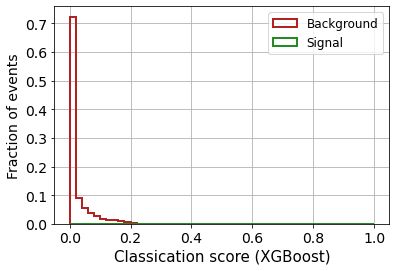

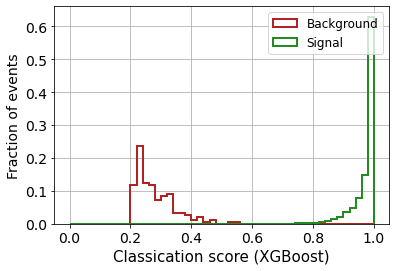


-------------------------------


#################
thresh_1ML:  0.25
#################


X_mon_train_0:  (7356, 2744)
y_mon_train_0:  (7356,)
pred_XG_SM_train_0: 7356
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4294
pred_XG_NP_test_0: 174

X_mon_train_1:  (7644, 2744)
y_mon_train_1:  (7644,)
pred_XG_SM_train_1: 86
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 752
pred_XG_NP_train_1: 4780


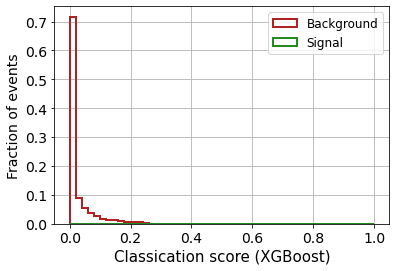

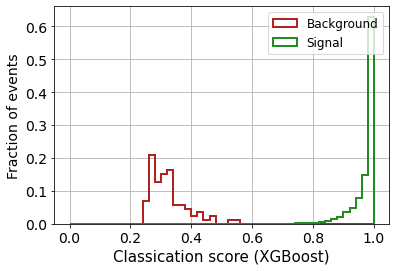


-------------------------------


#################
thresh_1ML:  0.29166666666666663
#################


X_mon_train_0:  (7389, 2744)
y_mon_train_0:  (7389,)
pred_XG_SM_train_0: 7389
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4360
pred_XG_NP_test_0: 205

X_mon_train_1:  (7611, 2744)
y_mon_train_1:  (7611,)
pred_XG_SM_train_1: 53
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 686
pred_XG_NP_train_1: 4749


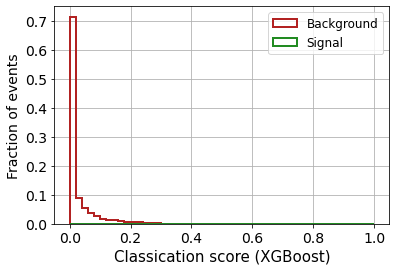

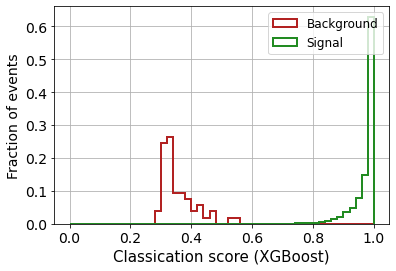


-------------------------------


#################
thresh_1ML:  0.3333333333333333
#################


X_mon_train_0:  (7414, 2744)
y_mon_train_0:  (7414,)
pred_XG_SM_train_0: 7414
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4422
pred_XG_NP_test_0: 226

X_mon_train_1:  (7586, 2744)
y_mon_train_1:  (7586,)
pred_XG_SM_train_1: 28
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 624
pred_XG_NP_train_1: 4728


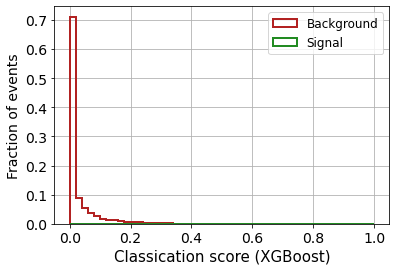

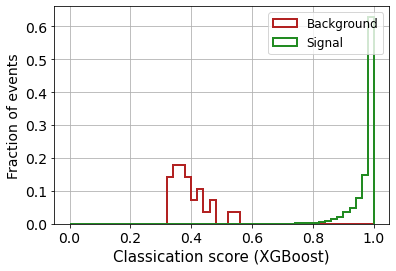


-------------------------------


#################
thresh_1ML:  0.375
#################


X_mon_train_0:  (7426, 2744)
y_mon_train_0:  (7426,)
pred_XG_SM_train_0: 7426
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4465
pred_XG_NP_test_0: 263

X_mon_train_1:  (7574, 2744)
y_mon_train_1:  (7574,)
pred_XG_SM_train_1: 16
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 581
pred_XG_NP_train_1: 4691


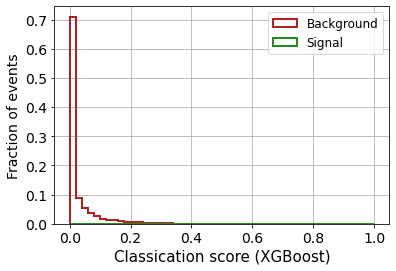

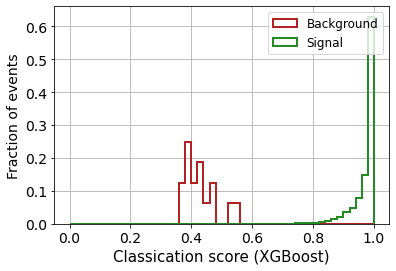


-------------------------------


#################
thresh_1ML:  0.41666666666666663
#################


X_mon_train_0:  (7434, 2744)
y_mon_train_0:  (7434,)
pred_XG_SM_train_0: 7434
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4516
pred_XG_NP_test_0: 296

X_mon_train_1:  (7566, 2744)
y_mon_train_1:  (7566,)
pred_XG_SM_train_1: 8
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 530
pred_XG_NP_train_1: 4658


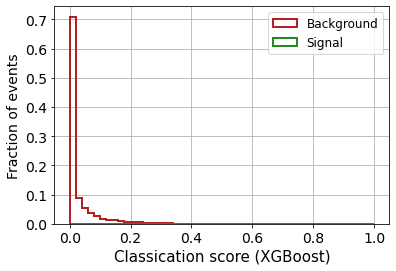

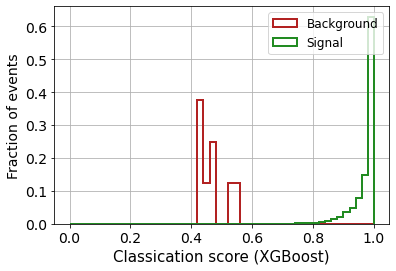


-------------------------------


#################
thresh_1ML:  0.4583333333333333
#################


X_mon_train_0:  (7438, 2744)
y_mon_train_0:  (7438,)
pred_XG_SM_train_0: 7438
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4559
pred_XG_NP_test_0: 320

X_mon_train_1:  (7562, 2744)
y_mon_train_1:  (7562,)
pred_XG_SM_train_1: 4
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 487
pred_XG_NP_train_1: 4634


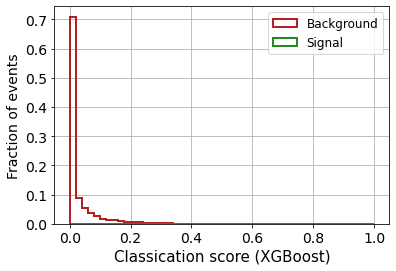

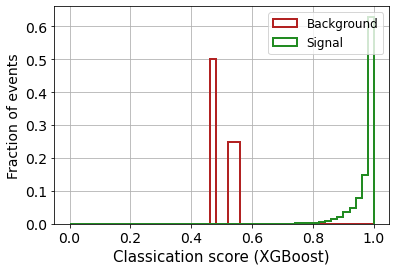


-------------------------------


#################
thresh_1ML:  0.5
#################


X_mon_train_0:  (7440, 2744)
y_mon_train_0:  (7440,)
pred_XG_SM_train_0: 7440
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4605
pred_XG_NP_test_0: 353

X_mon_train_1:  (7560, 2744)
y_mon_train_1:  (7560,)
pred_XG_SM_train_1: 2
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 441
pred_XG_NP_train_1: 4601


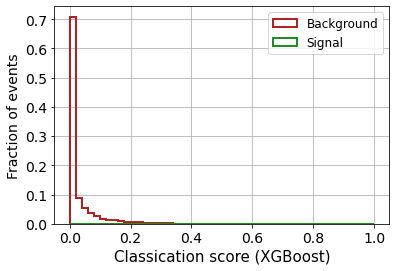

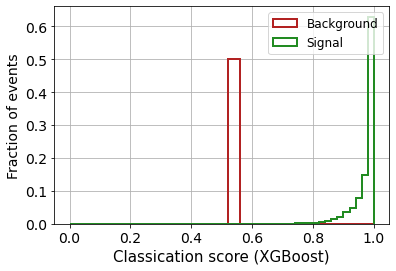


-------------------------------


#################
thresh_1ML:  0.5416666666666666
#################


X_mon_train_0:  (7442, 2744)
y_mon_train_0:  (7442,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4634
pred_XG_NP_test_0: 390

X_mon_train_1:  (7558, 2744)
y_mon_train_1:  (7558,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 412
pred_XG_NP_train_1: 4564


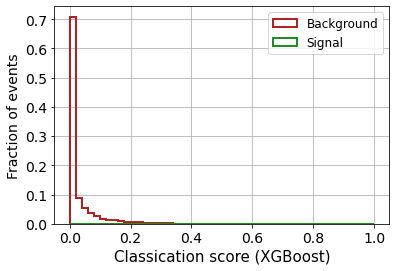

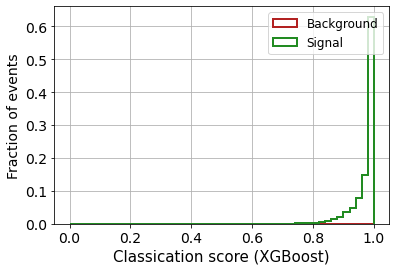


-------------------------------


#################
thresh_1ML:  0.5833333333333333
#################


X_mon_train_0:  (7442, 2744)
y_mon_train_0:  (7442,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4668
pred_XG_NP_test_0: 432

X_mon_train_1:  (7558, 2744)
y_mon_train_1:  (7558,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 378
pred_XG_NP_train_1: 4522


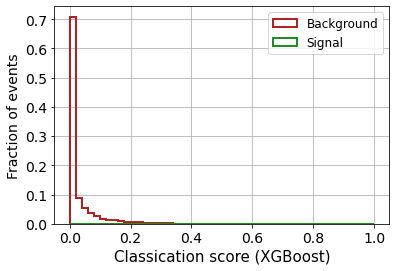

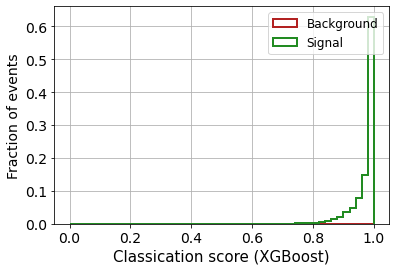


-------------------------------


#################
thresh_1ML:  0.625
#################


X_mon_train_0:  (7444, 2744)
y_mon_train_0:  (7444,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 2
pred_XG_SM_test_0: 4700
pred_XG_NP_test_0: 479

X_mon_train_1:  (7556, 2744)
y_mon_train_1:  (7556,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7556
pred_XG_SM_train_1: 346
pred_XG_NP_train_1: 4475


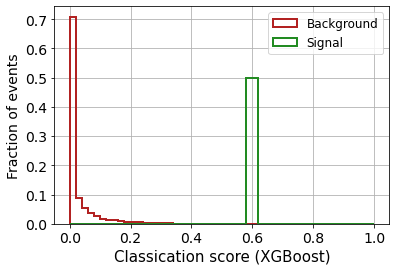

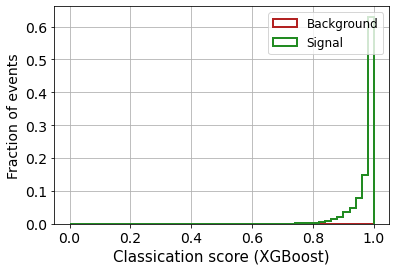

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.59822	validation_1-logloss:0.69764
[1]	validation_0-logloss:0.52047	validation_1-logloss:0.71034
[2]	validation_0-logloss:0.45564	validation_1-logloss:0.72915
[3]	validation_0-logloss:0.40084	validation_1-logloss:0.75273
[4]	validation_0-logloss:0.35402	validation_1-logloss:0.78009
[5]	validation_0-logloss:0.31369	validation_1-logloss:0.81062
[6]	validation_0-logloss:0.27871	validation_1-logloss:0.84366
[7]	validation_0-logloss:0.24821	validation_1-logloss:0.87880
[8]	validation_0-logloss:0.22148	validation_1-logloss:0.91570
[9]	validation_0-logloss:0.19796	validation_1-logloss:0.95417
[10]	validation_0-logloss:0.17719	validation_1-logloss:0.99391
[11]	validation_0-logloss:0.15881	validation_1-logloss:1.03486
[12]	validation_0-logloss:0.14250	validation_1-logloss:1.07679
[13]	validation_0-logloss:0.12799	validation_1-logloss:1.11954
[14]	validation_0-logloss:0.11506	validation_1-logloss:1.16305
[15]	validation_0-logloss:0.10351	validation_1-logloss:1.20727
[1

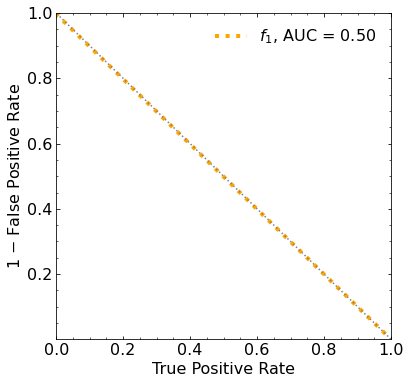

Classification score:


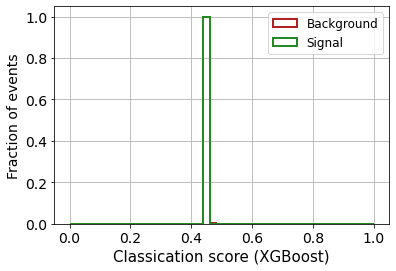


 ROC-AUC =  0.4985191946646364

-------------------------------


#################
thresh_1ML:  0.6666666666666666
#################


X_mon_train_0:  (7448, 2744)
y_mon_train_0:  (7448,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 6
pred_XG_SM_test_0: 4737
pred_XG_NP_test_0: 537

X_mon_train_1:  (7552, 2744)
y_mon_train_1:  (7552,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7552
pred_XG_SM_train_1: 309
pred_XG_NP_train_1: 4417


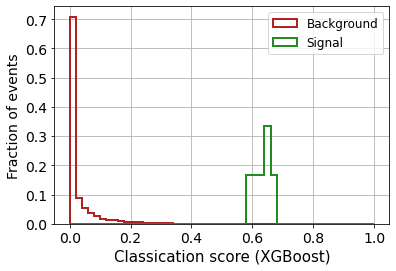

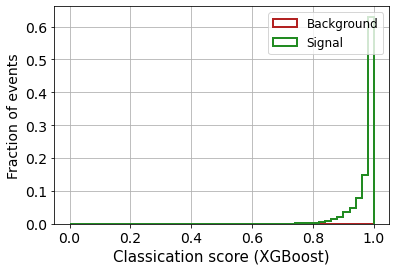

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.59839	validation_1-logloss:0.69756
[1]	validation_0-logloss:0.52080	validation_1-logloss:0.71020
[2]	validation_0-logloss:0.45609	validation_1-logloss:0.72895
[3]	validation_0-logloss:0.40140	validation_1-logloss:0.75243
[4]	validation_0-logloss:0.35468	validation_1-logloss:0.77969
[5]	validation_0-logloss:0.31444	validation_1-logloss:0.81010
[6]	validation_0-logloss:0.27954	validation_1-logloss:0.84297
[7]	validation_0-logloss:0.24910	validation_1-logloss:0.87796
[8]	validation_0-logloss:0.22243	validation_1-logloss:0.91469
[9]	validation_0-logloss:0.19897	validation_1-logloss:0.95296
[10]	validation_0-logloss:0.17826	validation_1-logloss:0.99258
[11]	validation_0-logloss:0.15993	validation_1-logloss:1.03333
[12]	validation_0-logloss:0.14366	validation_1-logloss:1.07500
[13]	validation_0-logloss:0.12912	validation_1-logloss:1.11722
[14]	validation_0-logloss:0.11617	validation_1-logloss:1.16019
[15]	validation_0-logloss:0.10461	validation_1-logloss:1.20393
[1

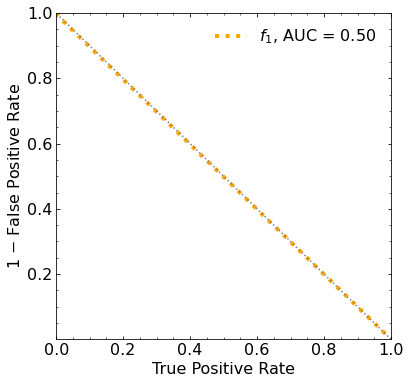

Classification score:


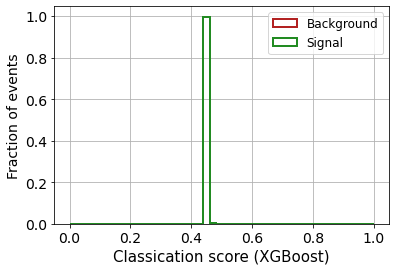


 ROC-AUC =  0.49804993494649386

-------------------------------


#################
thresh_1ML:  0.7083333333333333
#################


X_mon_train_0:  (7452, 2744)
y_mon_train_0:  (7452,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 10
pred_XG_SM_test_0: 4765
pred_XG_NP_test_0: 589

X_mon_train_1:  (7548, 2744)
y_mon_train_1:  (7548,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7548
pred_XG_SM_train_1: 281
pred_XG_NP_train_1: 4365


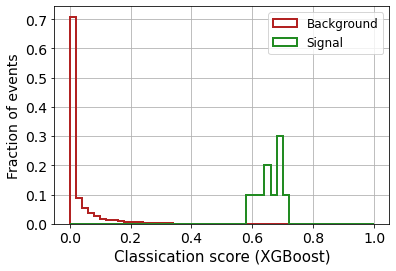

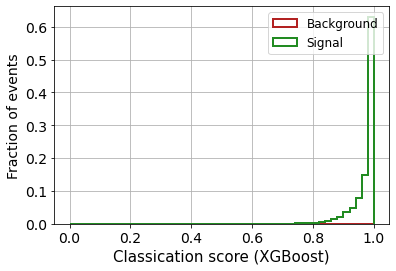

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.59859	validation_1-logloss:0.69749
[1]	validation_0-logloss:0.52115	validation_1-logloss:0.71011
[2]	validation_0-logloss:0.45658	validation_1-logloss:0.72877
[3]	validation_0-logloss:0.40201	validation_1-logloss:0.75217
[4]	validation_0-logloss:0.35540	validation_1-logloss:0.77938
[5]	validation_0-logloss:0.31525	validation_1-logloss:0.80965
[6]	validation_0-logloss:0.28044	validation_1-logloss:0.84240
[7]	validation_0-logloss:0.25009	validation_1-logloss:0.87728
[8]	validation_0-logloss:0.22349	validation_1-logloss:0.91384
[9]	validation_0-logloss:0.20010	validation_1-logloss:0.95203
[10]	validation_0-logloss:0.17947	validation_1-logloss:0.99136
[11]	validation_0-logloss:0.16120	validation_1-logloss:1.03199
[12]	validation_0-logloss:0.14500	validation_1-logloss:1.07337
[13]	validation_0-logloss:0.13052	validation_1-logloss:1.11537
[14]	validation_0-logloss:0.11763	validation_1-logloss:1.15799
[15]	validation_0-logloss:0.10612	validation_1-logloss:1.20121
[1

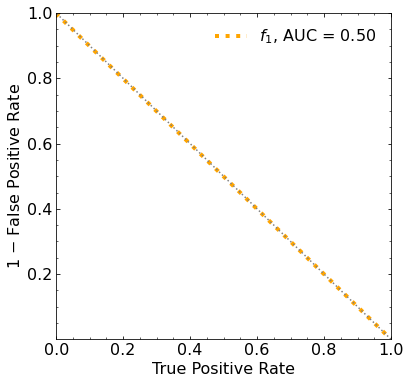

Classification score:


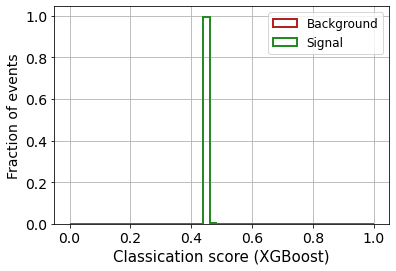


 ROC-AUC =  0.4992422558645364

-------------------------------


#################
thresh_1ML:  0.75
#################


X_mon_train_0:  (7464, 2744)
y_mon_train_0:  (7464,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 22
pred_XG_SM_test_0: 4801
pred_XG_NP_test_0: 661

X_mon_train_1:  (7536, 2744)
y_mon_train_1:  (7536,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7536
pred_XG_SM_train_1: 245
pred_XG_NP_train_1: 4293


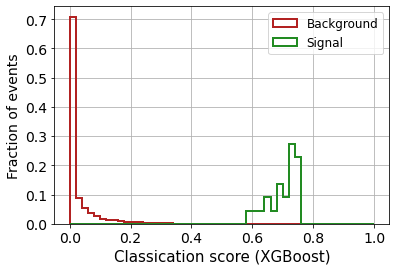

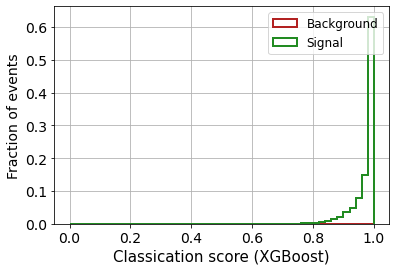

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff711861280>
Traceback (most recent call last):
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifi

[0]	validation_0-logloss:0.61082	validation_1-logloss:0.69626
[1]	validation_0-logloss:0.54353	validation_1-logloss:0.69741
[2]	validation_0-logloss:0.48598	validation_1-logloss:0.71184
[3]	validation_0-logloss:0.43733	validation_1-logloss:0.72234
[4]	validation_0-logloss:0.39389	validation_1-logloss:0.74729
[5]	validation_0-logloss:0.35583	validation_1-logloss:0.76758
[6]	validation_0-logloss:0.32348	validation_1-logloss:0.79850
[7]	validation_0-logloss:0.29422	validation_1-logloss:0.83027
[8]	validation_0-logloss:0.26477	validation_1-logloss:0.86147
[9]	validation_0-logloss:0.24152	validation_1-logloss:0.88978
[10]	validation_0-logloss:0.22092	validation_1-logloss:0.92659
[11]	validation_0-logloss:0.20245	validation_1-logloss:0.96064
[12]	validation_0-logloss:0.18346	validation_1-logloss:0.99812
[13]	validation_0-logloss:0.16657	validation_1-logloss:1.03597
[14]	validation_0-logloss:0.15262	validation_1-logloss:1.06602
[15]	validation_0-logloss:0.14023	validation_1-logloss:1.10643
[1

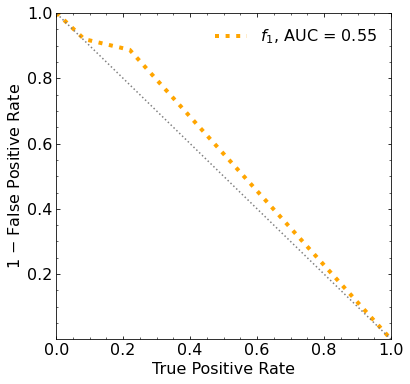

Classification score:


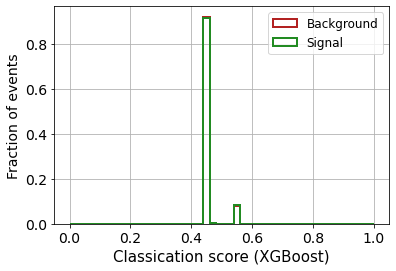


 ROC-AUC =  0.5495536742229863

-------------------------------


#################
thresh_1ML:  0.7916666666666666
#################


X_mon_train_0:  (7495, 2744)
y_mon_train_0:  (7495,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 53
pred_XG_SM_test_0: 4830
pred_XG_NP_test_0: 757

X_mon_train_1:  (7505, 2744)
y_mon_train_1:  (7505,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7505
pred_XG_SM_train_1: 216
pred_XG_NP_train_1: 4197


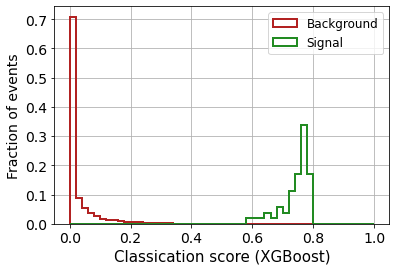

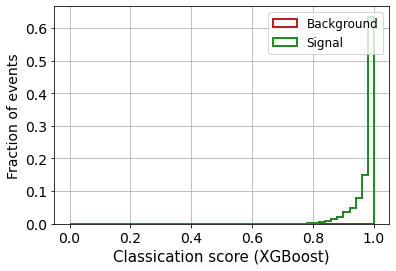

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff7117411f0>
Traceback (most recent call last):
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifi

[0]	validation_0-logloss:0.62336	validation_1-logloss:0.68557
[1]	validation_0-logloss:0.56456	validation_1-logloss:0.69076
[2]	validation_0-logloss:0.51463	validation_1-logloss:0.69486
[3]	validation_0-logloss:0.47096	validation_1-logloss:0.69922
[4]	validation_0-logloss:0.42962	validation_1-logloss:0.71239
[5]	validation_0-logloss:0.39306	validation_1-logloss:0.72996
[6]	validation_0-logloss:0.36105	validation_1-logloss:0.75021
[7]	validation_0-logloss:0.33411	validation_1-logloss:0.77152
[8]	validation_0-logloss:0.30681	validation_1-logloss:0.79046
[9]	validation_0-logloss:0.28264	validation_1-logloss:0.81756
[10]	validation_0-logloss:0.26153	validation_1-logloss:0.84554
[11]	validation_0-logloss:0.24171	validation_1-logloss:0.87494
[12]	validation_0-logloss:0.22465	validation_1-logloss:0.89434
[13]	validation_0-logloss:0.20906	validation_1-logloss:0.92272
[14]	validation_0-logloss:0.19480	validation_1-logloss:0.95667
[15]	validation_0-logloss:0.18010	validation_1-logloss:0.98832
[1

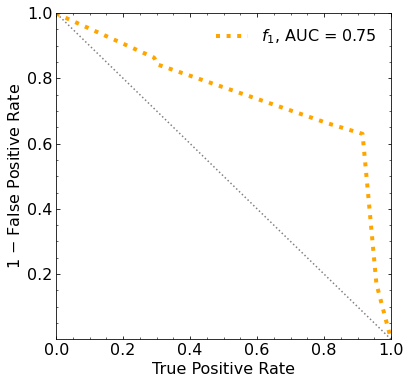

Classification score:


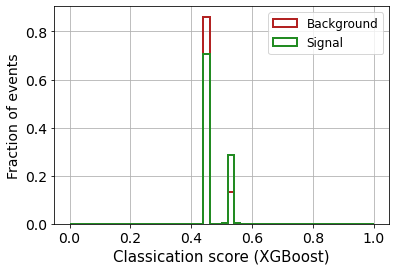


 ROC-AUC =  0.7509619414187216

-------------------------------


#################
thresh_1ML:  0.8333333333333333
#################


X_mon_train_0:  (7548, 2744)
y_mon_train_0:  (7548,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 106
pred_XG_SM_test_0: 4867
pred_XG_NP_test_0: 878

X_mon_train_1:  (7452, 2744)
y_mon_train_1:  (7452,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7452
pred_XG_SM_train_1: 179
pred_XG_NP_train_1: 4076


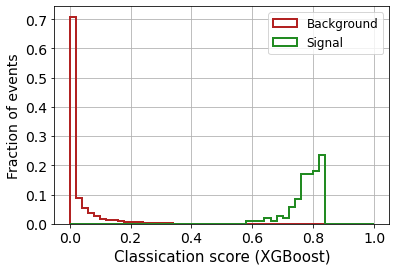

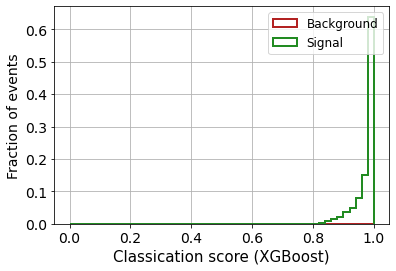

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff70bf803a0>
Traceback (most recent call last):
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifi

[0]	validation_0-logloss:0.62980	validation_1-logloss:0.68379
[1]	validation_0-logloss:0.57369	validation_1-logloss:0.68537
[2]	validation_0-logloss:0.52416	validation_1-logloss:0.68592
[3]	validation_0-logloss:0.48120	validation_1-logloss:0.69414
[4]	validation_0-logloss:0.44534	validation_1-logloss:0.69759
[5]	validation_0-logloss:0.41348	validation_1-logloss:0.70884
[6]	validation_0-logloss:0.38379	validation_1-logloss:0.72545
[7]	validation_0-logloss:0.35736	validation_1-logloss:0.73841
[8]	validation_0-logloss:0.33437	validation_1-logloss:0.75391
[9]	validation_0-logloss:0.31339	validation_1-logloss:0.77562
[10]	validation_0-logloss:0.29237	validation_1-logloss:0.79649
[11]	validation_0-logloss:0.27531	validation_1-logloss:0.81422
[12]	validation_0-logloss:0.25922	validation_1-logloss:0.82833
[13]	validation_0-logloss:0.24384	validation_1-logloss:0.84305
[14]	validation_0-logloss:0.23020	validation_1-logloss:0.86793
[15]	validation_0-logloss:0.21844	validation_1-logloss:0.88947
[1

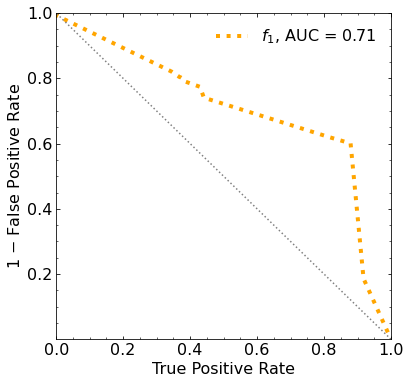

Classification score:


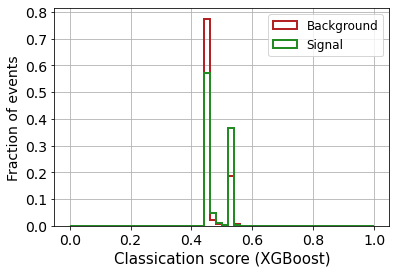


 ROC-AUC =  0.7052586930957837

-------------------------------


#################
thresh_1ML:  0.875
#################


X_mon_train_0:  (7708, 2744)
y_mon_train_0:  (7708,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 266
pred_XG_SM_test_0: 4908
pred_XG_NP_test_0: 1046

X_mon_train_1:  (7292, 2744)
y_mon_train_1:  (7292,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7292
pred_XG_SM_train_1: 138
pred_XG_NP_train_1: 3908


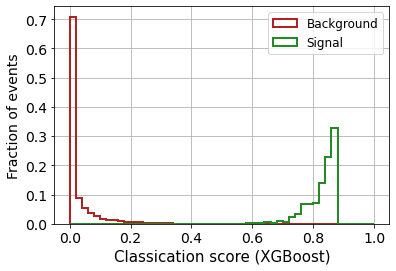

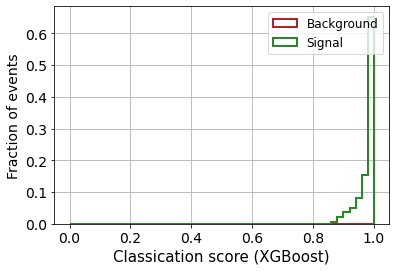

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff7116d7790>
Traceback (most recent call last):
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifi

[0]	validation_0-logloss:0.63957	validation_1-logloss:0.67717
[1]	validation_0-logloss:0.59634	validation_1-logloss:0.67025
[2]	validation_0-logloss:0.55615	validation_1-logloss:0.66781
[3]	validation_0-logloss:0.52243	validation_1-logloss:0.66205
[4]	validation_0-logloss:0.49082	validation_1-logloss:0.66907
[5]	validation_0-logloss:0.46373	validation_1-logloss:0.67554
[6]	validation_0-logloss:0.43910	validation_1-logloss:0.68437
[7]	validation_0-logloss:0.41627	validation_1-logloss:0.68777
[8]	validation_0-logloss:0.39482	validation_1-logloss:0.69662
[9]	validation_0-logloss:0.37680	validation_1-logloss:0.70721
[10]	validation_0-logloss:0.35922	validation_1-logloss:0.71125
[11]	validation_0-logloss:0.34194	validation_1-logloss:0.71572
[12]	validation_0-logloss:0.32576	validation_1-logloss:0.72805
[13]	validation_0-logloss:0.31239	validation_1-logloss:0.74169
[14]	validation_0-logloss:0.29880	validation_1-logloss:0.75521
[15]	validation_0-logloss:0.28546	validation_1-logloss:0.76179
[1

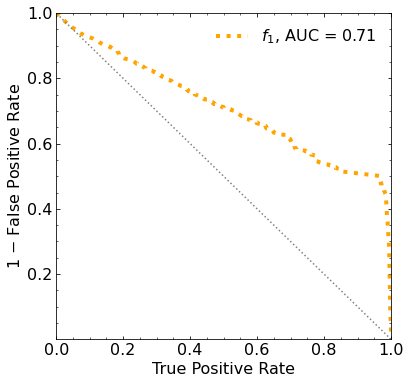

Classification score:


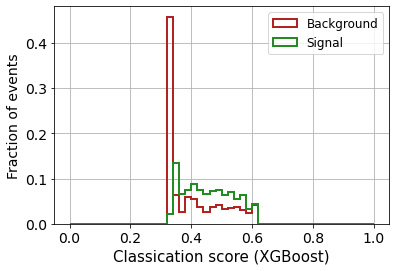


 ROC-AUC =  0.7101608680158689

-------------------------------


#################
thresh_1ML:  0.9166666666666666
#################


X_mon_train_0:  (8121, 2744)
y_mon_train_0:  (8121,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 679
pred_XG_SM_test_0: 4944
pred_XG_NP_test_0: 1282

X_mon_train_1:  (6879, 2744)
y_mon_train_1:  (6879,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 6879
pred_XG_SM_train_1: 102
pred_XG_NP_train_1: 3672


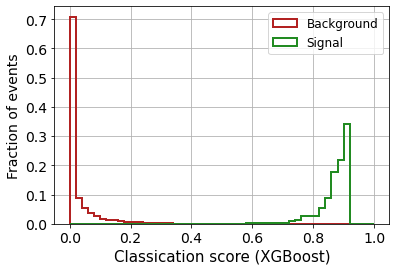

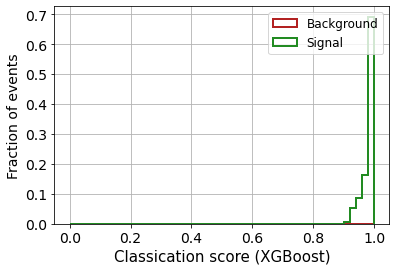

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff7117401f0>
Traceback (most recent call last):
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifi

[0]	validation_0-logloss:0.64817	validation_1-logloss:0.67000
[1]	validation_0-logloss:0.61026	validation_1-logloss:0.65045
[2]	validation_0-logloss:0.57746	validation_1-logloss:0.63655
[3]	validation_0-logloss:0.54724	validation_1-logloss:0.62425
[4]	validation_0-logloss:0.52124	validation_1-logloss:0.61752
[5]	validation_0-logloss:0.49722	validation_1-logloss:0.61325
[6]	validation_0-logloss:0.47517	validation_1-logloss:0.61099
[7]	validation_0-logloss:0.45516	validation_1-logloss:0.60660
[8]	validation_0-logloss:0.43657	validation_1-logloss:0.60484
[9]	validation_0-logloss:0.41967	validation_1-logloss:0.59789
[10]	validation_0-logloss:0.40392	validation_1-logloss:0.59725
[11]	validation_0-logloss:0.38962	validation_1-logloss:0.59831
[12]	validation_0-logloss:0.37569	validation_1-logloss:0.59633
[13]	validation_0-logloss:0.36337	validation_1-logloss:0.59390
[14]	validation_0-logloss:0.35090	validation_1-logloss:0.59450
[15]	validation_0-logloss:0.33840	validation_1-logloss:0.59692
[1

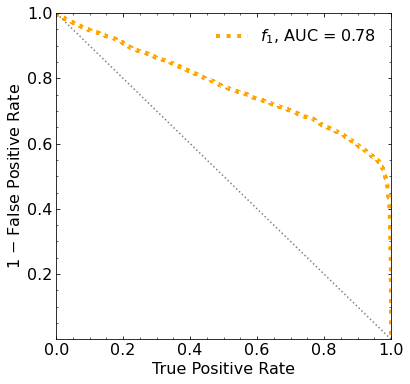

Classification score:


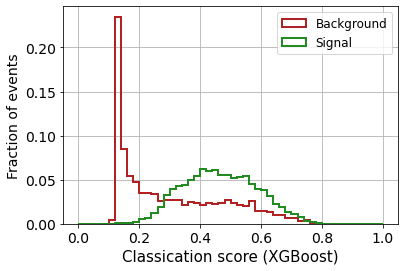


 ROC-AUC =  0.7750658615745237

-------------------------------


#################
thresh_1ML:  0.9583333333333333
#################


X_mon_train_0:  (9054, 2744)
y_mon_train_0:  (9054,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 1612
pred_XG_SM_test_0: 4986
pred_XG_NP_test_0: 1784

X_mon_train_1:  (5946, 2744)
y_mon_train_1:  (5946,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 5946
pred_XG_SM_train_1: 60
pred_XG_NP_train_1: 3170


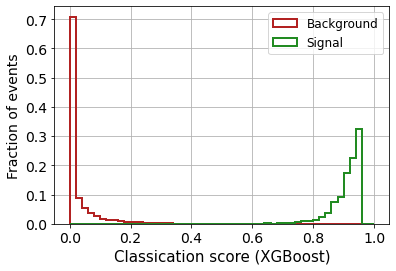

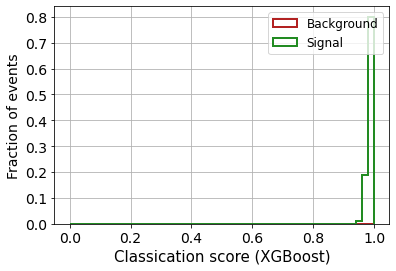

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff70de331f0>
Traceback (most recent call last):
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifi

[0]	validation_0-logloss:0.65292	validation_1-logloss:0.65949
[1]	validation_0-logloss:0.61739	validation_1-logloss:0.62916
[2]	validation_0-logloss:0.58790	validation_1-logloss:0.60648
[3]	validation_0-logloss:0.56062	validation_1-logloss:0.58599
[4]	validation_0-logloss:0.53647	validation_1-logloss:0.56970
[5]	validation_0-logloss:0.51558	validation_1-logloss:0.55419
[6]	validation_0-logloss:0.49670	validation_1-logloss:0.54087
[7]	validation_0-logloss:0.47952	validation_1-logloss:0.53163
[8]	validation_0-logloss:0.46335	validation_1-logloss:0.52262
[9]	validation_0-logloss:0.44847	validation_1-logloss:0.51476
[10]	validation_0-logloss:0.43475	validation_1-logloss:0.50757
[11]	validation_0-logloss:0.42233	validation_1-logloss:0.49905
[12]	validation_0-logloss:0.40978	validation_1-logloss:0.49497
[13]	validation_0-logloss:0.39830	validation_1-logloss:0.49160
[14]	validation_0-logloss:0.38793	validation_1-logloss:0.48622
[15]	validation_0-logloss:0.37790	validation_1-logloss:0.48325
[1

[130]	validation_0-logloss:0.07535	validation_1-logloss:0.35673
[131]	validation_0-logloss:0.07466	validation_1-logloss:0.35663
[132]	validation_0-logloss:0.07378	validation_1-logloss:0.35555
[133]	validation_0-logloss:0.07306	validation_1-logloss:0.35529
[134]	validation_0-logloss:0.07247	validation_1-logloss:0.35400
[135]	validation_0-logloss:0.07165	validation_1-logloss:0.35281
[136]	validation_0-logloss:0.07100	validation_1-logloss:0.35219
[137]	validation_0-logloss:0.07037	validation_1-logloss:0.35143
[138]	validation_0-logloss:0.06942	validation_1-logloss:0.35123
[139]	validation_0-logloss:0.06880	validation_1-logloss:0.34987
[140]	validation_0-logloss:0.06802	validation_1-logloss:0.34909
[141]	validation_0-logloss:0.06736	validation_1-logloss:0.34906
[142]	validation_0-logloss:0.06692	validation_1-logloss:0.34826
[143]	validation_0-logloss:0.06632	validation_1-logloss:0.34879
[144]	validation_0-logloss:0.06546	validation_1-logloss:0.34715
[145]	validation_0-logloss:0.06498	valid

[259]	validation_0-logloss:0.02756	validation_1-logloss:0.32632
[260]	validation_0-logloss:0.02728	validation_1-logloss:0.32574
[261]	validation_0-logloss:0.02708	validation_1-logloss:0.32617
[262]	validation_0-logloss:0.02685	validation_1-logloss:0.32598
[263]	validation_0-logloss:0.02661	validation_1-logloss:0.32435
[264]	validation_0-logloss:0.02647	validation_1-logloss:0.32474
[265]	validation_0-logloss:0.02632	validation_1-logloss:0.32583
[266]	validation_0-logloss:0.02609	validation_1-logloss:0.32564
[267]	validation_0-logloss:0.02590	validation_1-logloss:0.32591
[268]	validation_0-logloss:0.02577	validation_1-logloss:0.32564
[269]	validation_0-logloss:0.02548	validation_1-logloss:0.32563
[270]	validation_0-logloss:0.02529	validation_1-logloss:0.32638
[271]	validation_0-logloss:0.02514	validation_1-logloss:0.32597
[272]	validation_0-logloss:0.02502	validation_1-logloss:0.32543
[273]	validation_0-logloss:0.02486	validation_1-logloss:0.32553
[274]	validation_0-logloss:0.02468	valid

[388]	validation_0-logloss:0.01193	validation_1-logloss:0.31748
[389]	validation_0-logloss:0.01191	validation_1-logloss:0.31718
[390]	validation_0-logloss:0.01184	validation_1-logloss:0.31717
[391]	validation_0-logloss:0.01178	validation_1-logloss:0.31764
[392]	validation_0-logloss:0.01174	validation_1-logloss:0.31755
[393]	validation_0-logloss:0.01166	validation_1-logloss:0.31722
[394]	validation_0-logloss:0.01159	validation_1-logloss:0.31744
[395]	validation_0-logloss:0.01153	validation_1-logloss:0.31760
[396]	validation_0-logloss:0.01145	validation_1-logloss:0.31770
[397]	validation_0-logloss:0.01136	validation_1-logloss:0.31779
[398]	validation_0-logloss:0.01129	validation_1-logloss:0.31746
[399]	validation_0-logloss:0.01121	validation_1-logloss:0.31748
[400]	validation_0-logloss:0.01115	validation_1-logloss:0.31670
[401]	validation_0-logloss:0.01105	validation_1-logloss:0.31663
[402]	validation_0-logloss:0.01098	validation_1-logloss:0.31700
[403]	validation_0-logloss:0.01092	valid

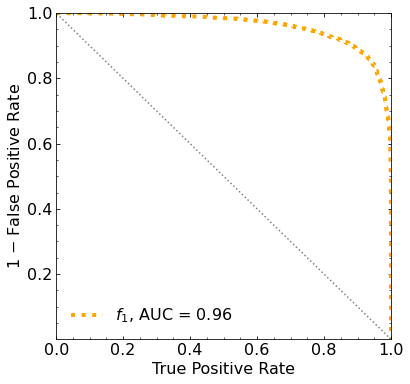

Classification score:


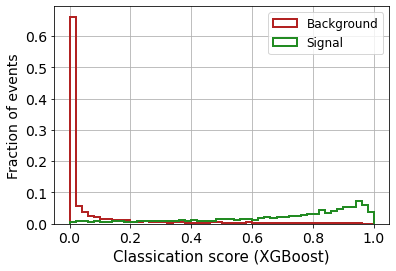


 ROC-AUC =  0.9598350804412085

-------------------------------


#################
thresh_1ML:  1.0
#################


X_mon_train_0:  (15000, 2744)
y_mon_train_0:  (15000,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 7558
pred_XG_SM_test_0: 5046
pred_XG_NP_test_0: 4954

X_mon_train_1:  (0,)
y_mon_train_1:  (0,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 0
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 0


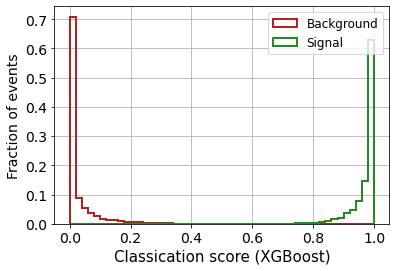

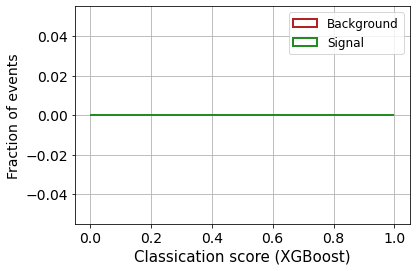

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff76d6daca0>
Traceback (most recent call last):
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifi

[0]	validation_0-logloss:0.64294	validation_1-logloss:0.64636
[1]	validation_0-logloss:0.59995	validation_1-logloss:0.60555
[2]	validation_0-logloss:0.56286	validation_1-logloss:0.57137
[3]	validation_0-logloss:0.53031	validation_1-logloss:0.54178
[4]	validation_0-logloss:0.50345	validation_1-logloss:0.51759
[5]	validation_0-logloss:0.47963	validation_1-logloss:0.49512
[6]	validation_0-logloss:0.45748	validation_1-logloss:0.47509
[7]	validation_0-logloss:0.43827	validation_1-logloss:0.45773
[8]	validation_0-logloss:0.42009	validation_1-logloss:0.44218
[9]	validation_0-logloss:0.40379	validation_1-logloss:0.42812
[10]	validation_0-logloss:0.38877	validation_1-logloss:0.41507
[11]	validation_0-logloss:0.37563	validation_1-logloss:0.40412
[12]	validation_0-logloss:0.36370	validation_1-logloss:0.39391
[13]	validation_0-logloss:0.35192	validation_1-logloss:0.38437
[14]	validation_0-logloss:0.34115	validation_1-logloss:0.37581
[15]	validation_0-logloss:0.33121	validation_1-logloss:0.36758
[1

[130]	validation_0-logloss:0.06429	validation_1-logloss:0.19315
[131]	validation_0-logloss:0.06395	validation_1-logloss:0.19302
[132]	validation_0-logloss:0.06325	validation_1-logloss:0.19281
[133]	validation_0-logloss:0.06270	validation_1-logloss:0.19267
[134]	validation_0-logloss:0.06233	validation_1-logloss:0.19223
[135]	validation_0-logloss:0.06196	validation_1-logloss:0.19238
[136]	validation_0-logloss:0.06158	validation_1-logloss:0.19227
[137]	validation_0-logloss:0.06116	validation_1-logloss:0.19215
[138]	validation_0-logloss:0.06081	validation_1-logloss:0.19200
[139]	validation_0-logloss:0.06030	validation_1-logloss:0.19190
[140]	validation_0-logloss:0.05997	validation_1-logloss:0.19143
[141]	validation_0-logloss:0.05935	validation_1-logloss:0.19127
[142]	validation_0-logloss:0.05865	validation_1-logloss:0.19099
[143]	validation_0-logloss:0.05830	validation_1-logloss:0.19102
[144]	validation_0-logloss:0.05776	validation_1-logloss:0.19068
[145]	validation_0-logloss:0.05732	valid

[259]	validation_0-logloss:0.02482	validation_1-logloss:0.18664
[260]	validation_0-logloss:0.02467	validation_1-logloss:0.18646
[261]	validation_0-logloss:0.02448	validation_1-logloss:0.18647
[262]	validation_0-logloss:0.02419	validation_1-logloss:0.18646
[263]	validation_0-logloss:0.02409	validation_1-logloss:0.18665
[264]	validation_0-logloss:0.02386	validation_1-logloss:0.18685
[265]	validation_0-logloss:0.02373	validation_1-logloss:0.18683
[266]	validation_0-logloss:0.02362	validation_1-logloss:0.18668
[267]	validation_0-logloss:0.02350	validation_1-logloss:0.18658
[268]	validation_0-logloss:0.02334	validation_1-logloss:0.18667
[269]	validation_0-logloss:0.02327	validation_1-logloss:0.18672
[270]	validation_0-logloss:0.02319	validation_1-logloss:0.18677
[271]	validation_0-logloss:0.02305	validation_1-logloss:0.18681
[272]	validation_0-logloss:0.02289	validation_1-logloss:0.18674
[273]	validation_0-logloss:0.02269	validation_1-logloss:0.18695


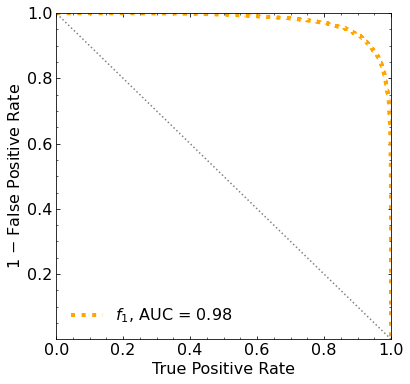

Classification score:


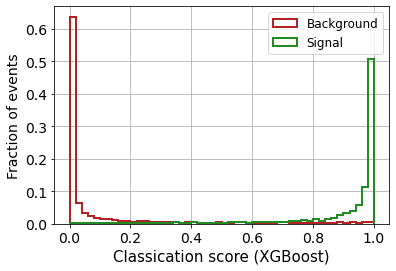


 ROC-AUC =  0.9768454001946726

-------------------------------



In [37]:
y_pred_xg_train = classifier.predict_proba(X_mon_train).T[1]

thresh_1ML = np.linspace(0,1,25)

print('ML Output threshold: ', thresh_1ML)


save_SsqrtB_2ML = []
save_auc = []

for it_1ML in range(len(thresh_1ML)):
    
    print('\n#################')
    print('thresh_1ML: ', thresh_1ML[it_1ML])
    print('#################\n')
    
    # TRAIN SET #

    X_mon_train_0 = []
    y_mon_train_0 = []
    pred_XG_SM_train_0 = []
    pred_XG_NP_train_0 = []

    X_mon_train_1 = []
    y_mon_train_1 = []
    pred_XG_SM_train_1 = []
    pred_XG_NP_train_1 = []

    for i in range(len(y_mon_train)):
        if y_pred_xg_train[i] < thresh_1ML[it_1ML]:
            X_mon_train_0.append(X_mon_train[i].tolist())
            y_mon_train_0.append(int(y_mon_train[i].tolist()))

            if y_mon_train[i] == 0:
                pred_XG_SM_train_0.append(y_pred_xg_train[i])
            else:
                pred_XG_NP_train_0.append(y_pred_xg_train[i])

        else:
            X_mon_train_1.append(X_mon_train[i].tolist())
            y_mon_train_1.append(int(y_mon_train[i].tolist()))

            if y_mon_train[i] == 0:
                pred_XG_SM_train_1.append(y_pred_xg_train[i])
            else:
                pred_XG_NP_train_1.append(y_pred_xg_train[i])

    X_mon_train_0 = np.asarray(X_mon_train_0)
    y_mon_train_0 = np.asarray(y_mon_train_0)
    X_mon_train_1 = np.asarray(X_mon_train_1)
    y_mon_train_1 = np.asarray(y_mon_train_1)



    # TEST SET #

    pred_XG_SM_test_0 = []
    pred_XG_NP_test_0 = []

    pred_XG_SM_test_1 = []
    pred_XG_NP_test_1 = []

    for i in range(len(y_mon_test)):
        if y_pred_xg[i] < thresh_1ML[it_1ML]:
            if y_mon_test[i] == 0:
                pred_XG_SM_test_0.append(y_pred_xg[i])
            else:
                pred_XG_NP_test_0.append(y_pred_xg[i])

        else:
            if y_mon_test[i] == 0:
                pred_XG_SM_test_1.append(y_pred_xg[i])
            else:
                pred_XG_NP_test_1.append(y_pred_xg[i])


    print('\nX_mon_train_0: ', X_mon_train_0.shape)
    print('y_mon_train_0: ', y_mon_train_0.shape)
    print('pred_XG_SM_train_0:', len(pred_XG_SM_train_0))
    print('pred_XG_NP_train_0:', len(pred_XG_NP_train_0))
    print('pred_XG_SM_test_0:', len(pred_XG_SM_test_0))
    print('pred_XG_NP_test_0:', len(pred_XG_NP_test_0))

    print('\nX_mon_train_1: ', X_mon_train_1.shape)
    print('y_mon_train_1: ', y_mon_train_1.shape)
    print('pred_XG_SM_train_1:', len(pred_XG_SM_train_1))
    print('pred_XG_NP_train_1:', len(pred_XG_NP_train_1))
    print('pred_XG_SM_train_1:', len(pred_XG_SM_test_1))
    print('pred_XG_NP_train_1:', len(pred_XG_NP_test_1))




    weights = np.ones_like(pred_XG_SM_train_0)/float(len(pred_XG_SM_train_0))
    plt.hist(pred_XG_SM_train_0, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

    weights = np.ones_like(pred_XG_NP_train_0)/float(len(pred_XG_NP_train_0))
    plt.hist(pred_XG_NP_train_0, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Classication score (XGBoost)",fontsize=15)
    plt.ylabel("Fraction of events",fontsize=14)
    plt.grid()
    plt.legend(fontsize=12)

    plt.show()



    weights = np.ones_like(pred_XG_SM_train_1)/float(len(pred_XG_SM_train_1))
    plt.hist(pred_XG_SM_train_1, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

    weights = np.ones_like(pred_XG_NP_train_1)/float(len(pred_XG_NP_train_1))
    plt.hist(pred_XG_NP_train_1, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Classication score (XGBoost)",fontsize=15)
    plt.ylabel("Fraction of events",fontsize=14)
    plt.grid()
    plt.legend(fontsize=12)

    plt.show()
    
    
    
    if len(pred_XG_SM_train_0) > 0 and len(pred_XG_NP_train_0) > 0:
        
        if sum(y_mon_train_0) > 10 and (len(y_mon_train_0) - sum(y_mon_train_0) ) > 10:
            oversample = SMOTE()
            X_mon_train_0, y_mon_train_0 = oversample.fit_resample(X_mon_train_0, y_mon_train_0)


        # CLASSIFIER #


        # XGBoost with only the kinematic variables of the leptons

        # CLASSIFIER
        classifier_2ML = XGBClassifier(
            n_estimators=1500,
            learning_rate=0.1,
            reg_lambda=0.0,reg_alpha=0.0,
            gamma=0.0,objective='binary:logistic',
            max_depth=5,
            #eval_metric=["error", "logloss", "map"]
            eval_metric='logloss')

        # FIT
        classifier_2ML.fit(X_mon_train_0,y_mon_train_0,eval_set=[(X_mon_train_0, y_mon_train_0), (X_mon_val, y_mon_val)],
                early_stopping_rounds=50,#early stopping
                verbose=True)


        # PREDICTIONS
        y_pred_xg_2ML = classifier_2ML.predict_proba(X_mon_test).T[1]


        # ROC
        fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg_2ML)
        roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)
        
        save_auc.append( roc_auc_xg )


        # PLOT THE ROC WITH AUC
        fig = plt.figure(figsize=(6, 6))
        gs = gridspec.GridSpec(1, 1) 
        ax0 = plt.subplot(gs[0])
        ax0.yaxis.set_ticks_position('both')
        ax0.xaxis.set_ticks_position('both')
        ax0.tick_params(direction="in",which="both")
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        ax0.minorticks_on()


        plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
        plt.plot([1,0],[0,1],ls=":",color="grey")
        plt.xlabel("True Positive Rate",fontsize=16)
        plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
        plt.legend()
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.yticks([0.2,0.4,0.6,0.8,1.])
        plt.legend(frameon=False,fontsize=16)
        plt.show()



        # XGBoost with the kinematic variables of the leptons

        ########################
        # CLASSIFICATION SCORE #
        ########################

        # Outputs for validation data set

        pred_XG_SM = []
        pred_XG_NP = []

        for i in range(len(y_mon_test)):
            if y_mon_test[i] == 0:
                pred_XG_SM.append(y_pred_xg_2ML[i])
            else:
                pred_XG_NP.append(y_pred_xg_2ML[i])


        print('Classification score:')

        weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
        nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

        weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
        nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Classication score (XGBoost)",fontsize=15)
        plt.ylabel("Fraction of events",fontsize=14)
        plt.grid()
        plt.legend(fontsize=12)

        plt.show()




        print('\n ROC-AUC = ', roc_auc_xg)




        thresh_2ML = np.linspace(0,1,20)

        B_thresh = []
        S_thresh = []

        for it_2ML in range(len(thresh_2ML)):

            # TEST SET #

            pred_XG_SM_test_0 = []
            pred_XG_NP_test_0 = []

            pred_XG_SM_test_1 = []
            pred_XG_NP_test_1 = []

            for i in range(len(y_mon_test)):
                if y_pred_xg_2ML[i] < thresh_2ML[it_2ML]:
                    if y_mon_test[i] == 0:
                        pred_XG_SM_test_0.append(y_pred_xg_2ML[i])
                    else:
                        pred_XG_NP_test_0.append(y_pred_xg_2ML[i])

                else:
                    if y_mon_test[i] == 0:
                        pred_XG_SM_test_1.append(y_pred_xg_2ML[i])
                    else:
                        pred_XG_NP_test_1.append(y_pred_xg_2ML[i])

#             print('\nthresh: ', thresh_2ML[it_2ML])
    #         print('len(pred_XG_SM_test_1): ', len(pred_XG_SM_test_1))
    #         print('len(pred_XG_NP_test_1): ', len(pred_XG_NP_test_1))
            B_thresh.append(len(pred_XG_SM_test_1))
            S_thresh.append(len(pred_XG_NP_test_1))


        SsqrtB_2ML = []

        for i in range(len(B_thresh)):
            if B_thresh[i] >= 3:
                SsqrtB_2ML.append( S_thresh[i]/np.sqrt(B_thresh[i]) )
            else:
                SsqrtB_2ML.append(None)


        save_SsqrtB_2ML.append(SsqrtB_2ML)
        
        
        
    else:
        
        SsqrtB_2ML = []
        for it_2ML in range(20):
            SsqrtB_2ML.append(None)
            
            
        save_SsqrtB_2ML.append(SsqrtB_2ML)
        save_auc.append( None )
        
    
    
    print('\n-------------------------------\n')

roc_auc_only1ML:  0.9768742426358966


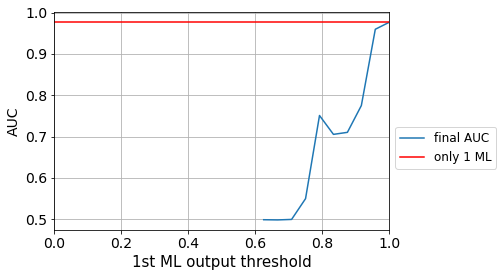

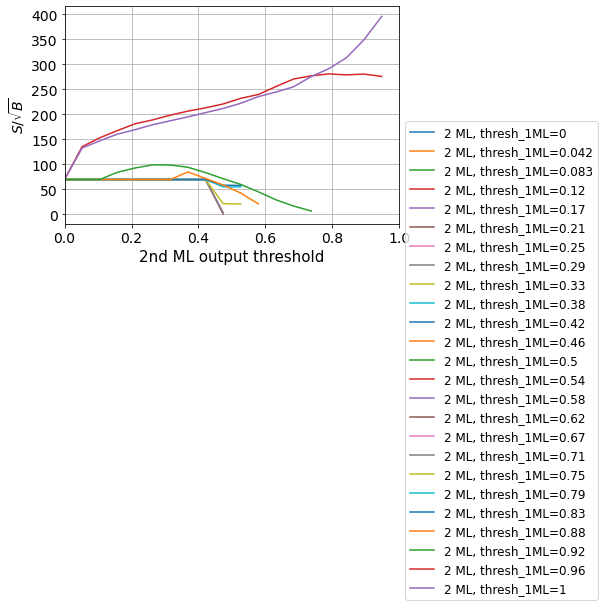

In [38]:
print('roc_auc_only1ML: ', roc_auc_only1ML)


plt.plot(thresh_1ML, save_auc, label='final AUC')

plt.axhline(y=roc_auc_only1ML, c='red', label='only 1 ML')
plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("1st ML output threshold",fontsize=15)
plt.ylabel("AUC",fontsize=14)
plt.grid()
plt.legend(fontsize=12, bbox_to_anchor=(1, 0.5))

plt.show()




# plt.plot(thresh, SsqrtB, ':', lw=4, label='1 ML')
for i in range(len(thresh_1ML)):
    plt.plot(thresh_2ML, save_SsqrtB_2ML[i], label='2 ML, thresh_1ML=%.2g' % thresh_1ML[i])

plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("2nd ML output threshold",fontsize=15)
plt.ylabel("$S/\sqrt{B}$",fontsize=14)
plt.grid()
plt.legend(fontsize=12, bbox_to_anchor=(1, 0.5))

plt.show()

### Option B

ML Output threshold:  [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]

#################
thresh_1ML:  0.0
#################


X_mon_train_0:  (0,)
y_mon_train_0:  (0,)
pred_XG_SM_train_0: 0
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 0
pred_XG_NP_test_0: 0

X_mon_train_1:  (15000, 2744)
y_mon_train_1:  (15000,)
pred_XG_SM_train_1: 7442
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 5046
pred_XG_NP_train_1: 4954


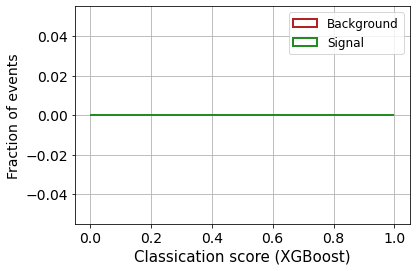

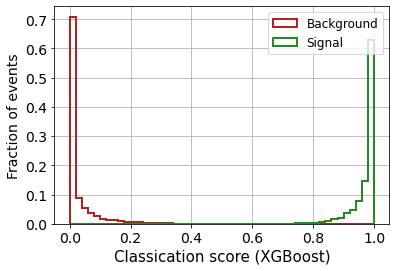


-------------------------------


#################
thresh_1ML:  0.041666666666666664
#################


X_mon_train_0:  (5967, 2744)
y_mon_train_0:  (5967,)
pred_XG_SM_train_0: 5967
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 3567
pred_XG_NP_test_0: 29

X_mon_train_1:  (9033, 2744)
y_mon_train_1:  (9033,)
pred_XG_SM_train_1: 1475
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 1479
pred_XG_NP_train_1: 4925


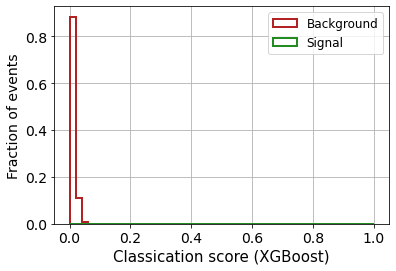

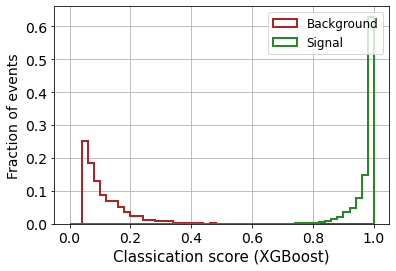


-------------------------------


#################
thresh_1ML:  0.08333333333333333
#################


X_mon_train_0:  (6648, 2744)
y_mon_train_0:  (6648,)
pred_XG_SM_train_0: 6648
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 3856
pred_XG_NP_test_0: 59

X_mon_train_1:  (8352, 2744)
y_mon_train_1:  (8352,)
pred_XG_SM_train_1: 794
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 1190
pred_XG_NP_train_1: 4895


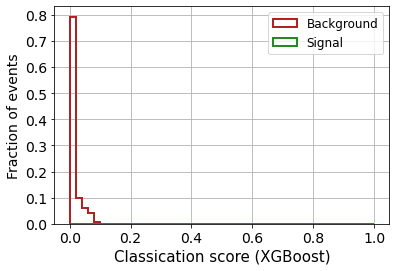

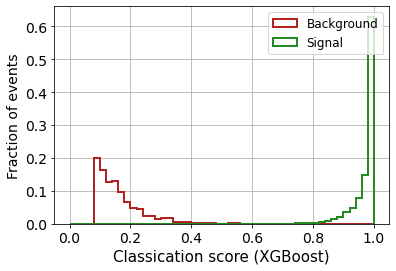


-------------------------------


#################
thresh_1ML:  0.125
#################


X_mon_train_0:  (6969, 2744)
y_mon_train_0:  (6969,)
pred_XG_SM_train_0: 6969
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4030
pred_XG_NP_test_0: 83

X_mon_train_1:  (8031, 2744)
y_mon_train_1:  (8031,)
pred_XG_SM_train_1: 473
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 1016
pred_XG_NP_train_1: 4871


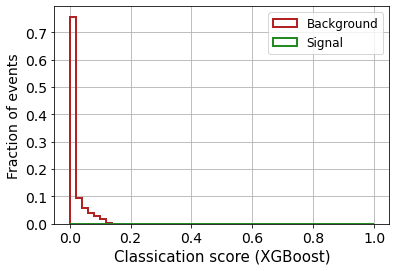

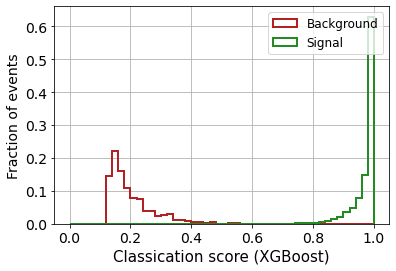


-------------------------------


#################
thresh_1ML:  0.16666666666666666
#################


X_mon_train_0:  (7162, 2744)
y_mon_train_0:  (7162,)
pred_XG_SM_train_0: 7162
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4151
pred_XG_NP_test_0: 108

X_mon_train_1:  (7838, 2744)
y_mon_train_1:  (7838,)
pred_XG_SM_train_1: 280
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 895
pred_XG_NP_train_1: 4846


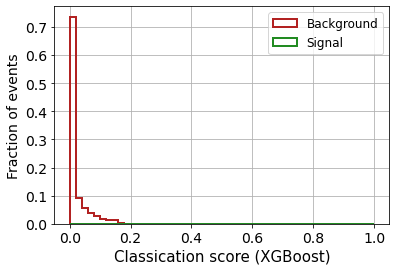

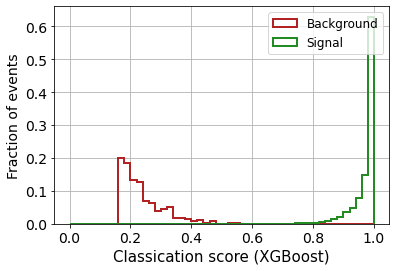


-------------------------------


#################
thresh_1ML:  0.20833333333333331
#################


X_mon_train_0:  (7289, 2744)
y_mon_train_0:  (7289,)
pred_XG_SM_train_0: 7289
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4220
pred_XG_NP_test_0: 139

X_mon_train_1:  (7711, 2744)
y_mon_train_1:  (7711,)
pred_XG_SM_train_1: 153
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 826
pred_XG_NP_train_1: 4815


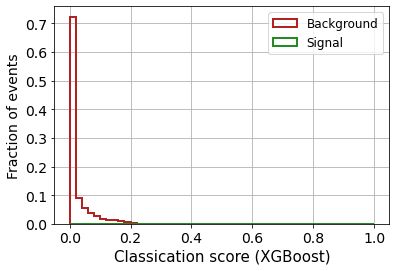

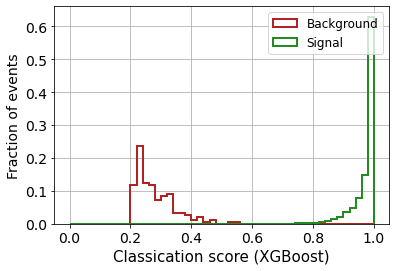


-------------------------------


#################
thresh_1ML:  0.25
#################


X_mon_train_0:  (7356, 2744)
y_mon_train_0:  (7356,)
pred_XG_SM_train_0: 7356
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4294
pred_XG_NP_test_0: 174

X_mon_train_1:  (7644, 2744)
y_mon_train_1:  (7644,)
pred_XG_SM_train_1: 86
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 752
pred_XG_NP_train_1: 4780


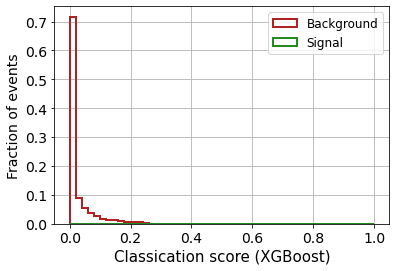

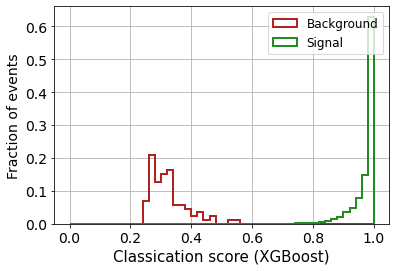


-------------------------------


#################
thresh_1ML:  0.29166666666666663
#################


X_mon_train_0:  (7389, 2744)
y_mon_train_0:  (7389,)
pred_XG_SM_train_0: 7389
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4360
pred_XG_NP_test_0: 205

X_mon_train_1:  (7611, 2744)
y_mon_train_1:  (7611,)
pred_XG_SM_train_1: 53
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 686
pred_XG_NP_train_1: 4749


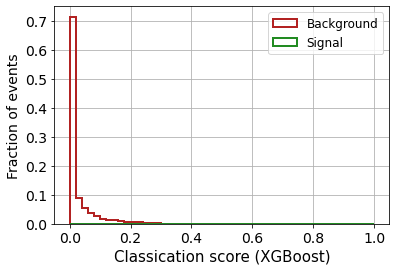

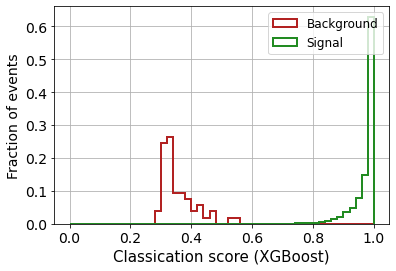


-------------------------------


#################
thresh_1ML:  0.3333333333333333
#################


X_mon_train_0:  (7414, 2744)
y_mon_train_0:  (7414,)
pred_XG_SM_train_0: 7414
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4422
pred_XG_NP_test_0: 226

X_mon_train_1:  (7586, 2744)
y_mon_train_1:  (7586,)
pred_XG_SM_train_1: 28
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 624
pred_XG_NP_train_1: 4728


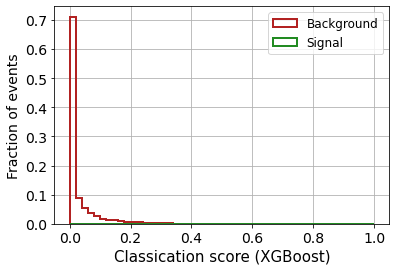

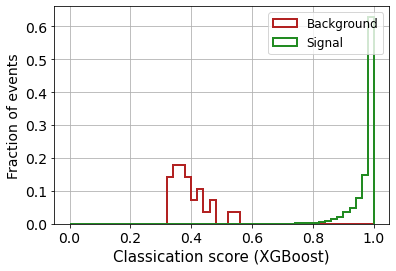


-------------------------------


#################
thresh_1ML:  0.375
#################


X_mon_train_0:  (7426, 2744)
y_mon_train_0:  (7426,)
pred_XG_SM_train_0: 7426
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4465
pred_XG_NP_test_0: 263

X_mon_train_1:  (7574, 2744)
y_mon_train_1:  (7574,)
pred_XG_SM_train_1: 16
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 581
pred_XG_NP_train_1: 4691


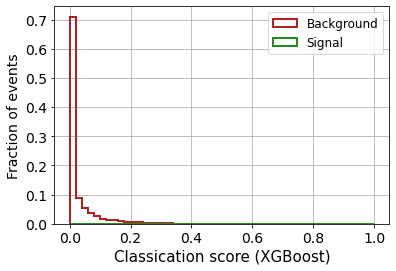

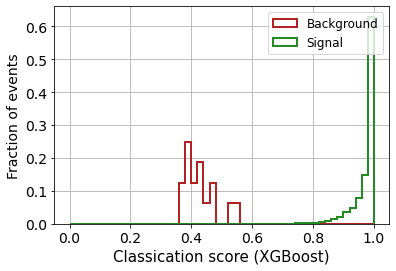


-------------------------------


#################
thresh_1ML:  0.41666666666666663
#################


X_mon_train_0:  (7434, 2744)
y_mon_train_0:  (7434,)
pred_XG_SM_train_0: 7434
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4516
pred_XG_NP_test_0: 296

X_mon_train_1:  (7566, 2744)
y_mon_train_1:  (7566,)
pred_XG_SM_train_1: 8
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 530
pred_XG_NP_train_1: 4658


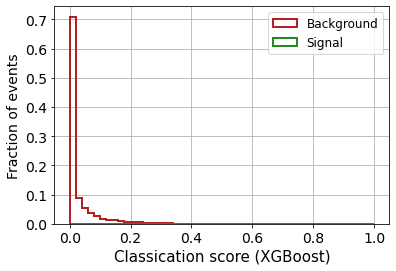

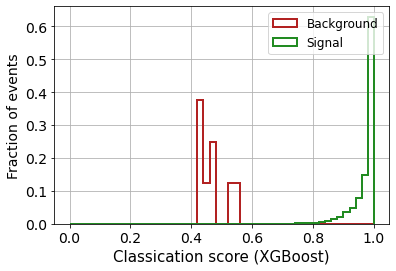


-------------------------------


#################
thresh_1ML:  0.4583333333333333
#################


X_mon_train_0:  (7438, 2744)
y_mon_train_0:  (7438,)
pred_XG_SM_train_0: 7438
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4559
pred_XG_NP_test_0: 320

X_mon_train_1:  (7562, 2744)
y_mon_train_1:  (7562,)
pred_XG_SM_train_1: 4
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 487
pred_XG_NP_train_1: 4634


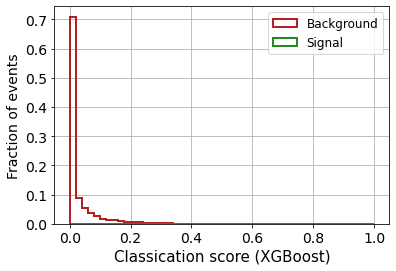

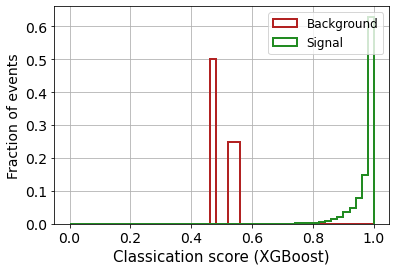


-------------------------------


#################
thresh_1ML:  0.5
#################


X_mon_train_0:  (7440, 2744)
y_mon_train_0:  (7440,)
pred_XG_SM_train_0: 7440
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4605
pred_XG_NP_test_0: 353

X_mon_train_1:  (7560, 2744)
y_mon_train_1:  (7560,)
pred_XG_SM_train_1: 2
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 441
pred_XG_NP_train_1: 4601


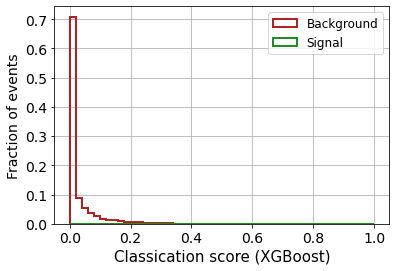

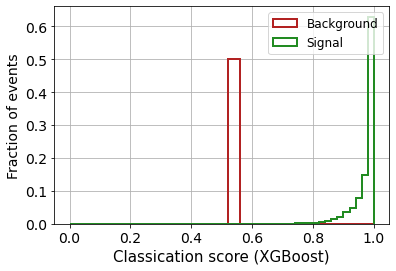


-------------------------------


#################
thresh_1ML:  0.5416666666666666
#################


X_mon_train_0:  (7442, 2744)
y_mon_train_0:  (7442,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4634
pred_XG_NP_test_0: 390

X_mon_train_1:  (7558, 2744)
y_mon_train_1:  (7558,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 412
pred_XG_NP_train_1: 4564


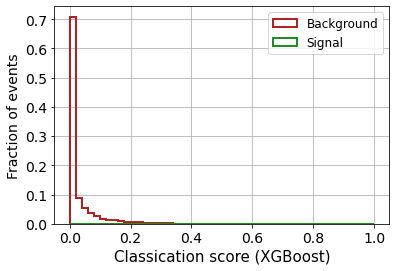

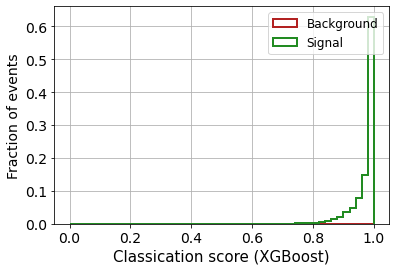


-------------------------------


#################
thresh_1ML:  0.5833333333333333
#################


X_mon_train_0:  (7442, 2744)
y_mon_train_0:  (7442,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 0
pred_XG_SM_test_0: 4668
pred_XG_NP_test_0: 432

X_mon_train_1:  (7558, 2744)
y_mon_train_1:  (7558,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7558
pred_XG_SM_train_1: 378
pred_XG_NP_train_1: 4522


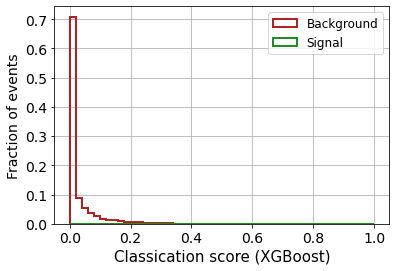

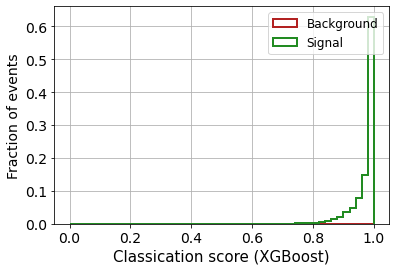


-------------------------------


#################
thresh_1ML:  0.625
#################


X_mon_train_0:  (7444, 2744)
y_mon_train_0:  (7444,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 2
pred_XG_SM_test_0: 4700
pred_XG_NP_test_0: 479

X_mon_train_1:  (7556, 2744)
y_mon_train_1:  (7556,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7556
pred_XG_SM_train_1: 346
pred_XG_NP_train_1: 4475


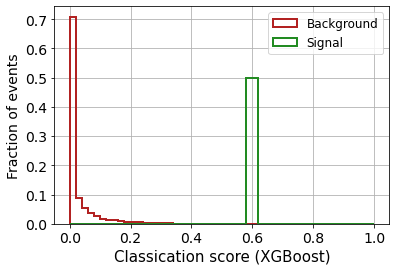

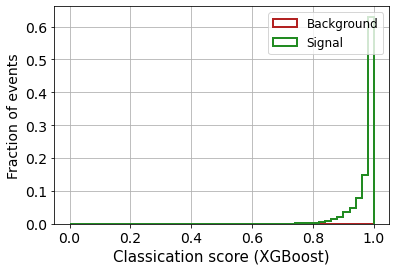

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.59822	validation_1-logloss:0.69764
[1]	validation_0-logloss:0.52047	validation_1-logloss:0.71034
[2]	validation_0-logloss:0.45564	validation_1-logloss:0.72915
[3]	validation_0-logloss:0.40084	validation_1-logloss:0.75273
[4]	validation_0-logloss:0.35402	validation_1-logloss:0.78009
[5]	validation_0-logloss:0.31369	validation_1-logloss:0.81062
[6]	validation_0-logloss:0.27871	validation_1-logloss:0.84366
[7]	validation_0-logloss:0.24821	validation_1-logloss:0.87880
[8]	validation_0-logloss:0.22148	validation_1-logloss:0.91570
[9]	validation_0-logloss:0.19796	validation_1-logloss:0.95417
[10]	validation_0-logloss:0.17719	validation_1-logloss:0.99391
[11]	validation_0-logloss:0.15881	validation_1-logloss:1.03486
[12]	validation_0-logloss:0.14250	validation_1-logloss:1.07679
[13]	validation_0-logloss:0.12799	validation_1-logloss:1.11954
[14]	validation_0-logloss:0.11506	validation_1-logloss:1.16305
[15]	validation_0-logloss:0.10351	validation_1-logloss:1.20727
[1

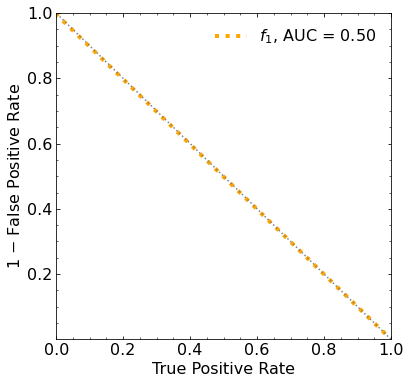


 ROC-AUC =  0.49829787234042555

final roc: 


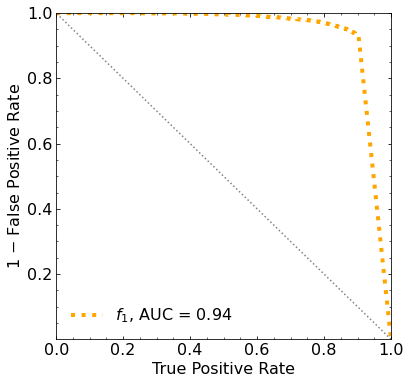


 ROC-AUC =  0.939005197399908
Classification score:


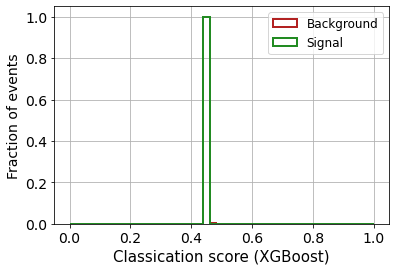


-------------------------------


#################
thresh_1ML:  0.6666666666666666
#################


X_mon_train_0:  (7448, 2744)
y_mon_train_0:  (7448,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 6
pred_XG_SM_test_0: 4737
pred_XG_NP_test_0: 537

X_mon_train_1:  (7552, 2744)
y_mon_train_1:  (7552,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7552
pred_XG_SM_train_1: 309
pred_XG_NP_train_1: 4417


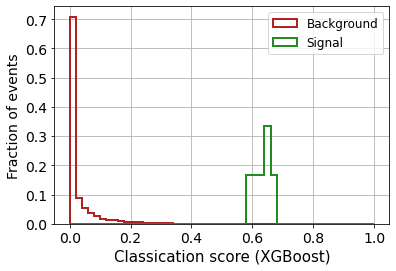

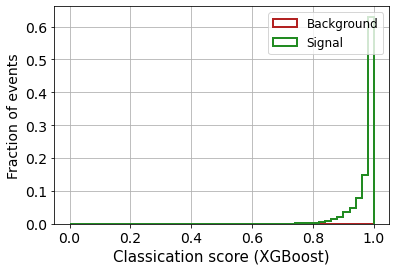

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.59839	validation_1-logloss:0.69756
[1]	validation_0-logloss:0.52080	validation_1-logloss:0.71020
[2]	validation_0-logloss:0.45609	validation_1-logloss:0.72895
[3]	validation_0-logloss:0.40140	validation_1-logloss:0.75243
[4]	validation_0-logloss:0.35468	validation_1-logloss:0.77969
[5]	validation_0-logloss:0.31444	validation_1-logloss:0.81010
[6]	validation_0-logloss:0.27954	validation_1-logloss:0.84297
[7]	validation_0-logloss:0.24910	validation_1-logloss:0.87796
[8]	validation_0-logloss:0.22243	validation_1-logloss:0.91469
[9]	validation_0-logloss:0.19897	validation_1-logloss:0.95296
[10]	validation_0-logloss:0.17826	validation_1-logloss:0.99258
[11]	validation_0-logloss:0.15993	validation_1-logloss:1.03333
[12]	validation_0-logloss:0.14366	validation_1-logloss:1.07500
[13]	validation_0-logloss:0.12912	validation_1-logloss:1.11722
[14]	validation_0-logloss:0.11617	validation_1-logloss:1.16019
[15]	validation_0-logloss:0.10461	validation_1-logloss:1.20393
[1

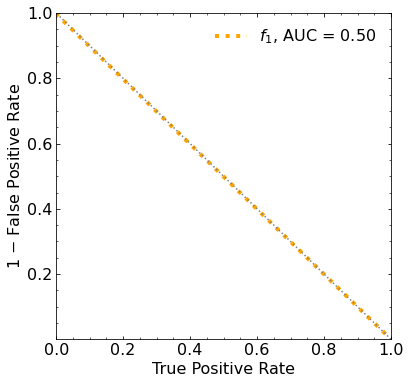


 ROC-AUC =  0.49858988768241147

final roc: 


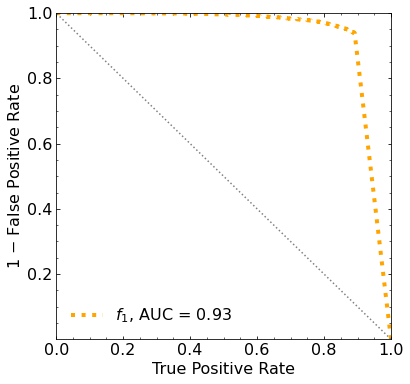


 ROC-AUC =  0.9339267875632994
Classification score:


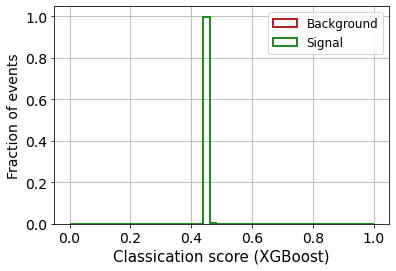


-------------------------------


#################
thresh_1ML:  0.7083333333333333
#################


X_mon_train_0:  (7452, 2744)
y_mon_train_0:  (7452,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 10
pred_XG_SM_test_0: 4765
pred_XG_NP_test_0: 589

X_mon_train_1:  (7548, 2744)
y_mon_train_1:  (7548,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7548
pred_XG_SM_train_1: 281
pred_XG_NP_train_1: 4365


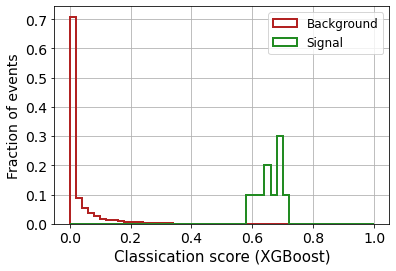

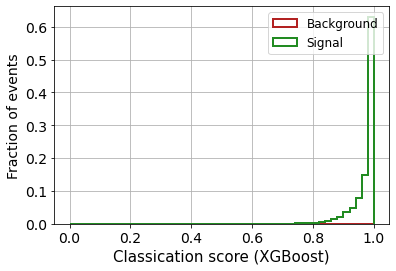

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.59859	validation_1-logloss:0.69749
[1]	validation_0-logloss:0.52115	validation_1-logloss:0.71011
[2]	validation_0-logloss:0.45658	validation_1-logloss:0.72877
[3]	validation_0-logloss:0.40201	validation_1-logloss:0.75217
[4]	validation_0-logloss:0.35540	validation_1-logloss:0.77938
[5]	validation_0-logloss:0.31525	validation_1-logloss:0.80965
[6]	validation_0-logloss:0.28044	validation_1-logloss:0.84240
[7]	validation_0-logloss:0.25009	validation_1-logloss:0.87728
[8]	validation_0-logloss:0.22349	validation_1-logloss:0.91384
[9]	validation_0-logloss:0.20010	validation_1-logloss:0.95203
[10]	validation_0-logloss:0.17947	validation_1-logloss:0.99136
[11]	validation_0-logloss:0.16120	validation_1-logloss:1.03199
[12]	validation_0-logloss:0.14500	validation_1-logloss:1.07337
[13]	validation_0-logloss:0.13052	validation_1-logloss:1.11537
[14]	validation_0-logloss:0.11763	validation_1-logloss:1.15799
[15]	validation_0-logloss:0.10612	validation_1-logloss:1.20121
[1

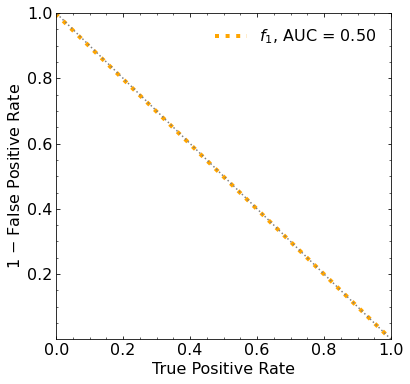


 ROC-AUC =  0.49843546516496023

final roc: 


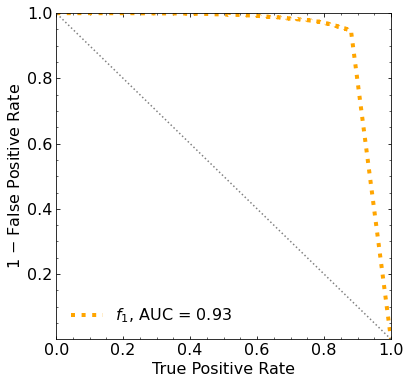


 ROC-AUC =  0.9292693933614541
Classification score:


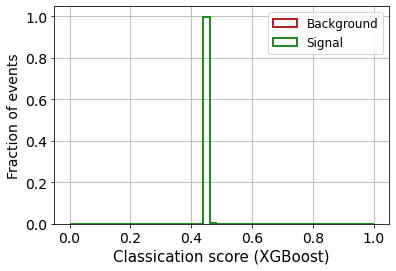


-------------------------------


#################
thresh_1ML:  0.75
#################


X_mon_train_0:  (7464, 2744)
y_mon_train_0:  (7464,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 22
pred_XG_SM_test_0: 4801
pred_XG_NP_test_0: 661

X_mon_train_1:  (7536, 2744)
y_mon_train_1:  (7536,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7536
pred_XG_SM_train_1: 245
pred_XG_NP_train_1: 4293


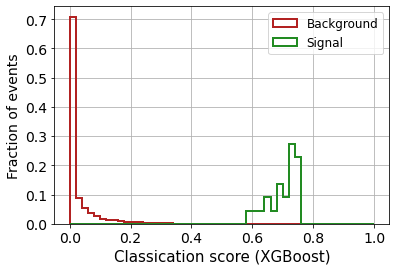

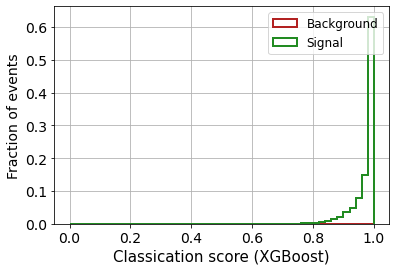

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff86d5ed040>
Traceback (most recent call last):
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifi

[0]	validation_0-logloss:0.61091	validation_1-logloss:0.69630
[1]	validation_0-logloss:0.54402	validation_1-logloss:0.69039
[2]	validation_0-logloss:0.48667	validation_1-logloss:0.70460
[3]	validation_0-logloss:0.43714	validation_1-logloss:0.71785
[4]	validation_0-logloss:0.39557	validation_1-logloss:0.74306
[5]	validation_0-logloss:0.35396	validation_1-logloss:0.76733
[6]	validation_0-logloss:0.32140	validation_1-logloss:0.79701
[7]	validation_0-logloss:0.29240	validation_1-logloss:0.81936
[8]	validation_0-logloss:0.26368	validation_1-logloss:0.84984
[9]	validation_0-logloss:0.24034	validation_1-logloss:0.88332
[10]	validation_0-logloss:0.21916	validation_1-logloss:0.91338
[11]	validation_0-logloss:0.20093	validation_1-logloss:0.94508
[12]	validation_0-logloss:0.18236	validation_1-logloss:0.98350
[13]	validation_0-logloss:0.16727	validation_1-logloss:1.02344
[14]	validation_0-logloss:0.15235	validation_1-logloss:1.06208
[15]	validation_0-logloss:0.13993	validation_1-logloss:1.10488
[1

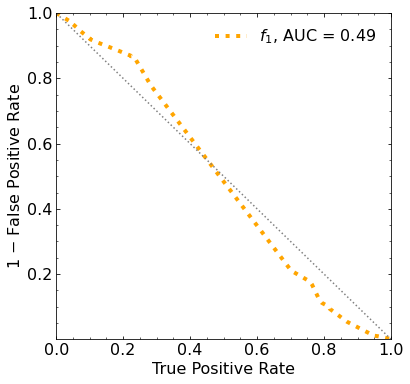


 ROC-AUC =  0.4883634933594583

final roc: 


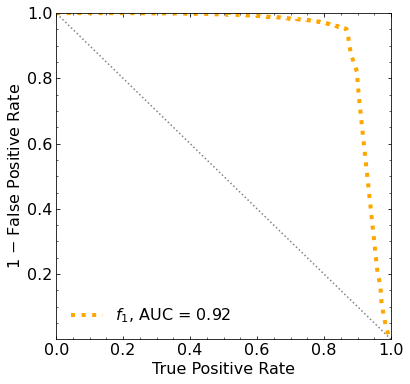


 ROC-AUC =  0.9215238177759365
Classification score:


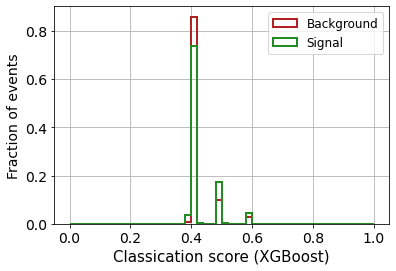


-------------------------------


#################
thresh_1ML:  0.7916666666666666
#################


X_mon_train_0:  (7495, 2744)
y_mon_train_0:  (7495,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 53
pred_XG_SM_test_0: 4830
pred_XG_NP_test_0: 757

X_mon_train_1:  (7505, 2744)
y_mon_train_1:  (7505,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7505
pred_XG_SM_train_1: 216
pred_XG_NP_train_1: 4197


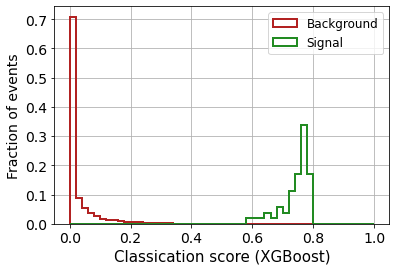

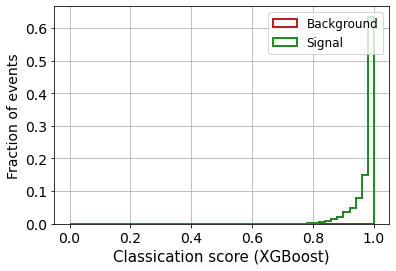

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff70d00b1f0>
Traceback (most recent call last):
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifi

[0]	validation_0-logloss:0.62272	validation_1-logloss:0.68667
[1]	validation_0-logloss:0.56441	validation_1-logloss:0.68652
[2]	validation_0-logloss:0.51302	validation_1-logloss:0.69637
[3]	validation_0-logloss:0.46691	validation_1-logloss:0.70708
[4]	validation_0-logloss:0.42830	validation_1-logloss:0.71626
[5]	validation_0-logloss:0.39259	validation_1-logloss:0.73630
[6]	validation_0-logloss:0.36028	validation_1-logloss:0.76046
[7]	validation_0-logloss:0.33108	validation_1-logloss:0.78317
[8]	validation_0-logloss:0.30530	validation_1-logloss:0.80590
[9]	validation_0-logloss:0.28174	validation_1-logloss:0.82440
[10]	validation_0-logloss:0.25984	validation_1-logloss:0.84968
[11]	validation_0-logloss:0.24046	validation_1-logloss:0.87012
[12]	validation_0-logloss:0.22349	validation_1-logloss:0.89694
[13]	validation_0-logloss:0.20775	validation_1-logloss:0.92756
[14]	validation_0-logloss:0.19479	validation_1-logloss:0.95644
[15]	validation_0-logloss:0.18147	validation_1-logloss:0.98759
[1

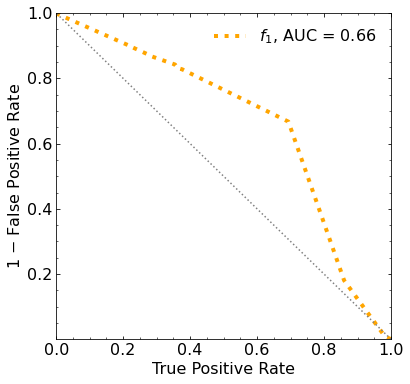


 ROC-AUC =  0.6631189642016131

final roc: 


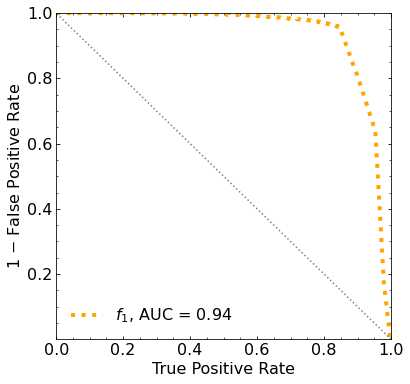


 ROC-AUC =  0.9380279346843917
Classification score:


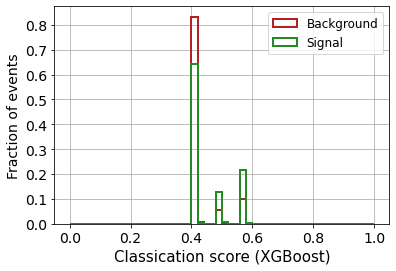


-------------------------------


#################
thresh_1ML:  0.8333333333333333
#################


X_mon_train_0:  (7548, 2744)
y_mon_train_0:  (7548,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 106
pred_XG_SM_test_0: 4867
pred_XG_NP_test_0: 878

X_mon_train_1:  (7452, 2744)
y_mon_train_1:  (7452,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7452
pred_XG_SM_train_1: 179
pred_XG_NP_train_1: 4076


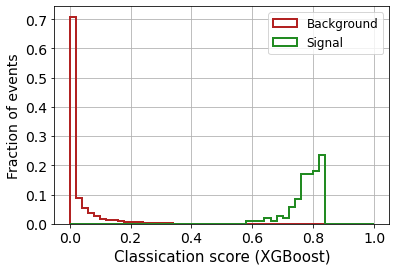

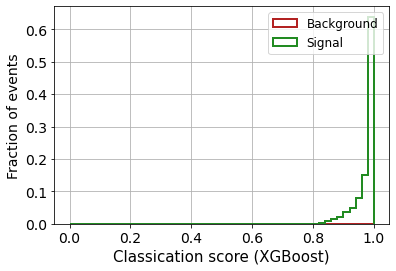

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff707c078b0>
Traceback (most recent call last):
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifi

[0]	validation_0-logloss:0.62698	validation_1-logloss:0.68413
[1]	validation_0-logloss:0.57375	validation_1-logloss:0.68227
[2]	validation_0-logloss:0.52453	validation_1-logloss:0.68285
[3]	validation_0-logloss:0.48266	validation_1-logloss:0.68545
[4]	validation_0-logloss:0.44778	validation_1-logloss:0.69564
[5]	validation_0-logloss:0.41386	validation_1-logloss:0.70943
[6]	validation_0-logloss:0.38472	validation_1-logloss:0.72457
[7]	validation_0-logloss:0.35945	validation_1-logloss:0.73936
[8]	validation_0-logloss:0.33498	validation_1-logloss:0.75869
[9]	validation_0-logloss:0.31338	validation_1-logloss:0.77715
[10]	validation_0-logloss:0.29315	validation_1-logloss:0.79649
[11]	validation_0-logloss:0.27550	validation_1-logloss:0.81678
[12]	validation_0-logloss:0.26043	validation_1-logloss:0.83853
[13]	validation_0-logloss:0.24593	validation_1-logloss:0.86090
[14]	validation_0-logloss:0.23214	validation_1-logloss:0.87899
[15]	validation_0-logloss:0.22004	validation_1-logloss:0.90199
[1

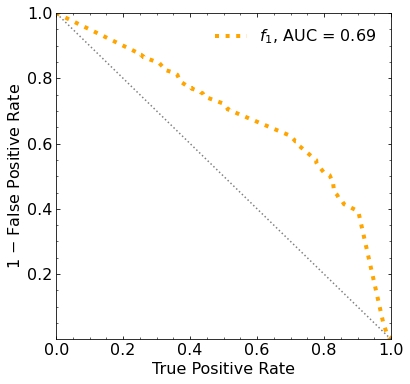


 ROC-AUC =  0.6856933146058739

final roc: 


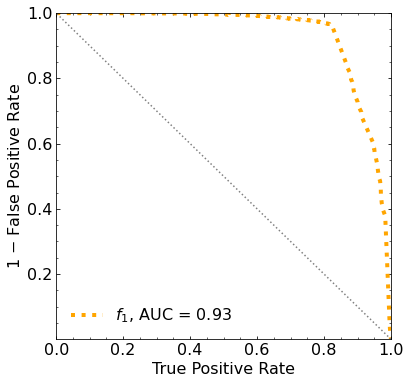


 ROC-AUC =  0.9347771395370904
Classification score:


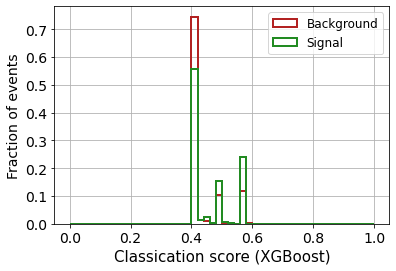


-------------------------------


#################
thresh_1ML:  0.875
#################


X_mon_train_0:  (7708, 2744)
y_mon_train_0:  (7708,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 266
pred_XG_SM_test_0: 4908
pred_XG_NP_test_0: 1046

X_mon_train_1:  (7292, 2744)
y_mon_train_1:  (7292,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 7292
pred_XG_SM_train_1: 138
pred_XG_NP_train_1: 3908


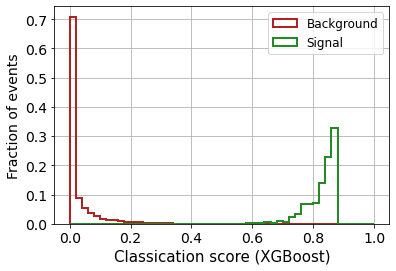

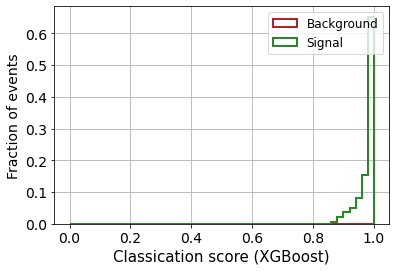

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff70be151f0>
Traceback (most recent call last):
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifi

[0]	validation_0-logloss:0.64068	validation_1-logloss:0.68128
[1]	validation_0-logloss:0.59400	validation_1-logloss:0.67768
[2]	validation_0-logloss:0.55491	validation_1-logloss:0.67390
[3]	validation_0-logloss:0.52166	validation_1-logloss:0.66992
[4]	validation_0-logloss:0.49020	validation_1-logloss:0.67351
[5]	validation_0-logloss:0.46211	validation_1-logloss:0.67519
[6]	validation_0-logloss:0.43834	validation_1-logloss:0.67943
[7]	validation_0-logloss:0.41458	validation_1-logloss:0.68748
[8]	validation_0-logloss:0.39281	validation_1-logloss:0.69312
[9]	validation_0-logloss:0.37413	validation_1-logloss:0.70326
[10]	validation_0-logloss:0.35696	validation_1-logloss:0.70391
[11]	validation_0-logloss:0.34051	validation_1-logloss:0.70829
[12]	validation_0-logloss:0.32687	validation_1-logloss:0.71898
[13]	validation_0-logloss:0.31387	validation_1-logloss:0.72977
[14]	validation_0-logloss:0.29987	validation_1-logloss:0.74289
[15]	validation_0-logloss:0.28744	validation_1-logloss:0.75980
[1

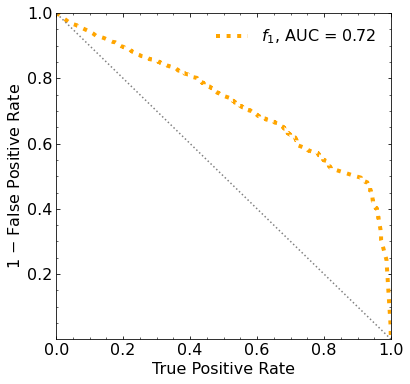


 ROC-AUC =  0.7230971481375863

final roc: 


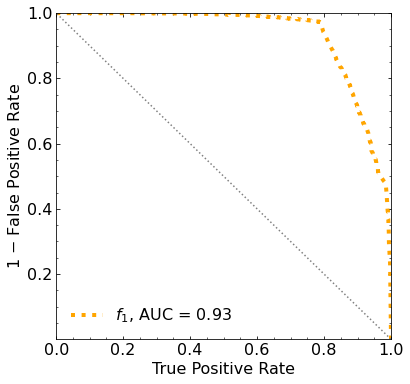


 ROC-AUC =  0.9332047864531254
Classification score:


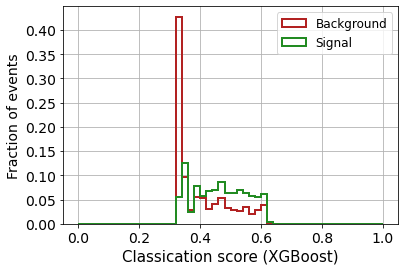


-------------------------------


#################
thresh_1ML:  0.9166666666666666
#################


X_mon_train_0:  (8121, 2744)
y_mon_train_0:  (8121,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 679
pred_XG_SM_test_0: 4944
pred_XG_NP_test_0: 1282

X_mon_train_1:  (6879, 2744)
y_mon_train_1:  (6879,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 6879
pred_XG_SM_train_1: 102
pred_XG_NP_train_1: 3672


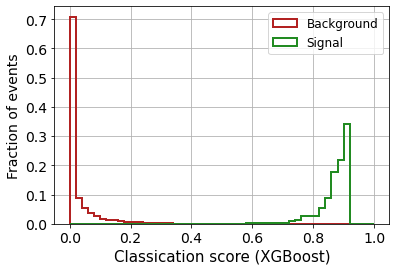

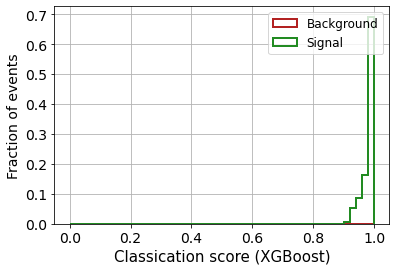

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff70bf80280>
Traceback (most recent call last):
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifi

[0]	validation_0-logloss:0.64810	validation_1-logloss:0.67365
[1]	validation_0-logloss:0.60919	validation_1-logloss:0.65786
[2]	validation_0-logloss:0.57522	validation_1-logloss:0.64645
[3]	validation_0-logloss:0.54576	validation_1-logloss:0.63410
[4]	validation_0-logloss:0.52035	validation_1-logloss:0.62880
[5]	validation_0-logloss:0.49575	validation_1-logloss:0.62630
[6]	validation_0-logloss:0.47224	validation_1-logloss:0.62177
[7]	validation_0-logloss:0.45273	validation_1-logloss:0.61888
[8]	validation_0-logloss:0.43449	validation_1-logloss:0.61901
[9]	validation_0-logloss:0.41768	validation_1-logloss:0.62107
[10]	validation_0-logloss:0.40137	validation_1-logloss:0.61804
[11]	validation_0-logloss:0.38674	validation_1-logloss:0.61888
[12]	validation_0-logloss:0.37377	validation_1-logloss:0.61580
[13]	validation_0-logloss:0.36128	validation_1-logloss:0.61827
[14]	validation_0-logloss:0.34912	validation_1-logloss:0.61892
[15]	validation_0-logloss:0.33806	validation_1-logloss:0.61602
[1

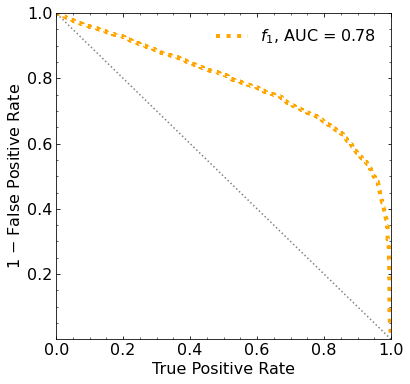


 ROC-AUC =  0.7843630250064373

final roc: 


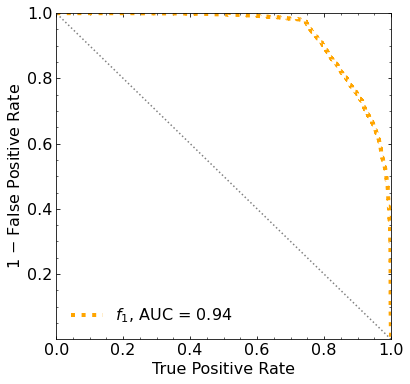


 ROC-AUC =  0.9370655532284253
Classification score:


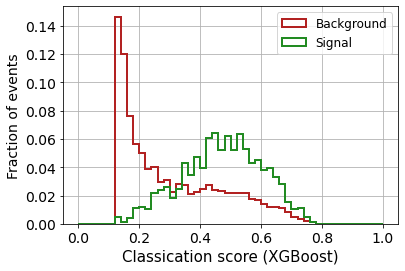


-------------------------------


#################
thresh_1ML:  0.9583333333333333
#################


X_mon_train_0:  (9054, 2744)
y_mon_train_0:  (9054,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 1612
pred_XG_SM_test_0: 4986
pred_XG_NP_test_0: 1784

X_mon_train_1:  (5946, 2744)
y_mon_train_1:  (5946,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 5946
pred_XG_SM_train_1: 60
pred_XG_NP_train_1: 3170


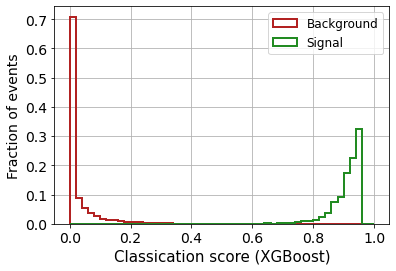

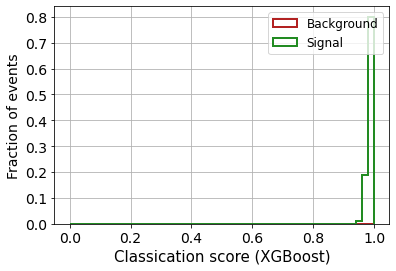

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff7044bdc10>
Traceback (most recent call last):
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifi

[0]	validation_0-logloss:0.65209	validation_1-logloss:0.65991
[1]	validation_0-logloss:0.61735	validation_1-logloss:0.63032
[2]	validation_0-logloss:0.58781	validation_1-logloss:0.60746
[3]	validation_0-logloss:0.56084	validation_1-logloss:0.58662
[4]	validation_0-logloss:0.53719	validation_1-logloss:0.56995
[5]	validation_0-logloss:0.51605	validation_1-logloss:0.55352
[6]	validation_0-logloss:0.49651	validation_1-logloss:0.54317
[7]	validation_0-logloss:0.47930	validation_1-logloss:0.53170
[8]	validation_0-logloss:0.46331	validation_1-logloss:0.52266
[9]	validation_0-logloss:0.44885	validation_1-logloss:0.51509
[10]	validation_0-logloss:0.43568	validation_1-logloss:0.50783
[11]	validation_0-logloss:0.42339	validation_1-logloss:0.50105
[12]	validation_0-logloss:0.41108	validation_1-logloss:0.49597
[13]	validation_0-logloss:0.39944	validation_1-logloss:0.49207
[14]	validation_0-logloss:0.38944	validation_1-logloss:0.48636
[15]	validation_0-logloss:0.37955	validation_1-logloss:0.48214
[1

[130]	validation_0-logloss:0.07558	validation_1-logloss:0.35560
[131]	validation_0-logloss:0.07525	validation_1-logloss:0.35622
[132]	validation_0-logloss:0.07482	validation_1-logloss:0.35621
[133]	validation_0-logloss:0.07427	validation_1-logloss:0.35629
[134]	validation_0-logloss:0.07354	validation_1-logloss:0.35586
[135]	validation_0-logloss:0.07290	validation_1-logloss:0.35455
[136]	validation_0-logloss:0.07203	validation_1-logloss:0.35505
[137]	validation_0-logloss:0.07151	validation_1-logloss:0.35541
[138]	validation_0-logloss:0.07083	validation_1-logloss:0.35495
[139]	validation_0-logloss:0.07036	validation_1-logloss:0.35414
[140]	validation_0-logloss:0.06952	validation_1-logloss:0.35374
[141]	validation_0-logloss:0.06899	validation_1-logloss:0.35252
[142]	validation_0-logloss:0.06822	validation_1-logloss:0.35214
[143]	validation_0-logloss:0.06774	validation_1-logloss:0.35186
[144]	validation_0-logloss:0.06702	validation_1-logloss:0.34980
[145]	validation_0-logloss:0.06622	valid

[259]	validation_0-logloss:0.02758	validation_1-logloss:0.31861
[260]	validation_0-logloss:0.02737	validation_1-logloss:0.31820
[261]	validation_0-logloss:0.02721	validation_1-logloss:0.31836
[262]	validation_0-logloss:0.02708	validation_1-logloss:0.31823
[263]	validation_0-logloss:0.02683	validation_1-logloss:0.31766
[264]	validation_0-logloss:0.02673	validation_1-logloss:0.31816
[265]	validation_0-logloss:0.02651	validation_1-logloss:0.31792
[266]	validation_0-logloss:0.02634	validation_1-logloss:0.31757
[267]	validation_0-logloss:0.02627	validation_1-logloss:0.31765
[268]	validation_0-logloss:0.02614	validation_1-logloss:0.31762
[269]	validation_0-logloss:0.02592	validation_1-logloss:0.31701
[270]	validation_0-logloss:0.02580	validation_1-logloss:0.31727
[271]	validation_0-logloss:0.02575	validation_1-logloss:0.31706
[272]	validation_0-logloss:0.02554	validation_1-logloss:0.31638
[273]	validation_0-logloss:0.02536	validation_1-logloss:0.31629
[274]	validation_0-logloss:0.02512	valid

[388]	validation_0-logloss:0.01199	validation_1-logloss:0.30440
[389]	validation_0-logloss:0.01191	validation_1-logloss:0.30369
[390]	validation_0-logloss:0.01183	validation_1-logloss:0.30360
[391]	validation_0-logloss:0.01172	validation_1-logloss:0.30352
[392]	validation_0-logloss:0.01161	validation_1-logloss:0.30313
[393]	validation_0-logloss:0.01155	validation_1-logloss:0.30279
[394]	validation_0-logloss:0.01150	validation_1-logloss:0.30298
[395]	validation_0-logloss:0.01147	validation_1-logloss:0.30275
[396]	validation_0-logloss:0.01140	validation_1-logloss:0.30244
[397]	validation_0-logloss:0.01133	validation_1-logloss:0.30164
[398]	validation_0-logloss:0.01123	validation_1-logloss:0.30157
[399]	validation_0-logloss:0.01115	validation_1-logloss:0.30158
[400]	validation_0-logloss:0.01108	validation_1-logloss:0.30173
[401]	validation_0-logloss:0.01102	validation_1-logloss:0.30164
[402]	validation_0-logloss:0.01096	validation_1-logloss:0.30119
[403]	validation_0-logloss:0.01087	valid

[517]	validation_0-logloss:0.00554	validation_1-logloss:0.29274
[518]	validation_0-logloss:0.00553	validation_1-logloss:0.29289
[519]	validation_0-logloss:0.00552	validation_1-logloss:0.29294
[520]	validation_0-logloss:0.00550	validation_1-logloss:0.29295
[521]	validation_0-logloss:0.00546	validation_1-logloss:0.29334
[522]	validation_0-logloss:0.00542	validation_1-logloss:0.29330
[523]	validation_0-logloss:0.00538	validation_1-logloss:0.29309
[524]	validation_0-logloss:0.00534	validation_1-logloss:0.29224
[525]	validation_0-logloss:0.00532	validation_1-logloss:0.29205
[526]	validation_0-logloss:0.00529	validation_1-logloss:0.29208
[527]	validation_0-logloss:0.00526	validation_1-logloss:0.29192
[528]	validation_0-logloss:0.00524	validation_1-logloss:0.29223
[529]	validation_0-logloss:0.00521	validation_1-logloss:0.29222
[530]	validation_0-logloss:0.00518	validation_1-logloss:0.29214
[531]	validation_0-logloss:0.00514	validation_1-logloss:0.29126
[532]	validation_0-logloss:0.00513	valid

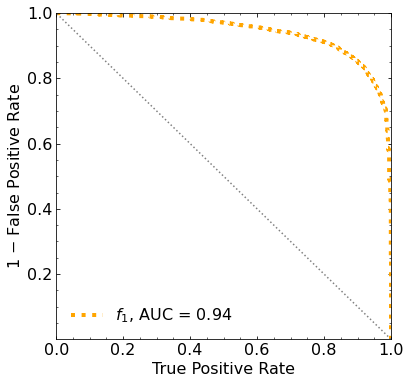


 ROC-AUC =  0.9428551288900402

final roc: 


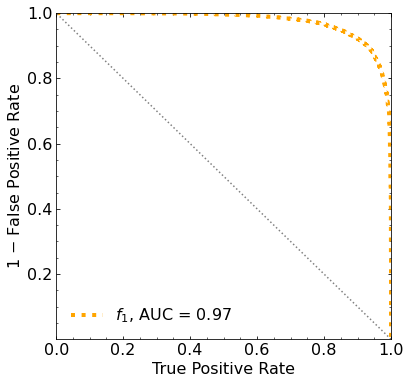


 ROC-AUC =  0.9740117203520107
Classification score:


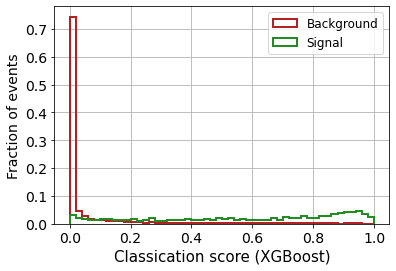


-------------------------------


#################
thresh_1ML:  1.0
#################


X_mon_train_0:  (15000, 2744)
y_mon_train_0:  (15000,)
pred_XG_SM_train_0: 7442
pred_XG_NP_train_0: 7558
pred_XG_SM_test_0: 5046
pred_XG_NP_test_0: 4954

X_mon_train_1:  (0,)
y_mon_train_1:  (0,)
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 0
pred_XG_SM_train_1: 0
pred_XG_NP_train_1: 0


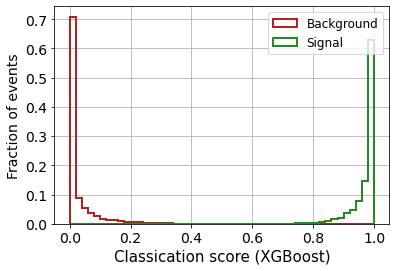

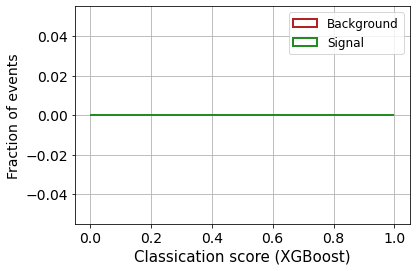

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff709017ee0>
Traceback (most recent call last):
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/andres/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifi

[0]	validation_0-logloss:0.64284	validation_1-logloss:0.64615
[1]	validation_0-logloss:0.59962	validation_1-logloss:0.60530
[2]	validation_0-logloss:0.56289	validation_1-logloss:0.57117
[3]	validation_0-logloss:0.53027	validation_1-logloss:0.54224
[4]	validation_0-logloss:0.50299	validation_1-logloss:0.51750
[5]	validation_0-logloss:0.47838	validation_1-logloss:0.49527
[6]	validation_0-logloss:0.45662	validation_1-logloss:0.47546
[7]	validation_0-logloss:0.43734	validation_1-logloss:0.45855
[8]	validation_0-logloss:0.41957	validation_1-logloss:0.44317
[9]	validation_0-logloss:0.40337	validation_1-logloss:0.42923
[10]	validation_0-logloss:0.38879	validation_1-logloss:0.41622
[11]	validation_0-logloss:0.37530	validation_1-logloss:0.40517
[12]	validation_0-logloss:0.36341	validation_1-logloss:0.39524
[13]	validation_0-logloss:0.35184	validation_1-logloss:0.38598
[14]	validation_0-logloss:0.34102	validation_1-logloss:0.37729
[15]	validation_0-logloss:0.33082	validation_1-logloss:0.36910
[1

[130]	validation_0-logloss:0.06581	validation_1-logloss:0.19468
[131]	validation_0-logloss:0.06515	validation_1-logloss:0.19461
[132]	validation_0-logloss:0.06468	validation_1-logloss:0.19459
[133]	validation_0-logloss:0.06414	validation_1-logloss:0.19441
[134]	validation_0-logloss:0.06366	validation_1-logloss:0.19429
[135]	validation_0-logloss:0.06325	validation_1-logloss:0.19461
[136]	validation_0-logloss:0.06281	validation_1-logloss:0.19444
[137]	validation_0-logloss:0.06241	validation_1-logloss:0.19418
[138]	validation_0-logloss:0.06193	validation_1-logloss:0.19411
[139]	validation_0-logloss:0.06137	validation_1-logloss:0.19420
[140]	validation_0-logloss:0.06075	validation_1-logloss:0.19398
[141]	validation_0-logloss:0.06016	validation_1-logloss:0.19373
[142]	validation_0-logloss:0.05974	validation_1-logloss:0.19380
[143]	validation_0-logloss:0.05919	validation_1-logloss:0.19368
[144]	validation_0-logloss:0.05857	validation_1-logloss:0.19324
[145]	validation_0-logloss:0.05807	valid

[259]	validation_0-logloss:0.02524	validation_1-logloss:0.18602
[260]	validation_0-logloss:0.02505	validation_1-logloss:0.18612
[261]	validation_0-logloss:0.02493	validation_1-logloss:0.18616
[262]	validation_0-logloss:0.02483	validation_1-logloss:0.18613
[263]	validation_0-logloss:0.02467	validation_1-logloss:0.18608
[264]	validation_0-logloss:0.02457	validation_1-logloss:0.18612
[265]	validation_0-logloss:0.02446	validation_1-logloss:0.18593
[266]	validation_0-logloss:0.02431	validation_1-logloss:0.18598
[267]	validation_0-logloss:0.02411	validation_1-logloss:0.18614
[268]	validation_0-logloss:0.02392	validation_1-logloss:0.18622
[269]	validation_0-logloss:0.02370	validation_1-logloss:0.18616
[270]	validation_0-logloss:0.02356	validation_1-logloss:0.18629
[271]	validation_0-logloss:0.02350	validation_1-logloss:0.18639
[272]	validation_0-logloss:0.02336	validation_1-logloss:0.18642
[273]	validation_0-logloss:0.02323	validation_1-logloss:0.18643
[274]	validation_0-logloss:0.02315	valid

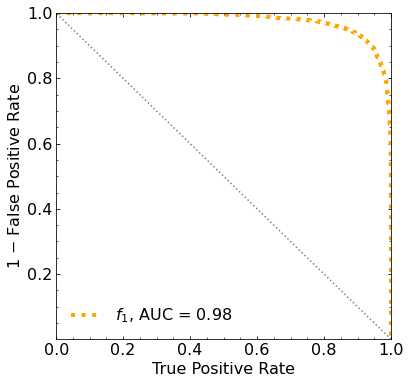


 ROC-AUC =  0.9771309443631307

final roc: 


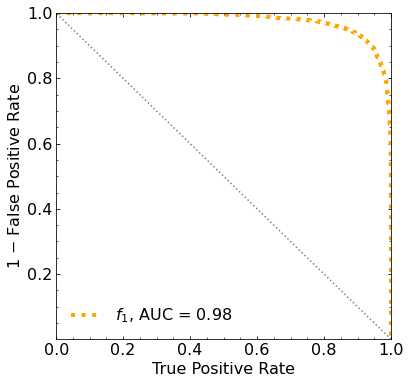


 ROC-AUC =  0.9771309443631307
Classification score:


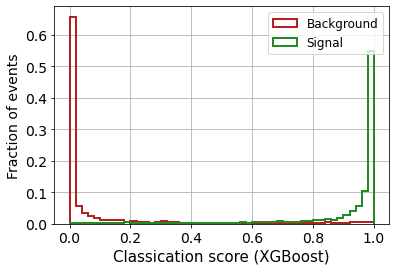


-------------------------------



In [34]:
y_pred_xg_train = classifier.predict_proba(X_mon_train).T[1]

thresh_1ML = np.linspace(0,1,25)

print('ML Output threshold: ', thresh_1ML)


save_SsqrtB_2ML = []
save_auc = []

for it_1ML in range(len(thresh_1ML)):
    
    print('\n#################')
    print('thresh_1ML: ', thresh_1ML[it_1ML])
    print('#################\n')
    
    # TRAIN SET #

    X_mon_train_0 = []
    y_mon_train_0 = []
    pred_XG_SM_train_0 = []
    pred_XG_NP_train_0 = []

    X_mon_train_1 = []
    y_mon_train_1 = []
    pred_XG_SM_train_1 = []
    pred_XG_NP_train_1 = []

    for i in range(len(y_mon_train)):
        if y_pred_xg_train[i] < thresh_1ML[it_1ML]:
            X_mon_train_0.append(X_mon_train[i].tolist())
            y_mon_train_0.append(int(y_mon_train[i].tolist()))

            if y_mon_train[i] == 0:
                pred_XG_SM_train_0.append(y_pred_xg_train[i])
            else:
                pred_XG_NP_train_0.append(y_pred_xg_train[i])

        else:
            X_mon_train_1.append(X_mon_train[i].tolist())
            y_mon_train_1.append(int(y_mon_train[i].tolist()))

            if y_mon_train[i] == 0:
                pred_XG_SM_train_1.append(y_pred_xg_train[i])
            else:
                pred_XG_NP_train_1.append(y_pred_xg_train[i])

    X_mon_train_0 = np.asarray(X_mon_train_0)
    y_mon_train_0 = np.asarray(y_mon_train_0)
    X_mon_train_1 = np.asarray(X_mon_train_1)
    y_mon_train_1 = np.asarray(y_mon_train_1)



    # TEST SET #

    X_mon_test_0 = []
    y_mon_test_0 = []
    pred_XG_SM_test_0 = []
    pred_XG_NP_test_0 = []

    X_mon_test_1 = []
    y_mon_test_1 = []
    pred_XG_SM_test_1 = []
    pred_XG_NP_test_1 = []

    for i in range(len(y_mon_test)):
        if y_pred_xg[i] < thresh_1ML[it_1ML]:
            X_mon_test_0.append(X_mon_test[i].tolist())
            y_mon_test_0.append(int(y_mon_test[i].tolist()))
            
            if y_mon_test[i] == 0:
                pred_XG_SM_test_0.append(y_pred_xg[i])
            else:
                pred_XG_NP_test_0.append(y_pred_xg[i])

        else:
            X_mon_test_1.append(X_mon_test[i].tolist())
            y_mon_test_1.append(int(y_mon_test[i].tolist()))
            
            if y_mon_test[i] == 0:
                pred_XG_SM_test_1.append(y_pred_xg[i])
            else:
                pred_XG_NP_test_1.append(y_pred_xg[i])
                
    B_thresh_1ML = len(pred_XG_SM_test_1)
    S_thresh_1ML = len(pred_XG_NP_test_1)


    print('\nX_mon_train_0: ', X_mon_train_0.shape)
    print('y_mon_train_0: ', y_mon_train_0.shape)
    print('pred_XG_SM_train_0:', len(pred_XG_SM_train_0))
    print('pred_XG_NP_train_0:', len(pred_XG_NP_train_0))
    print('pred_XG_SM_test_0:', len(pred_XG_SM_test_0))
    print('pred_XG_NP_test_0:', len(pred_XG_NP_test_0))

    print('\nX_mon_train_1: ', X_mon_train_1.shape)
    print('y_mon_train_1: ', y_mon_train_1.shape)
    print('pred_XG_SM_train_1:', len(pred_XG_SM_train_1))
    print('pred_XG_NP_train_1:', len(pred_XG_NP_train_1))
    print('pred_XG_SM_train_1:', len(pred_XG_SM_test_1))
    print('pred_XG_NP_train_1:', len(pred_XG_NP_test_1))




    weights = np.ones_like(pred_XG_SM_train_0)/float(len(pred_XG_SM_train_0))
    plt.hist(pred_XG_SM_train_0, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

    weights = np.ones_like(pred_XG_NP_train_0)/float(len(pred_XG_NP_train_0))
    plt.hist(pred_XG_NP_train_0, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Classication score (XGBoost)",fontsize=15)
    plt.ylabel("Fraction of events",fontsize=14)
    plt.grid()
    plt.legend(fontsize=12)

    plt.show()



    weights = np.ones_like(pred_XG_SM_train_1)/float(len(pred_XG_SM_train_1))
    plt.hist(pred_XG_SM_train_1, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

    weights = np.ones_like(pred_XG_NP_train_1)/float(len(pred_XG_NP_train_1))
    plt.hist(pred_XG_NP_train_1, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Classication score (XGBoost)",fontsize=15)
    plt.ylabel("Fraction of events",fontsize=14)
    plt.grid()
    plt.legend(fontsize=12)

    plt.show()
    
    
    
    if len(pred_XG_SM_train_0) > 0 and len(pred_XG_NP_train_0) > 0:
        
        if sum(y_mon_train_0) > 10 and (len(y_mon_train_0) - sum(y_mon_train_0) ) > 10:
            oversample = SMOTE()
            X_mon_train_0, y_mon_train_0 = oversample.fit_resample(X_mon_train_0, y_mon_train_0)


        # CLASSIFIER #


        # XGBoost with only the kinematic variables of the leptons

        # CLASSIFIER
        classifier_2ML = XGBClassifier(
            n_estimators=1500,
            learning_rate=0.1,
            reg_lambda=0.0,reg_alpha=0.0,
            gamma=0.0,objective='binary:logistic',
            max_depth=5,
            #eval_metric=["error", "logloss", "map"]
            eval_metric='logloss')

        # FIT
        classifier_2ML.fit(X_mon_train_0,y_mon_train_0,eval_set=[(X_mon_train_0, y_mon_train_0), (X_mon_val, y_mon_val)],
                early_stopping_rounds=50,#early stopping
                verbose=True)


        # PREDICTIONS
        y_pred_xg_2ML = classifier_2ML.predict_proba(X_mon_test_0).T[1]


        # ROC
        fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test_0, y_pred_xg_2ML)
        roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


        # PLOT THE ROC WITH AUC
        fig = plt.figure(figsize=(6, 6))
        gs = gridspec.GridSpec(1, 1) 
        ax0 = plt.subplot(gs[0])
        ax0.yaxis.set_ticks_position('both')
        ax0.xaxis.set_ticks_position('both')
        ax0.tick_params(direction="in",which="both")
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        ax0.minorticks_on()


        plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
        plt.plot([1,0],[0,1],ls=":",color="grey")
        plt.xlabel("True Positive Rate",fontsize=16)
        plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
        plt.legend()
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.yticks([0.2,0.4,0.6,0.8,1.])
        plt.legend(frameon=False,fontsize=16)
        plt.show()
        
        print('\n ROC-AUC = ', roc_auc_xg)
        
        
        
        print('\nfinal roc: ')
        labels = np.concatenate([np.zeros(len(pred_XG_SM_test_1)), np.ones(len(pred_XG_NP_test_1)), y_mon_test_0])
        predictions = np.concatenate([np.asarray(pred_XG_SM_test_1), np.asarray(pred_XG_NP_test_1) ,y_pred_xg_2ML])


        fpr_mon_xg, tpr_mon_xg, _ = roc_curve(labels, predictions)
        roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)

        save_auc.append( roc_auc_xg )


        # PLOT THE ROC WITH AUC
        fig = plt.figure(figsize=(6, 6))
        gs = gridspec.GridSpec(1, 1) 
        ax0 = plt.subplot(gs[0])
        ax0.yaxis.set_ticks_position('both')
        ax0.xaxis.set_ticks_position('both')
        ax0.tick_params(direction="in",which="both")
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        ax0.minorticks_on()


        plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
        plt.plot([1,0],[0,1],ls=":",color="grey")
        plt.xlabel("True Positive Rate",fontsize=16)
        plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
        plt.legend()
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.yticks([0.2,0.4,0.6,0.8,1.])
        plt.legend(frameon=False,fontsize=16)
        plt.show()
        
        print('\n ROC-AUC = ', roc_auc_xg)



        # XGBoost with the kinematic variables of the leptons

        ########################
        # CLASSIFICATION SCORE #
        ########################

        # Outputs for validation data set

        pred_XG_SM = []
        pred_XG_NP = []

        for i in range(len(y_mon_test_0)):
            if y_mon_test_0[i] == 0:
                pred_XG_SM.append(y_pred_xg_2ML[i])
            else:
                pred_XG_NP.append(y_pred_xg_2ML[i])


        print('Classification score:')

        weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
        nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

        weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
        nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Classication score (XGBoost)",fontsize=15)
        plt.ylabel("Fraction of events",fontsize=14)
        plt.grid()
        plt.legend(fontsize=12)

        plt.show()




        




        thresh_2ML = np.linspace(0,1,20)

        B_thresh = []
        S_thresh = []

        for it_2ML in range(len(thresh_2ML)):

            # TEST SET #

            pred_XG_SM_test_0_2ML = []
            pred_XG_NP_test_0_2ML = []

            pred_XG_SM_test_1_2ML = []
            pred_XG_NP_test_1_2ML = []

            for i in range(len(y_mon_test_0)):
                if y_pred_xg_2ML[i] < thresh_2ML[it_2ML]:
                    if y_mon_test_0[i] == 0:
                        pred_XG_SM_test_0_2ML.append(y_pred_xg_2ML[i])
                    else:
                        pred_XG_NP_test_0_2ML.append(y_pred_xg_2ML[i])

                else:
                    if y_mon_test_0[i] == 0:
                        pred_XG_SM_test_1_2ML.append(y_pred_xg_2ML[i])
                    else:
                        pred_XG_NP_test_1_2ML.append(y_pred_xg_2ML[i])

#             print('\nthresh: ', thresh_2ML[it_2ML])
    #         print('len(pred_XG_SM_test_1): ', len(pred_XG_SM_test_1))
    #         print('len(pred_XG_NP_test_1): ', len(pred_XG_NP_test_1))
            B_thresh.append( B_thresh_1ML + len(pred_XG_SM_test_1_2ML) )
            S_thresh.append( S_thresh_1ML + len(pred_XG_NP_test_1_2ML) )


        SsqrtB_2ML = []

        for i in range(len(B_thresh)):
            if B_thresh[i] >= 3:
                SsqrtB_2ML.append( S_thresh[i]/np.sqrt(B_thresh[i]) )
            else:
                SsqrtB_2ML.append(None)


        save_SsqrtB_2ML.append(SsqrtB_2ML)
        
        
        
    else:
        
        SsqrtB_2ML = []
        for it_2ML in range(20):
            SsqrtB_2ML.append(None)
            
            
        save_SsqrtB_2ML.append(SsqrtB_2ML)
        save_auc.append(None)
        
 
    
    
    print('\n-------------------------------\n')

roc_auc_only1ML:  0.9768742426358966


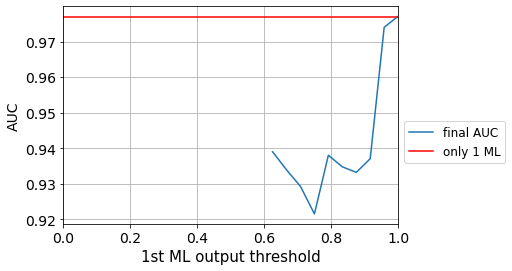

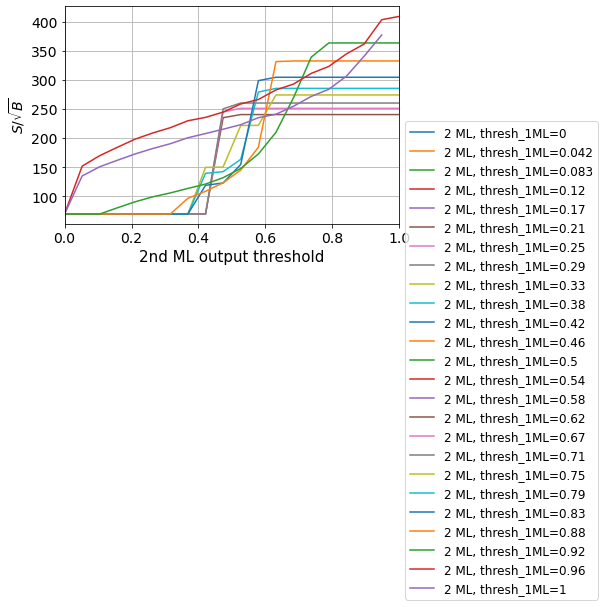

In [36]:
print('roc_auc_only1ML: ', roc_auc_only1ML)


plt.plot(thresh_1ML, save_auc, label='final AUC')

plt.axhline(y=roc_auc_only1ML, c='red', label='only 1 ML')
plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("1st ML output threshold",fontsize=15)
plt.ylabel("AUC",fontsize=14)
plt.grid()
plt.legend(fontsize=12, bbox_to_anchor=(1, 0.5))

plt.show()




# plt.plot(thresh, SsqrtB, ':', lw=4, label='1 ML')
for i in range(len(thresh_1ML)):
    plt.plot(thresh_2ML, save_SsqrtB_2ML[i], label='2 ML, thresh_1ML=%.2g' % thresh_1ML[i])

plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("2nd ML output threshold",fontsize=15)
plt.ylabel("$S/\sqrt{B}$",fontsize=14)
plt.grid()
plt.legend(fontsize=12, bbox_to_anchor=(1, 0.5))

plt.show()